In [3]:
# import the neccessary dependacies we will use by default
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.preprocessing import LabelEncoder
import hashlib

#import the neccessary components from pytorch
from copy import deepcopy  # this needed to be adjusted
import torch
import torch.nn as nn
import torch.optim as optim
import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

Some insights into this project:
- The category of machine learning models that these fall into is _supervised learning_. Supervised learning is a type of machine learning where the model is trained on labeled data. The label in this case is the method of data breach.

The models that will be tested out will fall into the following category of machine learning:
* <u><b>Logistic Regression</b></u>: This is a supervised Learning that can be used to predict a categorical outcome. In this case, the categorical outcome is the method of the data breach. The features that will be used are: entity, year, records and organization type.
* <u><b>Decision Trees</b></u>: This is another supervised learning algorithm that can be used to predict a categorical outcome. Decision trees work by creating a tree-like structure that represents the relationships between the features and the outcomes.
* <u><b>Support Vector Machine(SVMs):</u></b> This is a supervised learning algorithm that can be used to predict both categorical and continous outcomes. SVMs work by finding the hyperplane that best seperates the data points into different classes.
* <u><b>Random Forests</u></b> This is an ensemble learning algorithm that combines multiple decision trees to improve the accuracy of the predictions.
* <u><b>Neural Networks</u></b> This is a more complex algorithm that can be used to predict both categorical and continuous outcomes. Neural Networks work by learning the relationships between the features and the outcome through a process called backpropogation.

In [4]:
# load the dataset(s) we will be using
csv_file_path = os.path.abspath('df_1.csv');  # get the absolute path of the CS

df = pd.read_csv(csv_file_path);   # Read the CSV file into a datafram
# display the head to see if the dataset works as intended
df.head(10) 

,Unnamed: 0,Entity,Year,Records,Organization type,Method,Sources
0,0,21st Century Oncology,2016,2200000,healthcare,hacked,[5][6]
1,1,500px,2020,14870304,social networking,hacked,[7]
2,2,Accendo Insurance Co.,2020,175350,healthcare,poor security,[8][9]
3,3,Adobe Systems Incorporated,2013,152000000,tech,hacked,[10]
4,4,Adobe Inc.,2019,7500000,tech,poor security,[11][12]
5,5,Advocate Medical Group,2017,4000000,healthcare,lost / stolen media,[13][14]
6,6,AerServ (subsidiary of InMobi),2018,75000,advertising,hacked,[15]
7,7,"Affinity Health Plan, Inc.",2013,344579,healthcare,lost / stolen media,[16][17]
8,8,Airtel,2019,320000000,telecommunications,poor security,[18]
9,9,Air Canada,2018,20000,transport,hacked,[19]


From my exploration, I discovered that dataframe 3 and dataframe 1 are the same, so merging them would be useless, dataframe 2 is different from dataframe 1, therefore, merging them holds some value.

In [5]:
df.dtypes  # simply lists out the datatype we are working with

Unnamed: 0            int64
Entity               object
Year                 object
Records              object
Organization type    object
Method               object
Sources              object
dtype: object

In [6]:
df.columns # observe the column list

Index(['Unnamed: 0', 'Entity', 'Year', 'Records', 'Organization type',
       'Method', 'Sources'],
      dtype='object')

In [7]:
# we will need to rename the unnamed column
df.rename(columns={'Unnamed: 0' : 'Index'}, inplace=True)

In [8]:
# Test out the number of unique values contained in Entity
len(df['Entity'].unique())   #there's a total of 331 unique name for comapnies

331

Regarding the column __Entity__, there's 2 options in terms of data preprocessing:
* Drop the column altogether
* Apply Hashing

In [9]:
#create a hash function
def hash_function(text):
    return hashlib.sha256(text.encode()).hexdigest()

# create a new column for the hashed values
df['hashed_Entity'] = df['Entity'].apply(hash_function)

#observe the hashed column
df.head()  # we have the hashed entity

,Index,Entity,Year,Records,Organization type,Method,Sources,hashed_Entity
0,0,21st Century Oncology,2016,2200000,healthcare,hacked,[5][6],c3a872f67b2c21449ed696e019d008cbb15b384ed63164...
1,1,500px,2020,14870304,social networking,hacked,[7],39b1d7f5c52ecec4511c7d93214a3dc33915fcb67c51e1...
2,2,Accendo Insurance Co.,2020,175350,healthcare,poor security,[8][9],d37b82c7c3fef3eb56a05bc88697bd64c489f8b13b9ed8...
3,3,Adobe Systems Incorporated,2013,152000000,tech,hacked,[10],4ea8e5179ec6c6866f040ebfa23a41946cb05bd37b5ebc...
4,4,Adobe Inc.,2019,7500000,tech,poor security,[11][12],4e2eb72d6ffd4a841309dcd87b646d2408ac7394956117...


In [10]:
# create a copy of the dataframe and drop the Entity column 
#df_copy1 = df.drop(columns={'Entity'})

In [11]:
df_copy1 = df  # we don't want to make modifications to the original dataframe 

In [12]:
len(df_copy1['Organization type'].unique())   # in terms of organization type, there's 70 different unique values
df_copy1

,Index,Entity,Year,Records,Organization type,Method,Sources,hashed_Entity
0,0,21st Century Oncology,2016,2200000,healthcare,hacked,[5][6],c3a872f67b2c21449ed696e019d008cbb15b384ed63164...
1,1,500px,2020,14870304,social networking,hacked,[7],39b1d7f5c52ecec4511c7d93214a3dc33915fcb67c51e1...
2,2,Accendo Insurance Co.,2020,175350,healthcare,poor security,[8][9],d37b82c7c3fef3eb56a05bc88697bd64c489f8b13b9ed8...
3,3,Adobe Systems Incorporated,2013,152000000,tech,hacked,[10],4ea8e5179ec6c6866f040ebfa23a41946cb05bd37b5ebc...
4,4,Adobe Inc.,2019,7500000,tech,poor security,[11][12],4e2eb72d6ffd4a841309dcd87b646d2408ac7394956117...
...,...,...,...,...,...,...,...,...
347,347,Zynga,2019,173000000,social network,hacked,[406][407],637e6be11e5f556343bad0073ff64ddcf396a88cec35d7...
348,348,Unknown agency(believed to be tied to United S...,2020,200000000,financial,accidentally published,[408],985ee128022c38982d1de4c4173f538ced9151f0517fe9...
349,349,National Health Information Center (NCZI) of S...,2020,391250,healthcare,poor security,[409],869ada24f3639cb94ed2dd22ec15aca5928cb7b7c0bc28...
350,350,50 companies and government institutions,2022,6400000,various,poor security,[410] [411],89def538702db6ab06b39b1d28f5f7980de01dd04bd0a0...


In [13]:
# remove the special characters
df_copy1['Organization type'] = df_copy1['Organization type'].str.replace(',', '_')  # replace the cases of ',' with '_'.
df_copy1['Organization type'] = df_copy1['Organization type'].str.replace(' ', '_') # we also replace the cases of spacing with '_'.
df_copy1['Organization type'] = df_copy1['Organization type'].str.replace('__', '_')  # replace all instances of __ with _

Before encoding the organization type, I've made a copy of the DataFrame to preserve the original data. The `hashed_Entity` column is dropped as it is unnecessary for visualization; our focus is on industries rather than individual companies.

In [14]:
df_vis = df_copy1  #create another copy of the df_copy and perform further data preprocessing
#drop the hashed entity column
#df_vis.drop(columns={'hashed_Entity'}, inplace=True)  #note: after dropping the column the first time, you may end up running into an error if you were to rerun the code block again
#df_vis
# drop the Soruces and index column
df_vis.drop(columns=['Sources'], inplace=True)
df_vis.drop(columns=['Index'], inplace=True)
# check to see the new dataframe --> observe that df_vis no longer contains Sources and Index
df_vis  

,Entity,Year,Records,Organization type,Method,hashed_Entity
0,21st Century Oncology,2016,2200000,healthcare,hacked,c3a872f67b2c21449ed696e019d008cbb15b384ed63164...
1,500px,2020,14870304,social_networking,hacked,39b1d7f5c52ecec4511c7d93214a3dc33915fcb67c51e1...
2,Accendo Insurance Co.,2020,175350,healthcare,poor security,d37b82c7c3fef3eb56a05bc88697bd64c489f8b13b9ed8...
3,Adobe Systems Incorporated,2013,152000000,tech,hacked,4ea8e5179ec6c6866f040ebfa23a41946cb05bd37b5ebc...
4,Adobe Inc.,2019,7500000,tech,poor security,4e2eb72d6ffd4a841309dcd87b646d2408ac7394956117...
...,...,...,...,...,...,...
347,Zynga,2019,173000000,social_network,hacked,637e6be11e5f556343bad0073ff64ddcf396a88cec35d7...
348,Unknown agency(believed to be tied to United S...,2020,200000000,financial,accidentally published,985ee128022c38982d1de4c4173f538ced9151f0517fe9...
349,National Health Information Center (NCZI) of S...,2020,391250,healthcare,poor security,869ada24f3639cb94ed2dd22ec15aca5928cb7b7c0bc28...
350,50 companies and government institutions,2022,6400000,various,poor security,89def538702db6ab06b39b1d28f5f7980de01dd04bd0a0...


In [15]:
# initialize a list to store index positions and non-integer values as typles
non_integer_records = []  #initialized an empty list

#initialize a set to store unique industries
unique_industries = set()

# iterate through the 'Records' column and collect non-integer values with their index positions and industry
for index, (value, industry) in enumerate(zip(df_vis['Records'], df_vis['Organization type'])):
    try:
        int_value = int(value)  # convert the value to integer
    except ValueError:
        non_integer_records.append((index, str(value), industry)) #convert the value to string in the case of a value error, meaning the value isn't an integer, add the corresponding value to the non-integer list
        unique_industries.add(industry)  #append the industry that contains the non-integer value into the unique industries set, this will help filter out not only string values, but also multiple integer value columns
        
#print out the index positions, values, and industries for non-integer values
if non_integer_records:
    print("Non-integer values in the Records' column:")
    print("Index, value, Industry")
    for index, value, industry in non_integer_records:
        print(index, value, industry)
else:
    print("No non-integer values in the 'Records' column.")
    
#print out the list of unique industries from non-integer records
if unique_industries:
    print("Unique industries from non-integer records:")
    print(list(unique_industries))
else:
    print("No unique industries found in non-integer records.")
    

updated_non_integer_records = []
unique_types = list()  # initialize type as list
for industry in unique_industries:
    #create a seperate Dataframe for the current industry
    industry_df = df_vis[df_vis['Organization type'] == industry]  # industry df will contain all the industries within organization type that are also a subset of the unique_indsutries set
    
    #drop entries with non-integer values in 'Records'
    industry_df['Records'] = pd.to_numeric(industry_df['Records'], errors='coerce')   # to_numeric will change the datatype of the records column to integer datatype, the coerce parameter ensures that in the case of non-numerical values present, continue with the numerical conversion 
    industry_df = industry_df.dropna()  #this will drop non numerical values
    
    #calculate the mean records for the current industry
    mean_records = industry_df['Records'].mean()
    
    #add the type of mean_records of the types list
    unique_types.append(type(mean_records))
    
    #update records in the original dataframe if mean is not NaN and remove from non_integer_records
    #if the mean record is nan, its type will be float
    if type(mean_records) != float:
        #print mean records for the current industry
        print(f"industry: {industry}, Type: {type(mean_records)}, Mean Records: (mean_records)")
        for index, value, industry_name in non_integer_records:
            if industry_name == industry:
                df_vis.at[index, 'Records'] = mean_records
    else:
        updated_non_integer_records.append(industry)
        
        
    # make the types list a set
    #unique_types = set(unique_types)   # cannot use type as it is a reserved keyword in python
    print(f"types of mean_records: {unique_types}") # this line may have been causing errors
    print(f"updated non-integer records: {updated_non_integer_records}")
    
    #calculate the mean records value for the entire dataframe df_vis(excluding non-numerical values)
    df_vis['Records'] = pd.to_numeric(df_vis['Records'], errors='coerce')
    df_vis = df_vis.dropna()   # drop the non-numerical values
    mean_records_all = df_vis['Records'].mean()  # this will calculate the mean of the records column
    
    #replace 'Records' values in updated_non_integer_records with the mean records for the entire dataframe  --> this will replace all the non-integer values stored in the updated_non_integer_records with the mean value of Records
    for industry in updated_non_integer_records:
        # for each entry in the dataframe, if the industry matches the industry in the updated_non_integer_records, replace value
        for index, value, industry_name in non_integer_records:
            if industry_name == industry:
                df_vis.at[index, 'Records'] = mean_records_all

#print(df_vis) --> not neccessary to view at the moment, we can check for the changes at the end of the code
# check that there are no more non-integer values in Records
non_integer_records = []
for index, value, industry in zip(df_vis.index, df_vis['Records'], df_vis['Organization type']):  # purpose of the python zip function (as a side note to myself) --> The zip() function in python is used to combine two or more iterable dictionaries into a single variable, where corresponding elements from the input iterable are paired together as tuples. When using zip() with dictionaries, it pairs the keys and values of the dictionaries based on their position in the dictionary (applies for any other iterables, in this case, a series)
    try:
        int_value = int(value) #convert the value into integer using python typecast
    except ValueError:
        non_integer_records.append(index, str(value), industry)  #if it isn't possible to convert the value into an integer, in the case of an error, typecast the value as a string and append the index, value and industry onto the non_integer_records array
        
if non_integer_records:
    print("Non-integer values in the 'Records' column:")
    print("Index, Value, Industry") 
    for index, value, industry in non_integer_records:
        print(index, value, industry)
else:
    print("No remaining non-integer values in the 'Records' column!")
    
# update all the values in the records column to be intgeers
df_vis['Records'] = df_vis['Records'].astype(int)

#check the data types of each dataframe in the 'Records' column
print(df_vis.dtypes)
print(df_vis)      

Non-integer values in the Records' column:
Index, value, Industry
10 unknown web
25 unknown dating
27 G20 world leaders government
28 19 years of data academic
34 63 stores retail
40 nan gaming
41 unknown gambling
47 tens of thousands retail
48 over 5,000,000 government
66 unknown (client list) information_technology
76 millions retail
80 235 GB military
82 350 clients emails consulting_accounting
94 9,000,000 (approx) - basic booking, 2208 (credit card details) transport
104 unknown financial
109 unknown tech
119 Unknown Information_Security
134 unknown web
140 unknown healthcare
142 2.5GB transport
147 250 locations hotel
163 unknown mobile_carrier
168 500 locations restaurant
175 10 locations hotel
185 unknown software
198 unknown financial
199 93 stores retail
215 unknown telecom
220 unknown government
221 undisclosed web
232 unknown web
235 unknown hotel
243 unknown tech
248 Source Code Compromised Network_Monitoring
251 100 terabytes media
260 54 locations hotel
265 200 stores re

C:\Users\dasa7\AppData\Local\Temp\ipykernel_9972\2071693028.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  industry_df['Records'] = pd.to_numeric(industry_df['Records'], errors='coerce')   # to_numeric will change the datatype of the records column to integer datatype, the coerce parameter ensures that in the case of non-numerical values present, continue with the numerical conversion
C:\Users\dasa7\AppData\Local\Temp\ipykernel_9972\2071693028.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vis.at[index, 'Records'] = mean_records
C:\Users\dasa7\AppD

### Data Quality Check: Year Column Formatting

Before diving into analysis, let's ensure the 'year' column is correctly formatted. It should represent individual years (e.g., 2016 or 2019) rather than a range (e.g., 2016-2019). If the formatting is incorrect, we'll need to perform some data cleaning.

**Instructions:**

1. Inspect the 'year' column for any anomalies.
2. Ensure each entry is a standalone year (e.g., 2016) and not a range (e.g., 2016-2019).
3. If any issues are identified, proceed with data cleaning.

In [16]:
# Convert 'Year' column to string type  --> new line that has been added in order to avoid getting error
df_vis['Year'] = df_vis['Year'].astype(str)

# Check if any value in the 'Year' column is null
print("Null values:", df_vis['Year'].isnull().any())  # there are no null values in the 'Year' column

# Check if any value in the 'Year' column is not well formatted (i.e., not a number)
print("Non-numeric values:", df_vis['Year'].str.isnumeric().any())  # there are values that are not numeric

# Print out all the values in the 'Year' column that are not numeric
print("Non-numeric values:")
non_numeric_values = df_vis[~df_vis['Year'].str.isnumeric()]
print(non_numeric_values)


Null values: False
Non-numeric values: True
Non-numeric values:
                                                Entity           Year  \
96   Earl Enterprises(Buca di Beppo, Earl of Sandwi...      2018-2019   
144                                      Hilton Hotels  2014 and 2015   
185                                                NaN            nan   
248                                                NaN            nan   
82                                                 NaN            nan   
25                                                 NaN            nan   
336                                                NaN            nan   
337                                                NaN            nan   
66                                                 NaN            nan   
119                                                NaN            nan   
41                                                 NaN            nan   

      Records Organization type  Method  \
96    2000000   

In [17]:
'''
Modify df_vis:
for each value in the year column that is not numeric:
    record the last year listed in the year column (i.e. the last 4 characters)
    record the first year listed in the year column (i.e. the first 4 characters)
change the year column of this entry to the first 4 characters (the first year)
for each year between the first year and the last year:
    add a new entry to the dataframe with the same values as the entry that was changed, except the year column
'''
#import numpy as np  # Import numpy for NaN checking

last_row_index = df_vis.tail(1).index[0]
#create an empty list to store modified rows
new_rows = []

#iterate through the dataframe
for index, row in df_vis.iterrows():
    year_value = row['Year']   # save the current year value of the year colummn into the year_value variable and compare to check if it's numeric or not
    
    # check if the year is not numeric or NaN
    if not (pd.notna(year_value) and year_value.isnumeric()):   # a slight modification had to be made in order to ignore nan values
        continue  # skip to the next iteration if the year is NaN or not numeric

    #extract the first and last year
    first_year = int(year_value[:4]) #get the first 4 digits value, convert it into an integer
    last_year = int(year_value[-4:])  # get the last 4 digits value, convert it into an integer
    
    #calculate the range of years and ensures it's at least 1
    year_range = max(last_year - first_year, 0) + 1  # this will help us get an idea of how far apart the years are
    
    #change the year column to the first year
    df_vis.loc[index, 'Year'] = str(first_year)
    
    #calculate the records divided by the number of years in the range
    records_divided = row['Records'] / year_range
    
    #update the records column with the new value
    df_vis.loc[index, 'Records'] =  records_divided
    
    #create new rows for each year between the first and last year
    for year in range(first_year + 1, last_year + 1):
        new_row = row.copy()  # create a copy of the current row
        new_row['Year'] = str(year)
        new_row['Records'] = records_divided
        new_rows.append(new_row)  # append the new row to the list
            
#concanctenate the new rows with the original dataframe
new_rows_df = pd.DataFrame(new_rows)  # convert the new_rows array into a dataframe of its own
df_vis = pd.concat([df_vis, new_rows_df], ignore_index=True)   # add the newly created rows of data into the existing original dataframe df_vis

#convert records to int
df_vis['Records'] = df_vis['Records'].astype(int)  # convert all of the records columns into integer datatype

print(df_vis.dtypes) #observe the datatype
df_vis.head(20)   # observe the newly created datatype


Entity               object
Year                 object
Records               int32
Organization type    object
Method               object
hashed_Entity        object
dtype: object


,Entity,Year,Records,Organization type,Method,hashed_Entity
0,21st Century Oncology,2016,2200000,healthcare,hacked,c3a872f67b2c21449ed696e019d008cbb15b384ed63164...
1,500px,2020,14870304,social_networking,hacked,39b1d7f5c52ecec4511c7d93214a3dc33915fcb67c51e1...
2,Accendo Insurance Co.,2020,175350,healthcare,poor security,d37b82c7c3fef3eb56a05bc88697bd64c489f8b13b9ed8...
3,Adobe Systems Incorporated,2013,152000000,tech,hacked,4ea8e5179ec6c6866f040ebfa23a41946cb05bd37b5ebc...
4,Adobe Inc.,2019,7500000,tech,poor security,4e2eb72d6ffd4a841309dcd87b646d2408ac7394956117...
5,Advocate Medical Group,2017,4000000,healthcare,lost / stolen media,af361c9abf383a77a99945a0c69f6f20c2c3d9071a110f...
6,AerServ (subsidiary of InMobi),2018,75000,advertising,hacked,a911e109f9deb9670641003e51f943c3b68e87b9fb90eb...
7,"Affinity Health Plan, Inc.",2013,344579,healthcare,lost / stolen media,122698080b869d034496ec8437ef1a36bc1991344fc5b4...
8,Airtel,2019,320000000,telecommunications,poor security,8f96973ac6f41ec98492711f4bb5d7197df6fd62d3216f...
9,Air Canada,2018,20000,transport,hacked,b81e4231ad14925e7b2a1e20687aae512273423e7ffe9f...


In [18]:
''' 
convert spaces, /, ",", and - to _ in oragnization type (for uniformity so we can apply label encoding)
'''

df_vis['Organization type'] = df_vis['Organization type'].str.replace(' ', '_') #replace all instant of spaces with _
df_vis['Organization type'] = df_vis['Organization type'].str.replace('/', '_')  #replace all instance of / with _
df_vis['Organization type'] = df_vis['Organization type'].str.replace('-', '_') #replace all instance of - with _
df_vis['Organization type'] = df_vis['Organization type'].str.replace(',', '_') # replace all instances of , with _
df_vis['Organization_type'] = df_vis['Organization type'].str.replace('__', '_') # replace all instances of __ with _

#do the same thing for entity
df_vis['Entity'] = df_vis['Entity'].str.replace(' ', '_')
df_vis['Entity'] = df_vis['Entity'].str.replace('/', '_')
df_vis['Entity'] = df_vis['Entity'].str.replace('-', '_')
df_vis['Entity'] = df_vis['Entity'].str.replace(',', '_')
df_vis['Entity'] = df_vis['Entity'].str.replace('__', '_')

#print out the unique values in the entity
print("Entity: \n", df_vis['Entity'].unique())  # this will print out all the unique entities   
print(len(df_vis['Entity'].unique()))
print("\nOrganization Type: \n", df_vis['Organization type'].unique())  # this will print out all the unique organization types

Entity: 
 ['21st_Century_Oncology' '500px' 'Accendo_Insurance_Co.'
 'Adobe_Systems_Incorporated' 'Adobe_Inc.' 'Advocate_Medical_Group'
 'AerServ_(subsidiary_of_InMobi)' 'Affinity_Health_Plan_Inc.' 'Airtel'
 'Air_Canada' 'TD_Ameritrade' 'Ancestry.com' 'Animal_Jam'
 'Ankle_&_Foot_Center_of_Tampa_Bay_Inc.' 'Anthem_Inc.' 'AOL'
 'Apple_Inc._BlueToad' 'Apple' 'Apple_Health_Medicaid' 'Ashley_Madison'
 'AT&T' 'Auction.co.kr' 'Automatic_Data_Processing' 'AvMed_Inc.'
 "Bailey's_Inc." 'The_Bank_of_New_York_Mellon' 'Bank_of_America'
 'Bell_Canada' 'Benesse' 'Betfair' 'Bethesda_Game_Studios'
 'Blank_Media_Games' 'Blizzard_Entertainment'
 'BlueCross_BlueShield_of_Tennessee' 'BMO_and_Simplii'
 '2018_British_Airways_cyberattack'
 'California_Department_of_Child_Support_Services' 'Canva' 'Capcom'
 'Capital_One'
 'CardSystems_Solutions_Inc._(MasterCard_Visa_Discover_Financial_Services_and_American_Express)'
 'Cathay_Pacific_Airways' 'CareFirst_BlueCross_Blue_Shield__Maryland'
 'Central_Coast_Credit_Unio

**Attention: 🌟 Important Notice 🌟**

Greetings, esteemed collaborators! 🚀 Let's delve into some fascinating entities, each with its unique charm. 🎉

🌐 **Entity List:**
- **Yahoo**
- **Sony**
- **Nintendo**
- **British Airways**
- **Gmail**
- **Google**
- **Adobe**

🤝 Kindly note that some of these entities represent the same overarching brand. To ensure clarity and coherence, we'll harmonize them under their respective superset values.

🚀 **Exciting Updates:**
Stay tuned for some thrilling insights and collaboration. Let's elevate our journey together! 🚀

Thank you for your attention! 🙌


In [19]:
#rename 'Adobe_Systems_Incorporated and 'Adobe_Inc.' to 'Adobe'
df_vis['Entity'] = df_vis['Entity'].replace({'Adobe_Systems_Incorporated': 'Adobe', 'Adobe_Inc.': 'Adobe'})
#Rename "Yahoo_Japan" and "Yahoo!_Voices" to "Yahoo"
df_vis['Entity'] = df_vis['Entity'].replace({'Yahoo_Japan': 'Yahoo', 'Yahoo!_Voices': 'Yahoo'})
#Rename "Sony_Pictures" and "Sony_Playstation_Network" to "Sony"
df_vis['Entity'] = df_vis['Entity'].replace({'Sony_Pictures': 'Sony', 'Sony_Playstation_Network': 'Sony'})
#Rename "Nintendo_(Nintendo_Acount)" and "Nintendo_(Club_Nintendo) to "Nintendo"
df_vis['Entity'] = df_vis['Entity'].replace({'Nintendo_(Nintendo_Acount)': 'Nintendo', 'Nintendo_(Club_Nintendo)': 'Nintendo'})
#rename '2018_British_Airways_cyberattack' and 'British_Airways' to 'BritishAirways'
df_vis['Entity'] = df_vis['Entity'].replace({'2018_British_Airways_cyberattack': 'BritishAirways', 'British_Airways': 'BritishAirways'})
#rename 'Gmail' and 'Google_Plus' to 'Google'
df_vis['Entity'] = df_vis['Entity'].replace({'Gmail': 'Google', 'Google_Plus': 'Google'})

In [20]:
# again, print out the unique values in the entity
print(len(df_vis['Entity'].unique()))
print(df_vis['Entity'].unique())

284
['21st_Century_Oncology' '500px' 'Accendo_Insurance_Co.' 'Adobe'
 'Advocate_Medical_Group' 'AerServ_(subsidiary_of_InMobi)'
 'Affinity_Health_Plan_Inc.' 'Airtel' 'Air_Canada' 'TD_Ameritrade'
 'Ancestry.com' 'Animal_Jam' 'Ankle_&_Foot_Center_of_Tampa_Bay_Inc.'
 'Anthem_Inc.' 'AOL' 'Apple_Inc._BlueToad' 'Apple' 'Apple_Health_Medicaid'
 'Ashley_Madison' 'AT&T' 'Auction.co.kr' 'Automatic_Data_Processing'
 'AvMed_Inc.' "Bailey's_Inc." 'The_Bank_of_New_York_Mellon'
 'Bank_of_America' 'Bell_Canada' 'Benesse' 'Betfair'
 'Bethesda_Game_Studios' 'Blank_Media_Games' 'Blizzard_Entertainment'
 'BlueCross_BlueShield_of_Tennessee' 'BMO_and_Simplii' 'BritishAirways'
 'California_Department_of_Child_Support_Services' 'Canva' 'Capcom'
 'Capital_One'
 'CardSystems_Solutions_Inc._(MasterCard_Visa_Discover_Financial_Services_and_American_Express)'
 'Cathay_Pacific_Airways' 'CareFirst_BlueCross_Blue_Shield__Maryland'
 'Central_Coast_Credit_Union' 'Central_Hudson_Gas_&_Electric'
 'CheckFree_Corporation' 

In [21]:
'''A more simplified approach, utilizing mappings rather than conditional statements'''
# Map replacements for 'Organization type'
organization_type_mapping = {
    'web': lambda x: x.split('_')[-1] if '_' in x else x,
    'health': 'healthcare',
    'telecoms': 'telecommunications',
    'telecom': 'telecommunications',
    'financial': lambda x: 'financial' if 'financial' in x else x.split('_')[0],
    'social': 'social',
    'telephone': 'telecommunications',
    'webtech': 'web',
    'mobile': 'telecommunications',
    'shopping': 'retail',
    'consumer': 'retail',
    'techretail': 'retail',
    'game': 'gaming',
    'phone_accessories': 'retail',
    'personal': 'demographic',
    'humanitarian': 'demographic',
    'special': 'demographic',
    'local': 'demographic',
    'educational': 'education',
    'academic': 'education',
    'messaging': 'social',
    'online_shopping': 'retail',
    'market_analysis': 'demographic',
    'ticket_distribution': 'demographic',
    'online_marketing': 'demographic',
    'publisher': 'media',
    'QR_code_payment': 'financial_retail_tech',
    'fashion': 'retail',
    'consumer_goods': 'retail',
    'background_check': 'demographic',
    'data_broker': 'demographic',
    'question_&_answer': 'demographic',
    'government_database': 'government'
}

# Apply the mapping to 'Organization type'
df_vis['Organization type'] = df_vis['Organization type'].apply(lambda x: np.nan if pd.isna(x) else x.lower())
df_vis['Organization type'] = df_vis['Organization type'].replace(organization_type_mapping)

# Replace 'question_&_answer' with 'demographic' if it exists
df_vis['Organization type'] = df_vis['Organization type'].str.replace('question_&_answer', 'demographic')

print(df_vis['Organization type'].unique())
# count the unique values in the organiztion column
print("Organizations: ", len(df_vis['Organization type'].unique()))  # there are 43 values in the organization column


['healthcare' 'social_networking' 'tech' 'advertising'
 'telecommunications' 'transport' nan 'gaming' 'tech_retail' 'retail'
 'educational_services' 'banking' 'government' 'energy' 'demographic'
 'hosting_provider' 'messaging_app' 'restaurant'
 'financial_credit_reporting' 'social_network' 'financial_service_company'
 'personal_and_demographic_data_about_residents_and_their_properties_of_us'
 'hotel' 'special_public_corporation' 'local_search' 'education'
 'mobile_carrier' 'publisher_(magazine)' 'government_healthcare'
 'web_military' 'genealogy' 'media' 'qr_code_payment'
 'clinical_laboratory' 'web_gaming' 'web_tech' 'military' 'social_media'
 'military_healthcare' 'telephone_directory' 'government_military'
 'tech_web' 'various']
Organizations:  43


There are 3 values in the Year column that are not well formed – we also will need to fix the Records column for similar formatting issues.

In [22]:
# additionally, we perform futher cleanup of the columns using mapping
replacement_mappings = {
    "government_healthcare": {"replace": ["government", "healthcare"], "divisor": 2},
    "military_healthcare": {"replace": ["military", "healthcare"], "divisor": 2},
    "government_military": {"replace": ["government", "military"], "divisor": 2},
    "tech_web": {"replace": ["tech", "web"], "divisor": 2}
}

new_rows = []

for index, row in df_vis.iterrows():
    org_type = row['Organization type']
    if org_type in replacement_mappings:
        new_row = row.copy()
        replace_org_type, primary_org_type = replacement_mappings[org_type]["replace"]
        new_row['Organization type'] = replace_org_type
        new_row['Records'] = row['Records'] / replacement_mappings[org_type]["divisor"]
        new_rows.append(new_row)
        df_vis.loc[index, 'Organization type'] = primary_org_type
        df_vis.loc[index, 'Records'] = row['Records'] / replacement_mappings[org_type]["divisor"]

# Concatenate the new rows with the original DataFrame
new_rows_df = pd.DataFrame(new_rows)
df_vis = pd.concat([df_vis, new_rows_df], ignore_index=True)

print("Organizations:", len(df_vis['Organization type'].unique()))

Organizations: 40


In [23]:
# check if there are any null values in each column
if df_vis.isnull().values.any():
    print("There are null values within the dataframe")
else:
    print("There are no null values within the dataframe")
    
#should print out that there are indeed null values within the dataframe as the data preprocessing is not yet complete
print(df_vis.dtypes)  # check the current column datatypes --> with the exception of Records column being of float data, everything else is still Object data

There are null values within the dataframe
Entity                object
Year                  object
Records              float64
Organization type     object
Method                object
hashed_Entity         object
Organization_type     object
dtype: object


In [24]:
#print the lowest and highest year --> to check if there's any outliers
print("Lowest Year: ", df_vis['Year'].min())   
print("Highest Year: ", df_vis['Year'].max())  # this returns an nan, which will need to be dropped

# print the lowest and highest records
print("Lowest Records: ", df_vis['Records'].min())
print("Highest Records: ", df_vis['Records'].max())
print()

#print the top 3 organizations with the highest records
print(df_vis.groupby('Organization type')['Records'].sum().sort_values(ascending=False).head(3))

#print the total records for the healthcare industry
print("\nTotal records lost in the healthcare industry: ")
print(df_vis[df_vis['Organization type'] == 'healthcare']['Records'].sum())

Lowest Year:  2004
Highest Year:  nan
Lowest Records:  -2147483648.0
Highest Records:  885000000.0

Organization type
social_network               1.238000e+09
tech                         1.011898e+09
financial_service_company    8.850000e+08
Name: Records, dtype: float64

Total records lost in the healthcare industry: 
178611975.0


In [25]:
print(df_vis)
#convert all uppercase letters to lowercase
df_vis['Method'] = df_vis['Method'].str.lower()

#similar to how we cleaned up organization_type and entity columns, we will have to do the same with the Mthod column
df_vis['Method'] = df_vis['Method'].str.replace(' ', '_') # replace all spaces with "_"
df_vis['Method'] = df_vis['Method'].str.replace('/', '_') # replace all slash signs with "_"
df_vis['Method'] = df_vis['Method'].str.replace('___', '_') # replace all __ and ___ with _
df_vis['Method'] = df_vis['Method'].str.replace('__', '_')

# check the updated dataframe
list(df_vis['Method'].unique())

                                 Entity  Year      Records  Organization type  \
0                 21st_Century_Oncology  2016    2200000.0         healthcare   
1                                 500px  2020   14870304.0  social_networking   
2                 Accendo_Insurance_Co.  2020     175350.0         healthcare   
3                                 Adobe  2013  152000000.0               tech   
4                                 Adobe  2019    7500000.0               tech   
..                                  ...   ...          ...                ...   
314                         US_Medicaid  2012     390000.0         government   
315                             Tricare  2011    2450716.0           military   
316  U.S._Department_of_Veteran_Affairs  2006   13250000.0         government   
317       Virginia_Department_of_Health  2009    4128689.0         government   
318                               Yahoo  2013   11000000.0               tech   

                     Method

['hacked',
 'poor_security',
 'lost_stolen_media',
 'inside_job,_hacked',
 'accidentally_published',
 'lost_stolen_computer',
 'unsecured_s3_bucket',
 'unknown',
 'inside_job',
 'accidentally_uploaded',
 'poor_security_hacked',
 'unprotected_api',
 'poor_security_inside_job',
 'data_exposed_by_misconfiguration',
 'intentionally_lost',
 'misconfiguration_poor_security',
 'ransomware_hacked',
 'rogue_contractor',
 'improper_setting,_hacked',
 'publicly_accessible_amazon_web_services_(aws)_server',
 'accidentally_exposed',
 'social_engineering',
 nan]

The Year's column is fixed, but I suspect this approach may be exaggerating the number of breaches in 2019.
Instead, I will fix the Records column, and then split (divide?) the number of records by the number of years the breach lasted.


In [26]:
'''Defining a function to handle the keywords diversity and making them more uniform through a series of conditional statements that will parse through the 'Method' column will be more efficient'''
def classify_method(method_value):
    if isinstance(method_value, str):
        if any(keyword in method_value for keyword in ["poor_security", "unsecured_s3_bucket", "poor_security_hacked", "misconfiguration", "improper_setting", "publicly_accessible", "unprotected_api"]):
            return "poor_security"
        elif any(keyword in method_value for keyword in ["lost_stolen_media", "lost_stolen_computer"]):
            return "stolen_media"
        elif "_hacked" in method_value:
            return "hacked"
        elif any(keyword in method_value for keyword in ["intentionally_lost", "accidentally_exposed", "accidentally_published", "accidentally_uploaded"]):
            return "accidental_breach"
        elif any(keyword in method_value for keyword in ["inside_job", "rogue_contractor", "social_engineering"]):
            return "inside_job"
    return method_value

# Apply the classification function to the "Method" column
df_vis["Method"] = df_vis["Method"].apply(classify_method)


In [27]:
list(df_vis['Method'].unique())  # now we have reduced the methods down to very few values

['hacked',
 'poor_security',
 'stolen_media',
 'accidental_breach',
 'unknown',
 'inside_job',
 nan]

Percentage of records lost for each method:
Method
accidental_breach     3.520032
hacked               30.293642
inside_job            1.062802
poor_security        62.394957
stolen_media          2.728568
Name: Records, dtype: float64


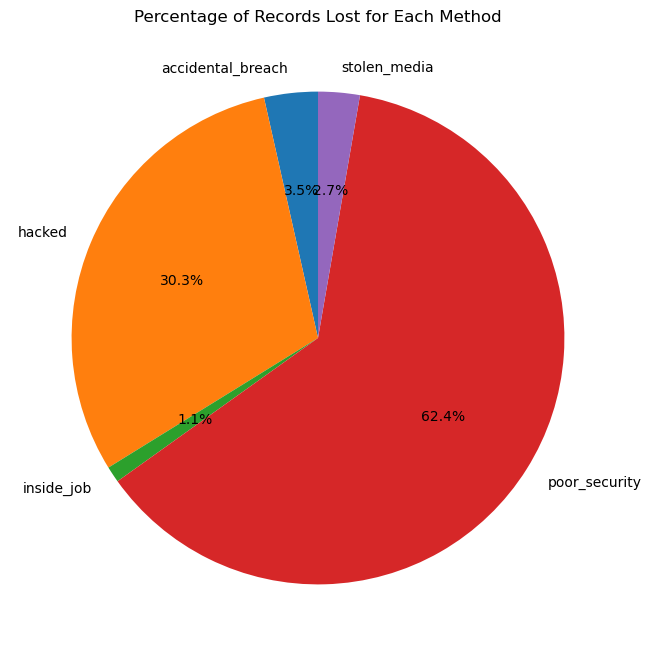

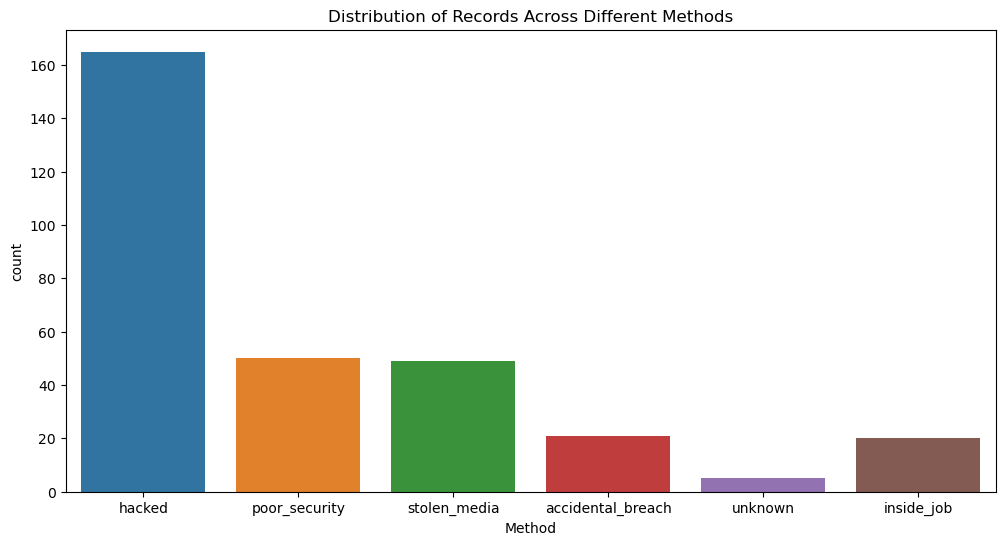

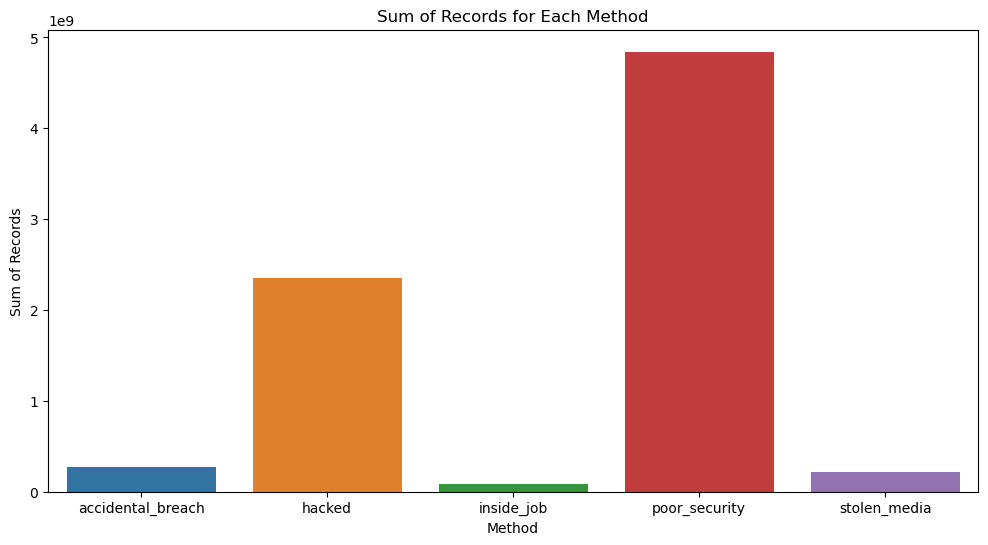

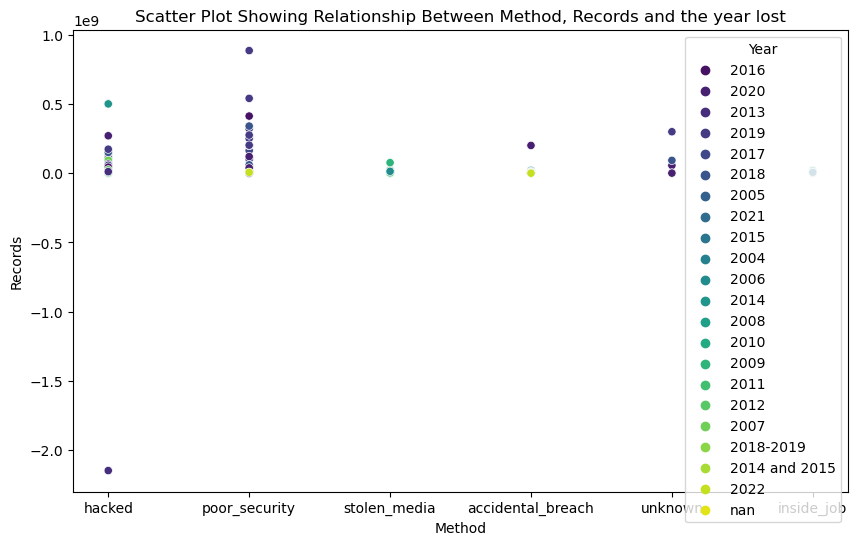

In [28]:
# Calculate the sum of records for each method (excluding "unknown")
method_records = df_vis[df_vis['Method'] != 'unknown'].groupby('Method')['Records'].sum()

# Calculate the total sum of records (excluding "unknown")
total_records = method_records.sum()

# Calculate the percentage of records lost for each method (excluding "unknown")
method_percentages = (method_records / total_records) * 100

# Print out the percentages
print("Percentage of records lost for each method:")
print(method_percentages)   # this will give us the ratio of how data was lost in the past, hacked and poor_security being the most prominent

# Plot a pie chart using matplotlib
plt.figure(figsize=(8, 8))
plt.pie(method_percentages, labels=method_percentages.index, autopct='%1.1f%%', startangle=90)
plt.title("Percentage of Records Lost for Each Method")
plt.savefig('visualization_graphs/initial_pie_chart.png')
plt.show()

# Additional seaborn plots
# Example 1: Countplot to show the distribution of records across different methods
plt.figure(figsize=(12, 6))
sns.countplot(data=df_vis, x='Method')
plt.title("Distribution of Records Across Different Methods")
plt.savefig('visualization_graphs/distribution_bar_graph.png')
plt.show()

# Example 2: Barplot to show the sum of records for each method
plt.figure(figsize=(12, 6))
sns.barplot(x=method_records.index, y=method_records.values)
plt.title("Sum of Records for Each Method")
plt.ylabel("Sum of Records")
plt.savefig('visualization_graphs/sum_bar_graph.png')
plt.show()

# Example 3: Scatter plot to show the relationship between two numerical columns
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_vis, x='Method', y='Records', hue='Year', palette='viridis')
plt.title("Scatter Plot Showing Relationship Between Method, Records and the year lost")
plt.savefig('visualization_graphs/scatter_plot.png')  # leave the rest of the settings as default
plt.show()

In [29]:
df_class = df_vis.copy()  # create another copy of the dataframe and save it in df_class
#rename unknown columns to poor_security --> since that is the predominant method of data loss
df_class['Method'] = df_class['Method'].replace({'unknown': 'poor_security'})
df_class['Method'] = df_class['Method'].replace({'accidental_breach': 'poor_security', 'inside_job': 'hacked', 'stolen_media': 'poor_security'})  # in this case, we will replace accidential_breach with poor_security, inside_job with hacked and stolen_media with poor_security as well
print("Classification Label Values: ", df_class['Method'].unique())  # observe that unknown has been removed from the tuple generated

print("Regression Label Values: ", df_vis['Method'].unique())  # in this case, we will need to  drop nan values and apply label encoding on this
print("Regression Second Label Values: ", df_vis['Organization_type'].unique())  # in this case, we will also have to apply label encoding for this
# Calculate the sum of records for the "unknown" method
unknown_records = df_vis[df_vis['Method'] == 'unknown']['Records'].sum()

# Calculate the total sum of records
total_records = df_vis['Records'].sum()

# Calculate the percentage of "unknown" method records lost
unknown_percentage = (unknown_records / total_records) * 100

# Print the percentage
print("Percentage of 'unknown' method records lost: ", unknown_percentage)   # the percentage of unknown method lost is around 5.2%

df_vis['Method'] = df_vis['Method'].replace('unknown', 'poor_security')   # replace the unknwon values with poor security on df_vis as well
list(df_vis['Method'].unique())  # now all we have remaining for 
df_vis

Classification Label Values:  ['hacked' 'poor_security' nan]
Regression Label Values:  ['hacked' 'poor_security' 'stolen_media' 'accidental_breach' 'unknown'
 'inside_job' nan]
Regression Second Label Values:  ['healthcare' 'social_networking' 'tech' 'advertising'
 'telecommunications' 'transport' 'financial' 'web' 'gaming' 'tech_retail'
 'telecoms' 'retail' 'educational_services' 'banking' 'government' 'game'
 'energy' 'background_check' 'hosting_provider' 'health' 'messaging_app'
 'restaurant' 'financial_credit_reporting' 'data_broker' 'social_network'
 'financial_service_company'
 'personal_and_demographic_data_about_residents_and_their_properties_of_US'
 'hotel' 'humanitarian' 'special_public_corporation' 'shopping'
 'local_search' 'academic' 'mobile_carrier' 'publisher_(magazine)'
 'government_healthcare' 'web_military' 'online_shopping' 'genealogy'
 'media' 'QR_code_payment' 'fashion' 'Clinical_Laboratory'
 'Question_&_Answer' 'web_gaming' 'government_database'
 'phone_accessorie

,Entity,Year,Records,Organization type,Method,hashed_Entity,Organization_type
0,21st_Century_Oncology,2016,2200000.0,healthcare,hacked,c3a872f67b2c21449ed696e019d008cbb15b384ed63164...,healthcare
1,500px,2020,14870304.0,social_networking,hacked,39b1d7f5c52ecec4511c7d93214a3dc33915fcb67c51e1...,social_networking
2,Accendo_Insurance_Co.,2020,175350.0,healthcare,poor_security,d37b82c7c3fef3eb56a05bc88697bd64c489f8b13b9ed8...,healthcare
3,Adobe,2013,152000000.0,tech,hacked,4ea8e5179ec6c6866f040ebfa23a41946cb05bd37b5ebc...,tech
4,Adobe,2019,7500000.0,tech,poor_security,4e2eb72d6ffd4a841309dcd87b646d2408ac7394956117...,tech
...,...,...,...,...,...,...,...
314,US_Medicaid,2012,390000.0,government,hacked,d847ab7f37010ebde8ba528d33a835a3ec62fba70150da...,government_healthcare
315,Tricare,2011,2450716.0,military,stolen_media,9059519abb746a47cca0da7e09996332d7c70fc7c8f2cd...,military_healthcare
316,U.S._Department_of_Veteran_Affairs,2006,13250000.0,government,stolen_media,31f6043d57ee9ad83195aa021ce2140a8622198eb983f5...,government_military
317,Virginia_Department_of_Health,2009,4128689.0,government,hacked,ac018447619fc35393e91eba10be6777c090ac9d051f28...,government_healthcare


In [30]:
# drop the nan values
df_class.dropna(inplace=True)
df_vis.dropna(inplace=True)
df_vis.drop(labels=['Organization type', 'hashed_Entity'], axis=1, inplace=True)  # we can now check and see that df_vis and df_class both had Organization type and hashed_entity removed, we will also need to apply label encoding on Organization_type and Entity as we have simplified and cleaned them up
df_class.drop(labels=['Organization type', 'hashed_Entity'], axis=1, inplace=True)

print("Classification label values: ", df_class['Method'].unique())  # now we have binary classification label
print("Regression label values: ", df_vis['Method'].unique())
print("\nSecond Regression label values: ", df_vis['Organization_type'].unique())  # as we can see, no nan values are present within the dataframe
print("\n The unique companies are: ", df_vis['Entity'].unique())
df_vis # we have two redundant columns --> Organization_type and Organization type, one of them needs to be dropped alongside hashed_entity

Classification label values:  ['hacked' 'poor_security']
Regression label values:  ['hacked' 'poor_security' 'stolen_media' 'accidental_breach' 'inside_job']

Second Regression label values:  ['healthcare' 'social_networking' 'tech' 'advertising'
 'telecommunications' 'transport' 'gaming' 'tech_retail' 'telecoms'
 'retail' 'educational_services' 'banking' 'government' 'game' 'energy'
 'background_check' 'hosting_provider' 'health' 'messaging_app'
 'restaurant' 'financial_credit_reporting' 'data_broker' 'social_network'
 'financial_service_company'
 'personal_and_demographic_data_about_residents_and_their_properties_of_US'
 'hotel' 'humanitarian' 'special_public_corporation' 'shopping'
 'local_search' 'academic' 'mobile_carrier' 'publisher_(magazine)'
 'government_healthcare' 'web_military' 'online_shopping' 'genealogy'
 'media' 'QR_code_payment' 'fashion' 'Clinical_Laboratory'
 'Question_&_Answer' 'web_gaming' 'government_database'
 'phone_accessories' 'web_tech' 'military' 'market_ana

,Entity,Year,Records,Method,Organization_type
0,21st_Century_Oncology,2016,2200000.0,hacked,healthcare
1,500px,2020,14870304.0,hacked,social_networking
2,Accendo_Insurance_Co.,2020,175350.0,poor_security,healthcare
3,Adobe,2013,152000000.0,hacked,tech
4,Adobe,2019,7500000.0,poor_security,tech
...,...,...,...,...,...
314,US_Medicaid,2012,390000.0,hacked,government_healthcare
315,Tricare,2011,2450716.0,stolen_media,military_healthcare
316,U.S._Department_of_Veteran_Affairs,2006,13250000.0,stolen_media,government_military
317,Virginia_Department_of_Health,2009,4128689.0,hacked,government_healthcare


<h1>Data Visualization 📈📊 🍕👻👾🍟
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣤⣤⣄⣀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢀⣀⠀⠀⣿⣿⣿⣿⣿⣶⣤⡀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⣀⣴⣶⣿⣿⣿⣿⣿⠀⠀⣿⣿⣿⣿⣿⣿⣿⣿⣦⡀⠀⠀⠀
⠀⠀⠀⠀⢀⣤⣾⣿⣿⣿⣿⣿⣿⣿⣿⠀⢀⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡄⠀⠀
⠀⠀⠀⢠⣾⣿⣿⣿⣿⣿⣿⣿⣿⣿⡟⠀⢸⣿⣿⣿⣿⣿⣿⣿⣿⣿⡿⠿⠀⠀
⠀⠀⢠⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡇⠀⢸⣿⣿⣿⣿⠿⠟⠛⠉⠁⠀⠀⠀⠀
⠀⠀⣾⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡇⠀⠸⠛⠋⠁⠀⣀⣠⣴⣶⣿⣇⠀⠀⠀
⠀⢰⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡇⠀⣀⣠⣴⣶⣿⣿⣿⣿⣿⣿⣿⠀⠀⠀
⠀⢸⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⠀⠀⠀
⠀⠈⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡿⠀⠀⠀
⠀⠀⠹⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⠃⠀⠀⠀
⠀⠀⠀⠹⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⠏⠀⠀⠀⠀
⠀⠀⠀⠀⠘⢿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡿⠃⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠉⠻⢿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡿⠛⠁⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠉⠛⠛⠛⠛⠛⠛⠋⠉⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
</h1>

In [31]:
!pip install colorspacious

In [32]:
from colorspacious import cspace_converter
from matplotlib import colormaps
import matplotlib as mpl

#cmaps = {}
gradient = np.linspace(0,1,256)
gradient = np.vstack((gradient, gradient))

custom_cmaps = ['magma', 'inferno', 'twilight_shifted', 'PRGn', 'turbo']

list(colormaps)

['magma',
 'inferno',
 'plasma',
 'viridis',
 'cividis',
 'twilight',
 'twilight_shifted',
 'turbo',
 'Blues',
 'BrBG',
 'BuGn',
 'BuPu',
 'CMRmap',
 'GnBu',
 'Greens',
 'Greys',
 'OrRd',
 'Oranges',
 'PRGn',
 'PiYG',
 'PuBu',
 'PuBuGn',
 'PuOr',
 'PuRd',
 'Purples',
 'RdBu',
 'RdGy',
 'RdPu',
 'RdYlBu',
 'RdYlGn',
 'Reds',
 'Spectral',
 'Wistia',
 'YlGn',
 'YlGnBu',
 'YlOrBr',
 'YlOrRd',
 'afmhot',
 'autumn',
 'binary',
 'bone',
 'brg',
 'bwr',
 'cool',
 'coolwarm',
 'copper',
 'cubehelix',
 'flag',
 'gist_earth',
 'gist_gray',
 'gist_heat',
 'gist_ncar',
 'gist_rainbow',
 'gist_stern',
 'gist_yarg',
 'gnuplot',
 'gnuplot2',
 'gray',
 'hot',
 'hsv',
 'jet',
 'nipy_spectral',
 'ocean',
 'pink',
 'prism',
 'rainbow',
 'seismic',
 'spring',
 'summer',
 'terrain',
 'winter',
 'Accent',
 'Dark2',
 'Paired',
 'Pastel1',
 'Pastel2',
 'Set1',
 'Set2',
 'Set3',
 'tab10',
 'tab20',
 'tab20b',
 'tab20c',
 'magma_r',
 'inferno_r',
 'plasma_r',
 'viridis_r',
 'cividis_r',
 'twilight_r',
 'twilight

Before replacement:
['2016' '2020' '2013' '2019' '2017' '2018' '2021' '2015' '2008' '2010'
 '2009' '2014' '2011' '2012' '2007' '2005' '2018-2019' '2006'
 '2014 and 2015' '2022' '2004']
['2016' '2020' '2013' '2019' '2017' '2018' '2021' '2015' '2008' '2010'
 '2009' '2014' '2011' '2012' '2007' '2005' '2018-2019' '2006'
 '2014 and 2015' '2022' '2004']

After Replacement:
['2016' '2020' '2013' '2019' '2017' '2018' '2021' '2015' '2008' '2010'
 '2009' '2014' '2011' '2012' '2007' '2005' '2006' '2022' '2004']
['2016' '2020' '2013' '2019' '2017' '2018' '2021' '2015' '2008' '2010'
 '2009' '2014' '2011' '2012' '2007' '2005' '2006' '2022' '2004']

Current datatypes:

Entity                object
Year                   int32
Records              float64
Method                object
Organization_type     object
dtype: object 

Entity                object
Year                   int32
Records              float64
Method                object
Organization_type     object
dtype: object


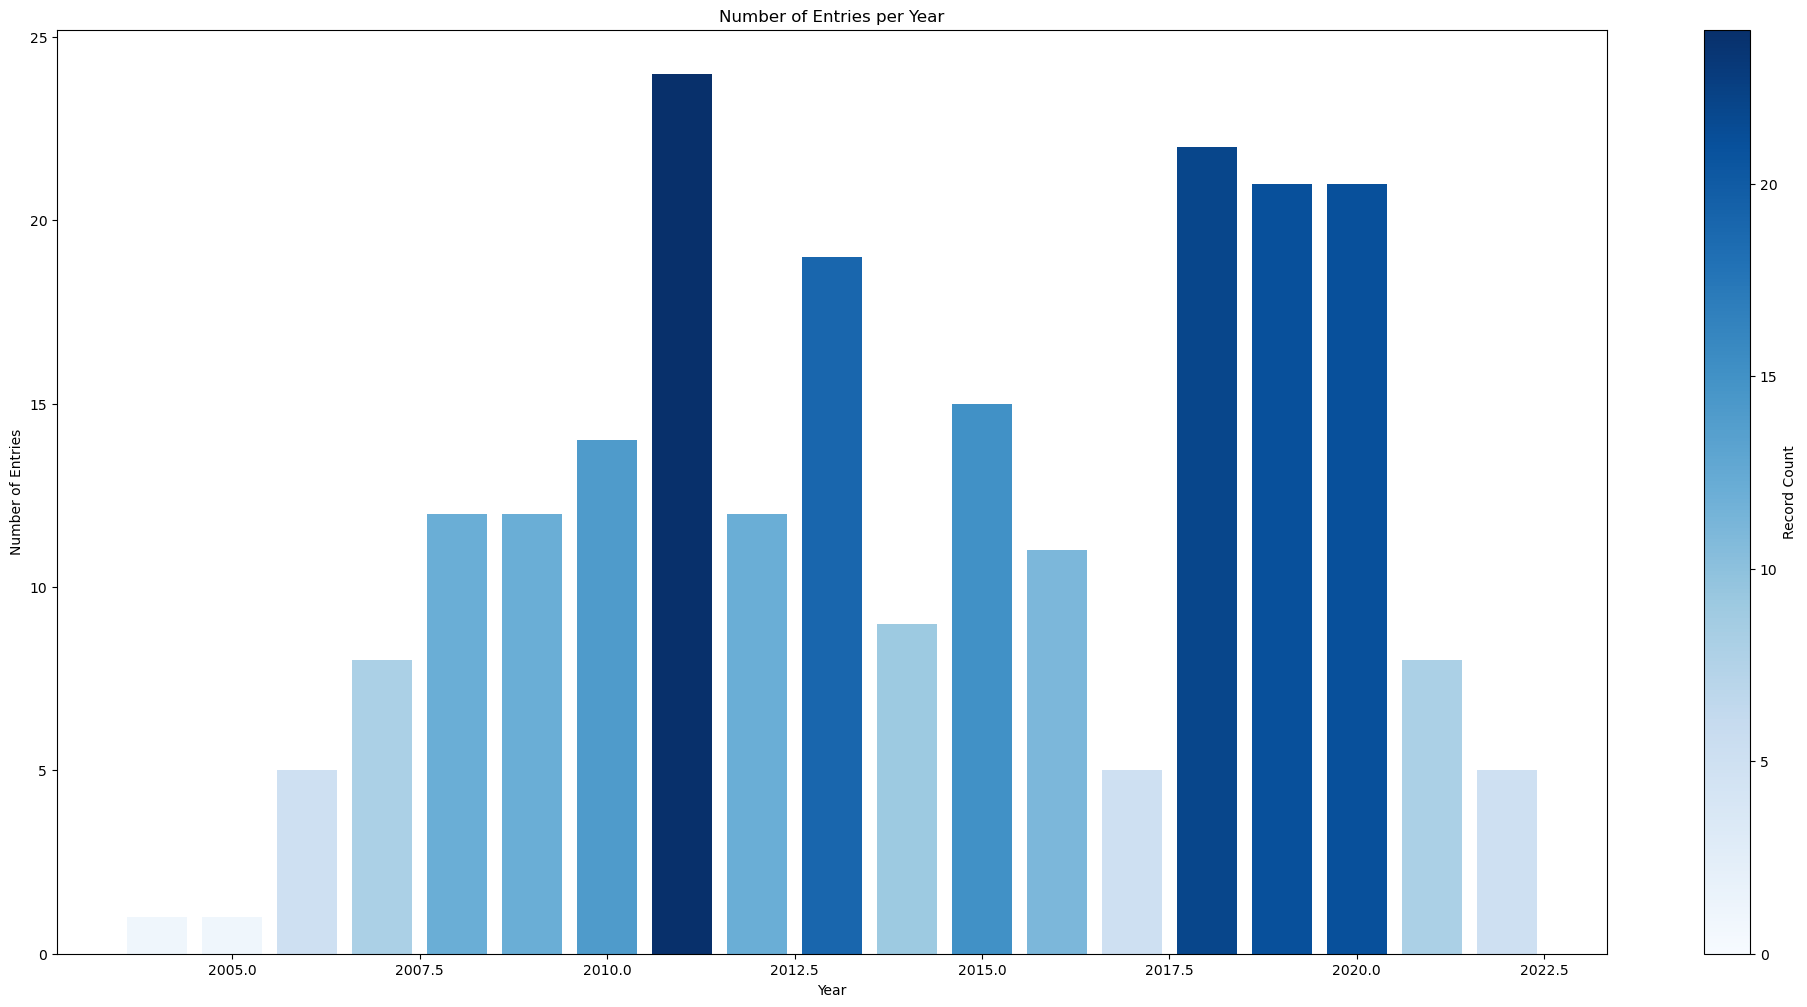

In [33]:
# convert the years to ints
#df_vis['Year'] = df_vis['Year'].astype(int)
#df_class['Year'] = df_class['Year'].astype(int)

print("Before replacement:")
print(df_vis['Year'].unique())
print(df_class['Year'].unique())
#we will need to replace the instances of 2018-2019 with 2018 alone and all instances of 2014 to 2015 with 2015 alone
df_vis['Year'] = df_vis['Year'].replace({'2018-2019': '2018', '2014 and 2015':'2015'})
df_class['Year'] = df_class['Year'].replace({'2018-2019':'2018', '2014 and 2015':'2014'})

print("\nAfter Replacement:")
print(df_vis['Year'].unique())  # now we have uniformity of years without outlier values
print(df_class['Year'].unique())

# perform typecast on the dataframe
df_vis['Year'] = df_vis['Year'].astype(int)
df_class['Year'] = df_class['Year'].astype(int)

#observe the datatype of the dataframe
print("\nCurrent datatypes:\n")
print(df_vis.dtypes, "\n")
print(df_class.dtypes)

#grouping data by year
grouped_data = df_vis.groupby('Year').size()
grouped_data2 = df_class.groupby('Year').size()

#sorting the group data by the year
grouped_data = grouped_data.sort_index()
grouped_data2 = grouped_data2.sort_index()

# convert the years to whole numbers
grouped_data.index = grouped_data.index.astype(int)
grouped_data2.index = grouped_data2.astype(int)

# creating a barplot with figsize 
fig, ax = plt.subplots(figsize=(25,12))

# use the colormap to create gradient effect
norm = plt.Normalize(0, grouped_data.max()) # get the max value of the group data and we are passing in the parameters 0 and the maxiimum value we got from grouped_data upon soring it
# norm2 = plt.normalize(0, grouped_data2.max()) 

colors1 = plt.cm.twilight(norm(grouped_data.values))  # initially Reds, but modified to be other values
colors2 = plt.cm.magma(norm(grouped_data.values))  # second option to test out
colors3 = plt.cm.viridis(norm(grouped_data.values))
colors3 = plt.cm.Blues(norm(grouped_data.values))
#colors2 = plt.cm.Reds(norm(grouped_data2.values))

bars = ax.bar(grouped_data.index, grouped_data.values, color=colors3) #initialize the colors to the color we created above, this will determine the color of the bars
#bars = ax.bar(grouped_data2.index, grouped_data2.values, color=custom_cmaps)

#adding labels and titles
ax.set_xlabel('Year')
ax.set_ylabel('Number of Entries')
ax.set_title('Number of Entries per Year')

# add a colorbar and show the scale, note that it needs to match the bars value color parameter value
char = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap='Blues'), ax=ax, orientation='vertical')  # this will determine the colorbar we are working with
char.set_label('Record Count')

#make the background transparent --> commented out because it's hard to make out the detauls in the png
#fig.patch.set_alpha(0.0)
#ax.patch.set_alpha(0.0)

# save the plot with a transparent background
plt.savefig('visualization_graphs/entries.png', bbox_inches='tight', pad_inches=0.1)

#display the plot
plt.show()

#adding

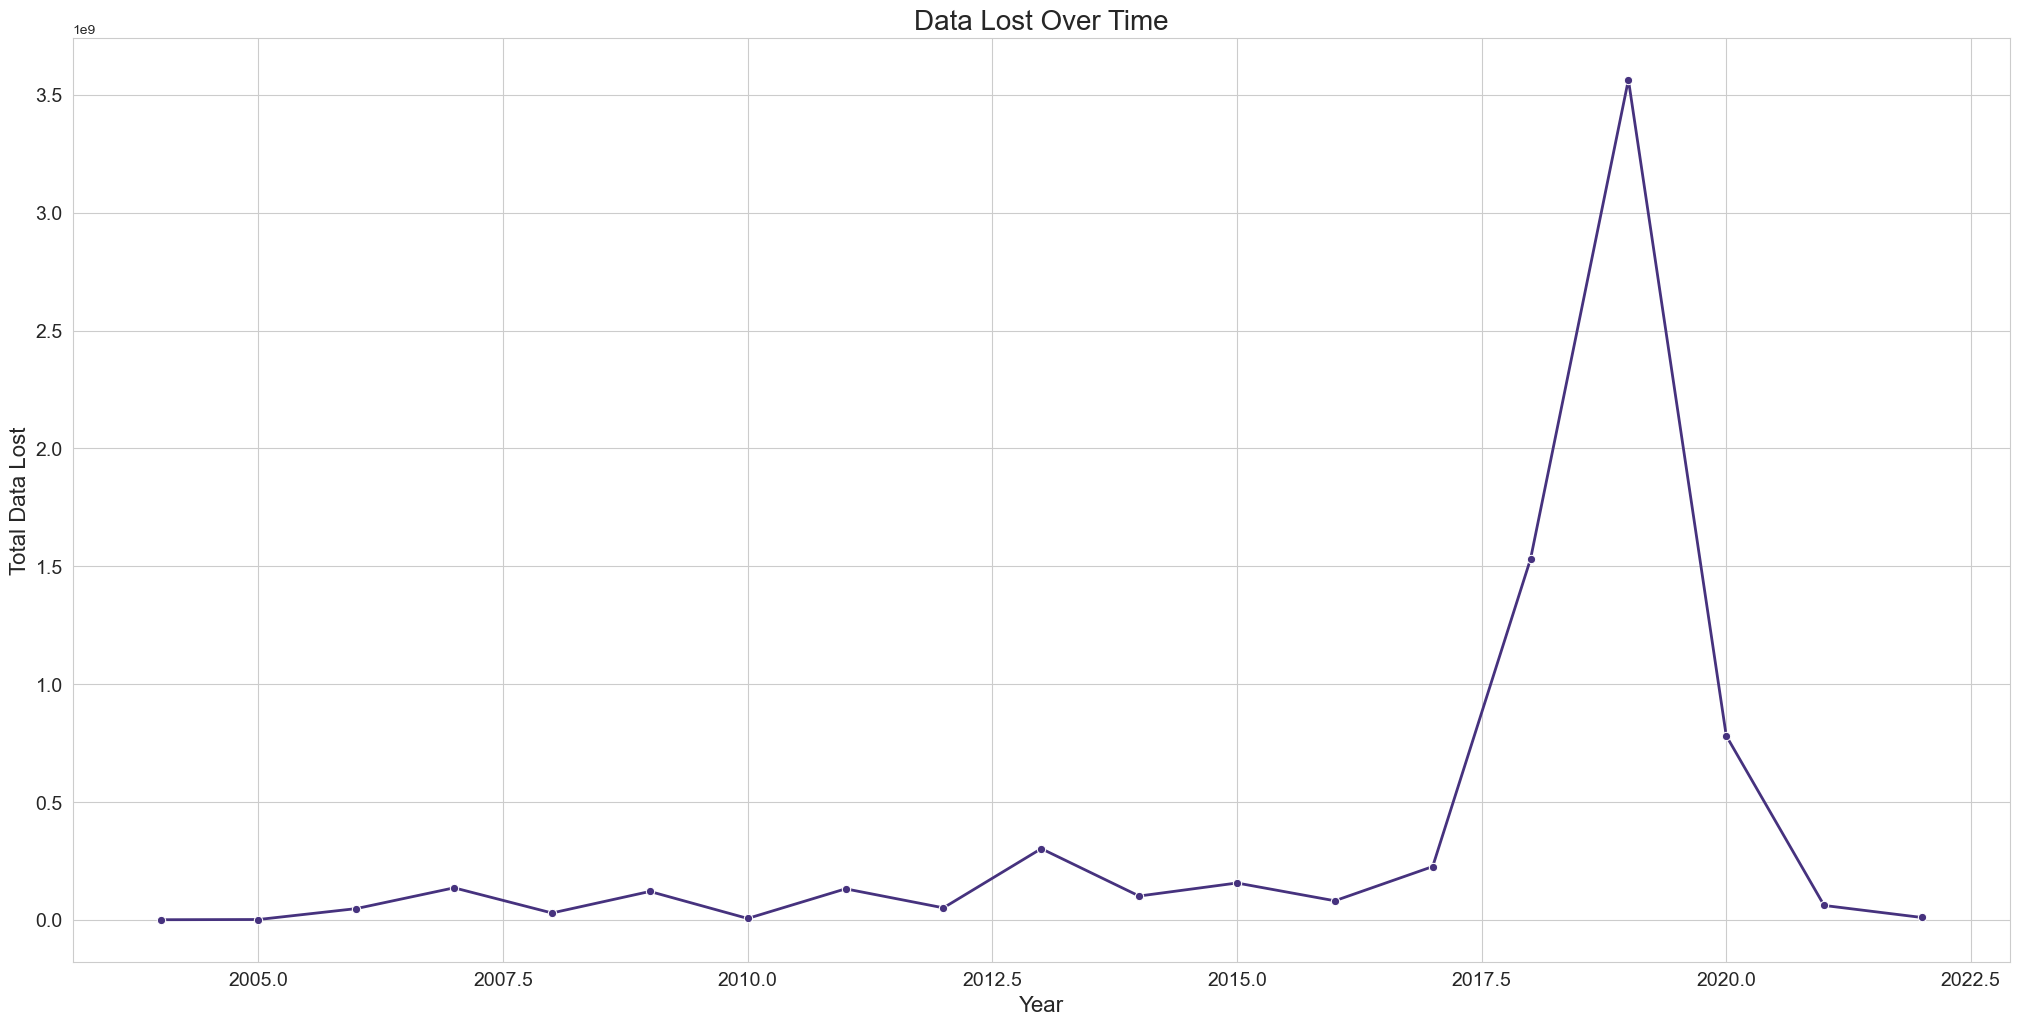

In [34]:
import seaborn as sns

# Set a custom seaborn style
sns.set_style("whitegrid")
sns.set_palette("viridis")

# Group the data by the year and sum the records of each year
data_lost_over_time = df_vis.groupby('Year')['Records'].sum()

# Convert the years to whole numbers
data_lost_over_time.index = data_lost_over_time.index.astype(int)

# Create a line plot using seaborn
plt.figure(figsize=(25, 12))
sns.lineplot(x=data_lost_over_time.index, y=data_lost_over_time.values, marker='o', linewidth=2)

# Additional components for better visuals
plt.title("Data Lost Over Time", fontsize=20)
plt.xlabel("Year", fontsize=16)
plt.ylabel("Total Data Lost", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Save the plot as 'records_line_plot.png' in the visualization_graphs directory
plt.savefig('visualization_graphs/records_line_plot.png', bbox_inches='tight', pad_inches=0.1)

# Show the graph
plt.show()


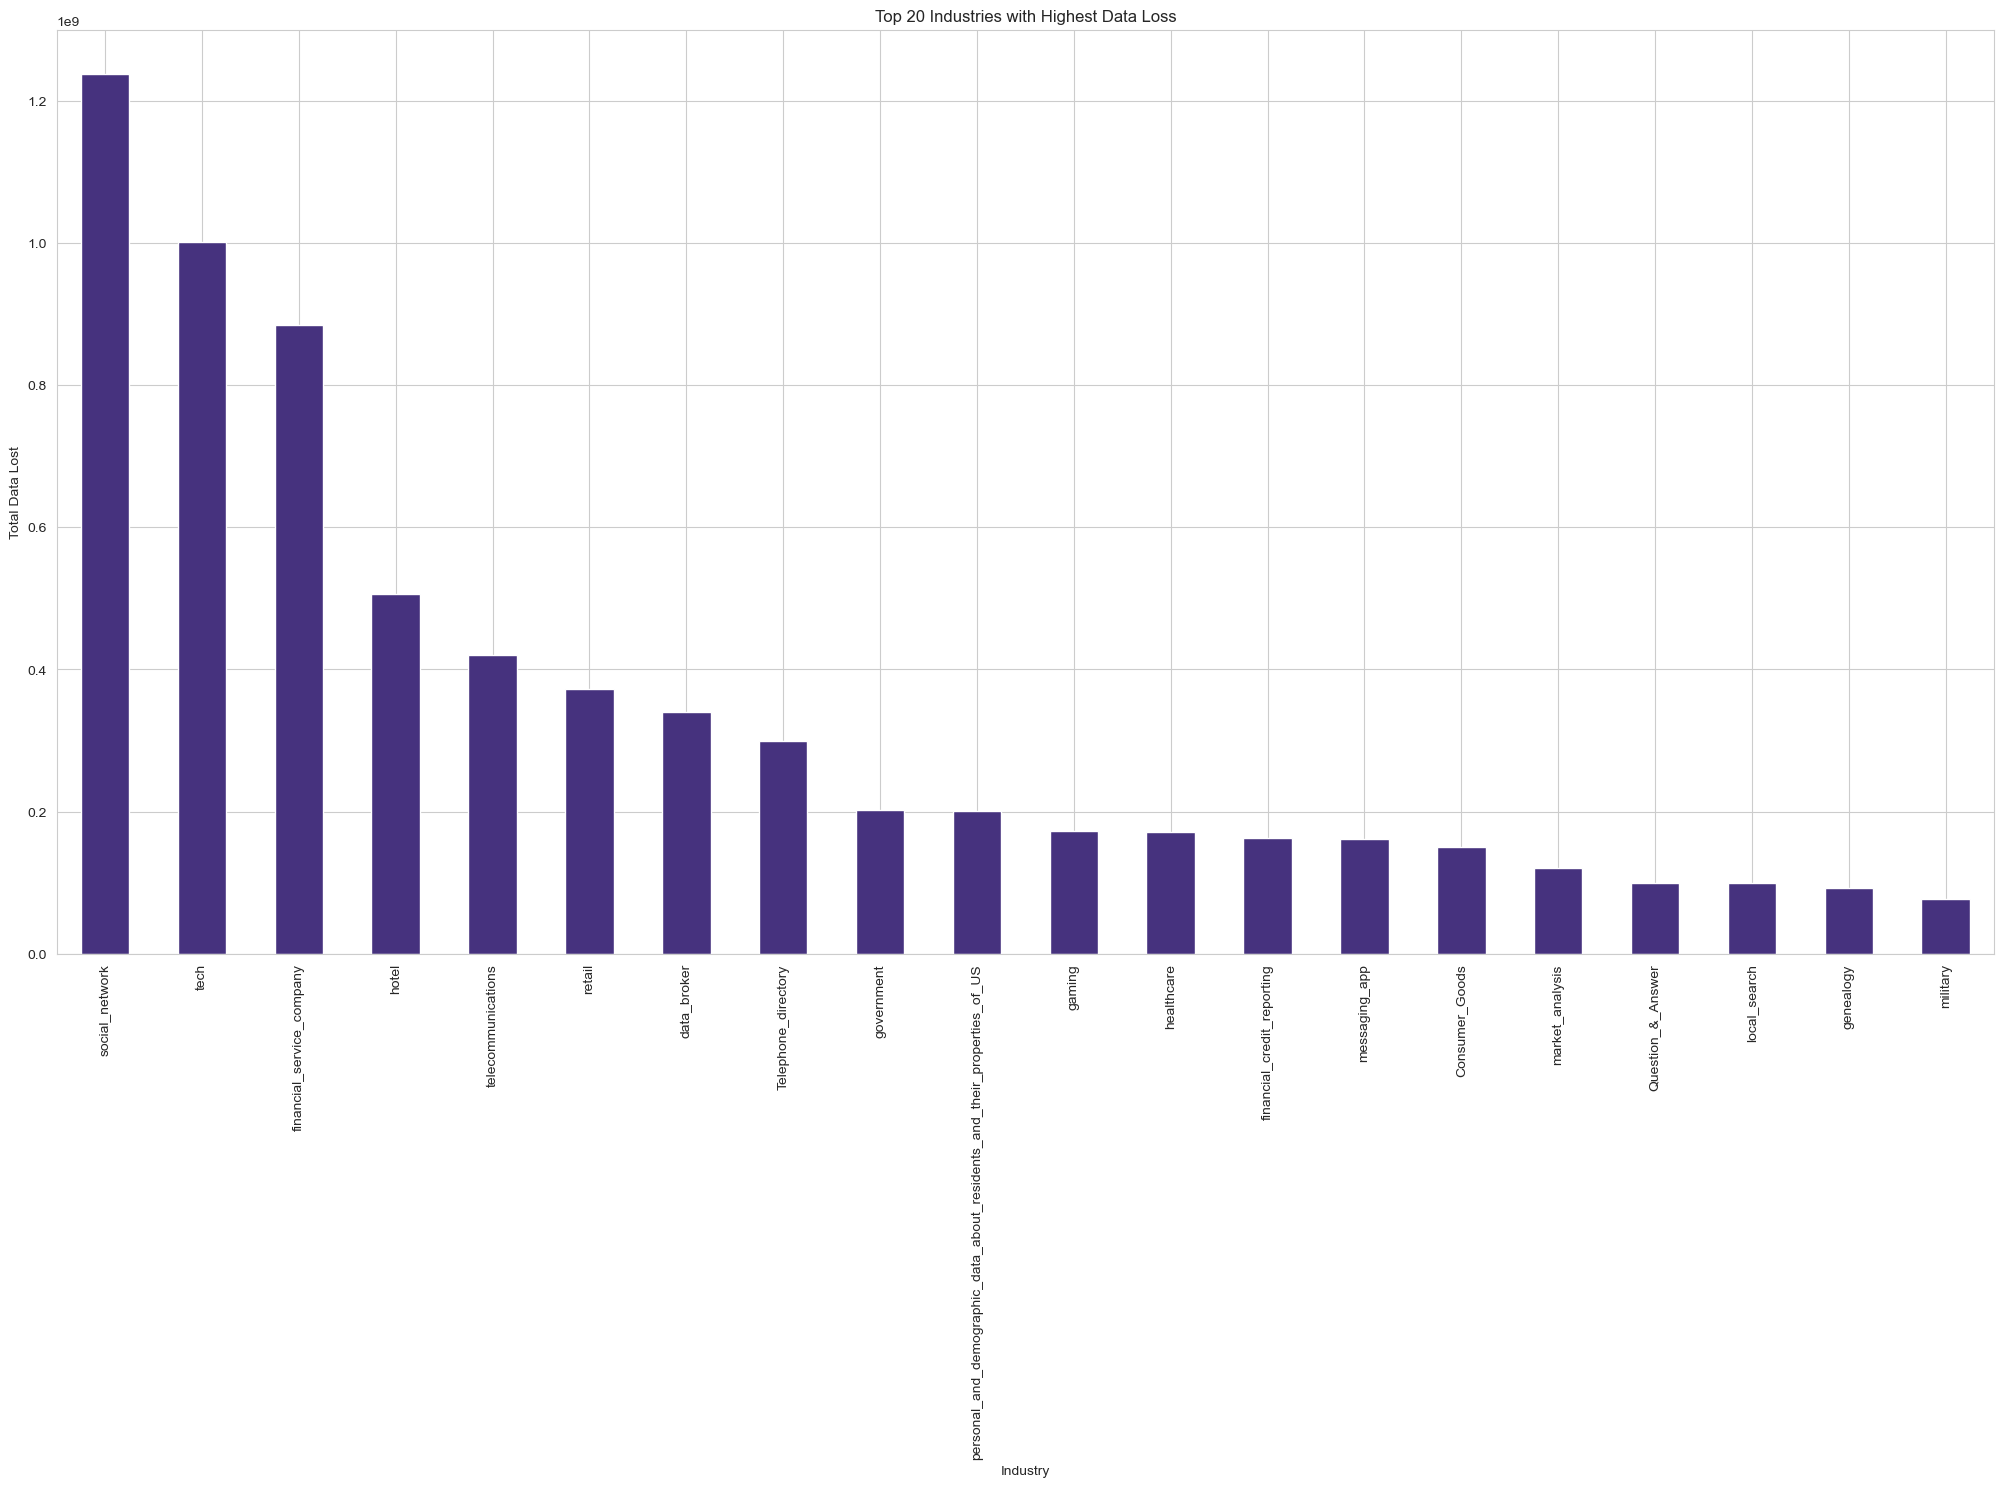

In [35]:


# Group the data by industry and sum the records for each industry, then select the top 20 industries
top_20_industries = df_vis.groupby('Organization_type')['Records'].sum().nlargest(20)

# Create a bar plot for the top 10 industries with the highest data loss
top_20_industries.plot(kind='bar', figsize=(25, 12))
plt.title("Top 20 Industries with Highest Data Loss")
plt.xlabel("Industry")
plt.ylabel("Total Data Lost")
plt.xticks(rotation=90)

plt.savefig('visualization_graphs/Top_20_industries')
plt.show()

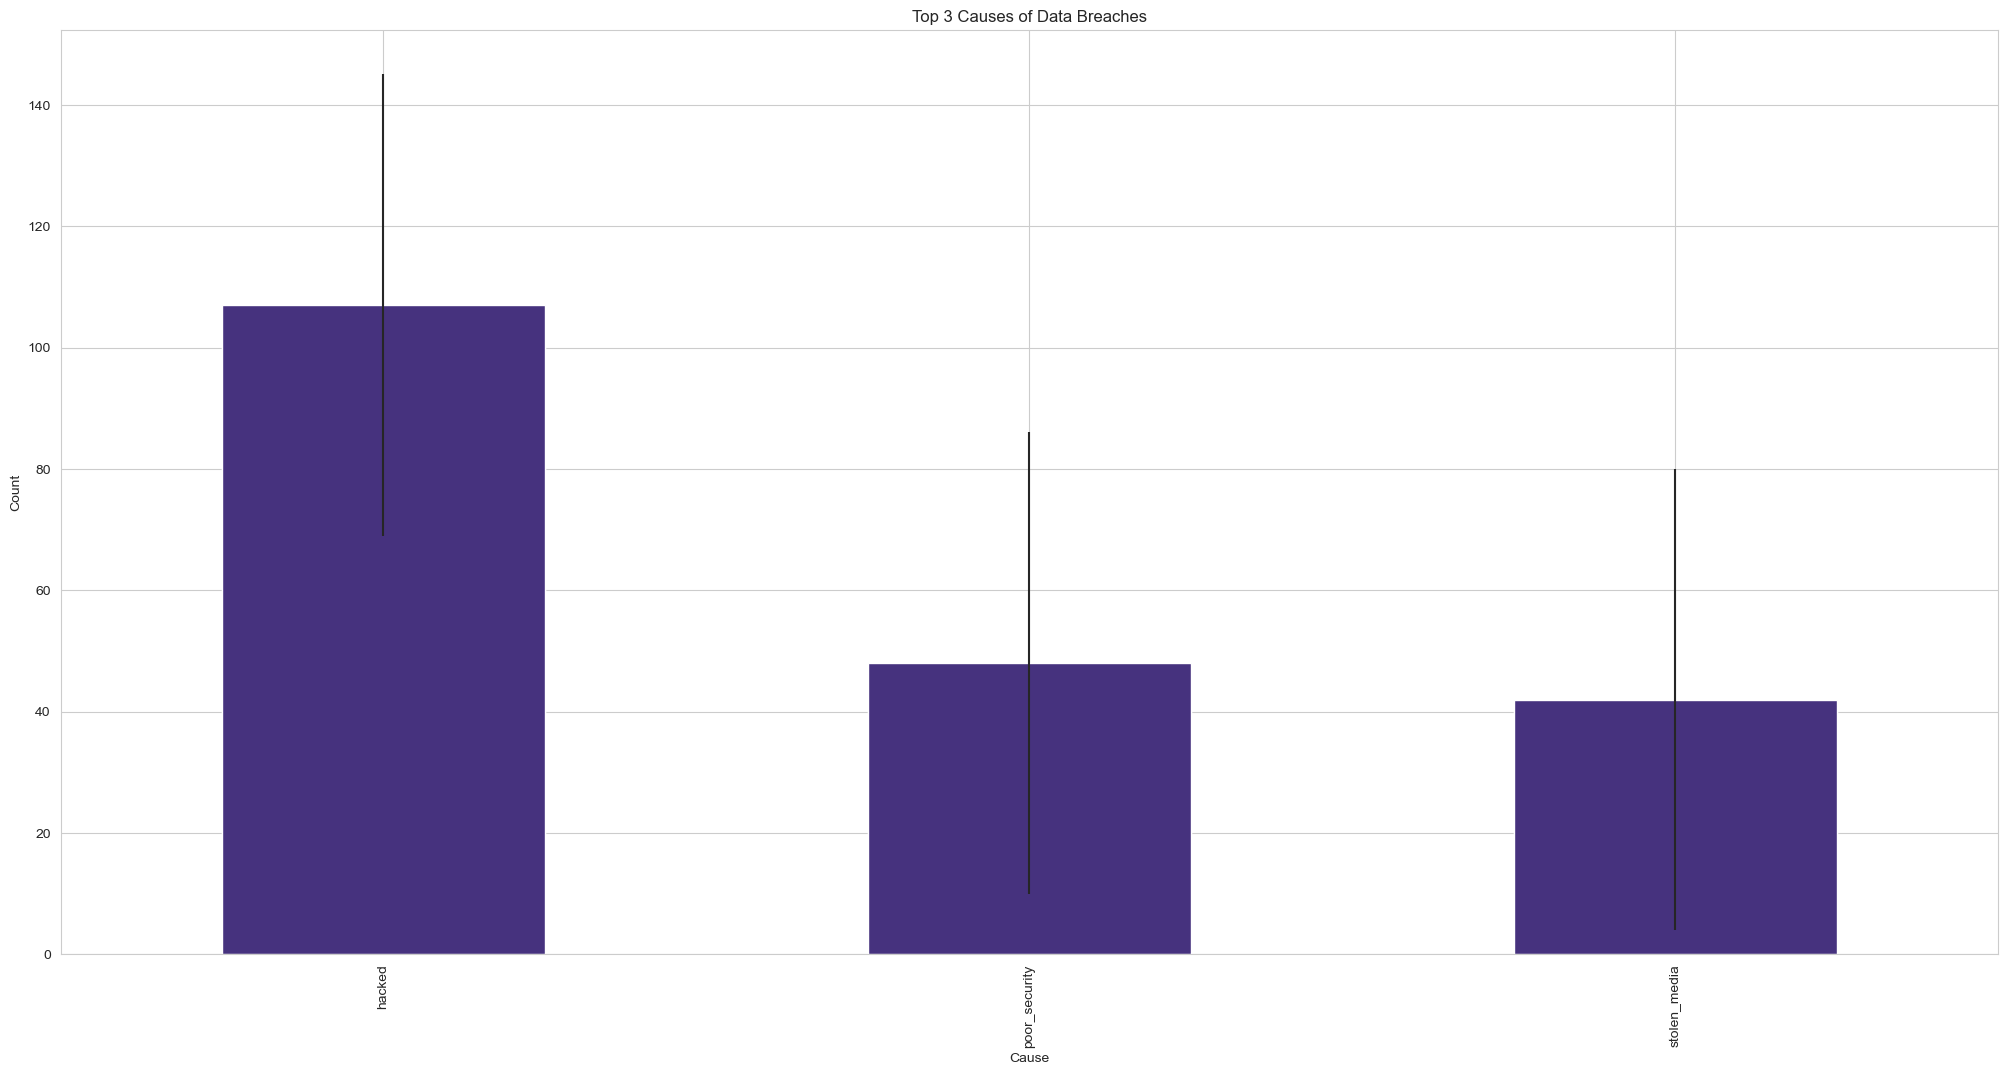

In [36]:
# Group the data by the method and count the occurrences, then select the top 10 causes
top_3_causes = df_vis['Method'].value_counts().nlargest(3)

# Create a bar plot for the top 10 causes of data breaches
top_3_causes.plot(kind='bar', figsize=(25, 12))
plt.title("Top 3 Causes of Data Breaches")
plt.xlabel("Cause")
plt.ylabel("Count")
plt.xticks(rotation=90)
top_3_causes.plot(kind='bar', figsize=(25, 12), yerr=df_vis['Method'].value_counts().std())
plt.savefig('visualization_graphs/top_3_causes.png')
plt.show()

#note: instead of showing the top 10 causes (since we don't really have 10 unique values in method section to begin with), it would be for the best if we were to simply display the top 3 causes instead

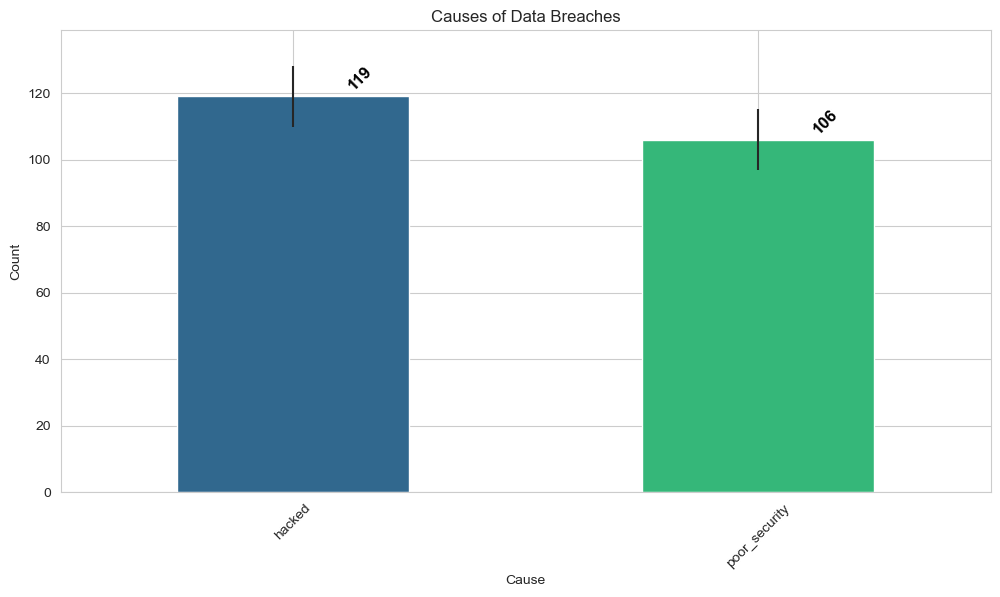

In [37]:
top_causes = df_class['Method'].value_counts()

# Set up a color palette with a unique color for each bar
colors = sns.color_palette('viridis', len(top_causes))
top_limit = top_causes.max() + 20
plt.ylim(bottom=0, top = top_limit)
# Create a bar plot for the causes of data breaches
top_causes.plot(kind='bar', figsize=(12, 6), color=colors, yerr=df_class['Method'].value_counts().std())
plt.title("Causes of Data Breaches")
plt.xlabel("Cause")
plt.ylabel("Count")
plt.xticks(rotation=45)

# Add labels to each bar containing the count of entries for each cause. offset the labels to the right by 0.1
for index, value in enumerate(top_causes):
    plt.text(index + 0.145, value + 1, str(value), ha='center', va='bottom' , rotation=45, fontweight='bold', color='black', fontsize=12)  # this value is used to display the y-value of each corresponding bar graph


#save the plot as "breachcauses.png" in the directory called graphs
plt.savefig('visualization_graphs/breachcauses.png', bbox_inches='tight')
plt.show()

When we calculate the error bars there's an upper and lower bound, the upper bound is the mean + the standard deviation. The lower bound is the mean - the standard deviation. So, drawing a line through the lower bound, and it doesn't mean that the difference is statistically significant.

We may want to exclude the data that is statistically significant, because it is likely that it is an outlier.

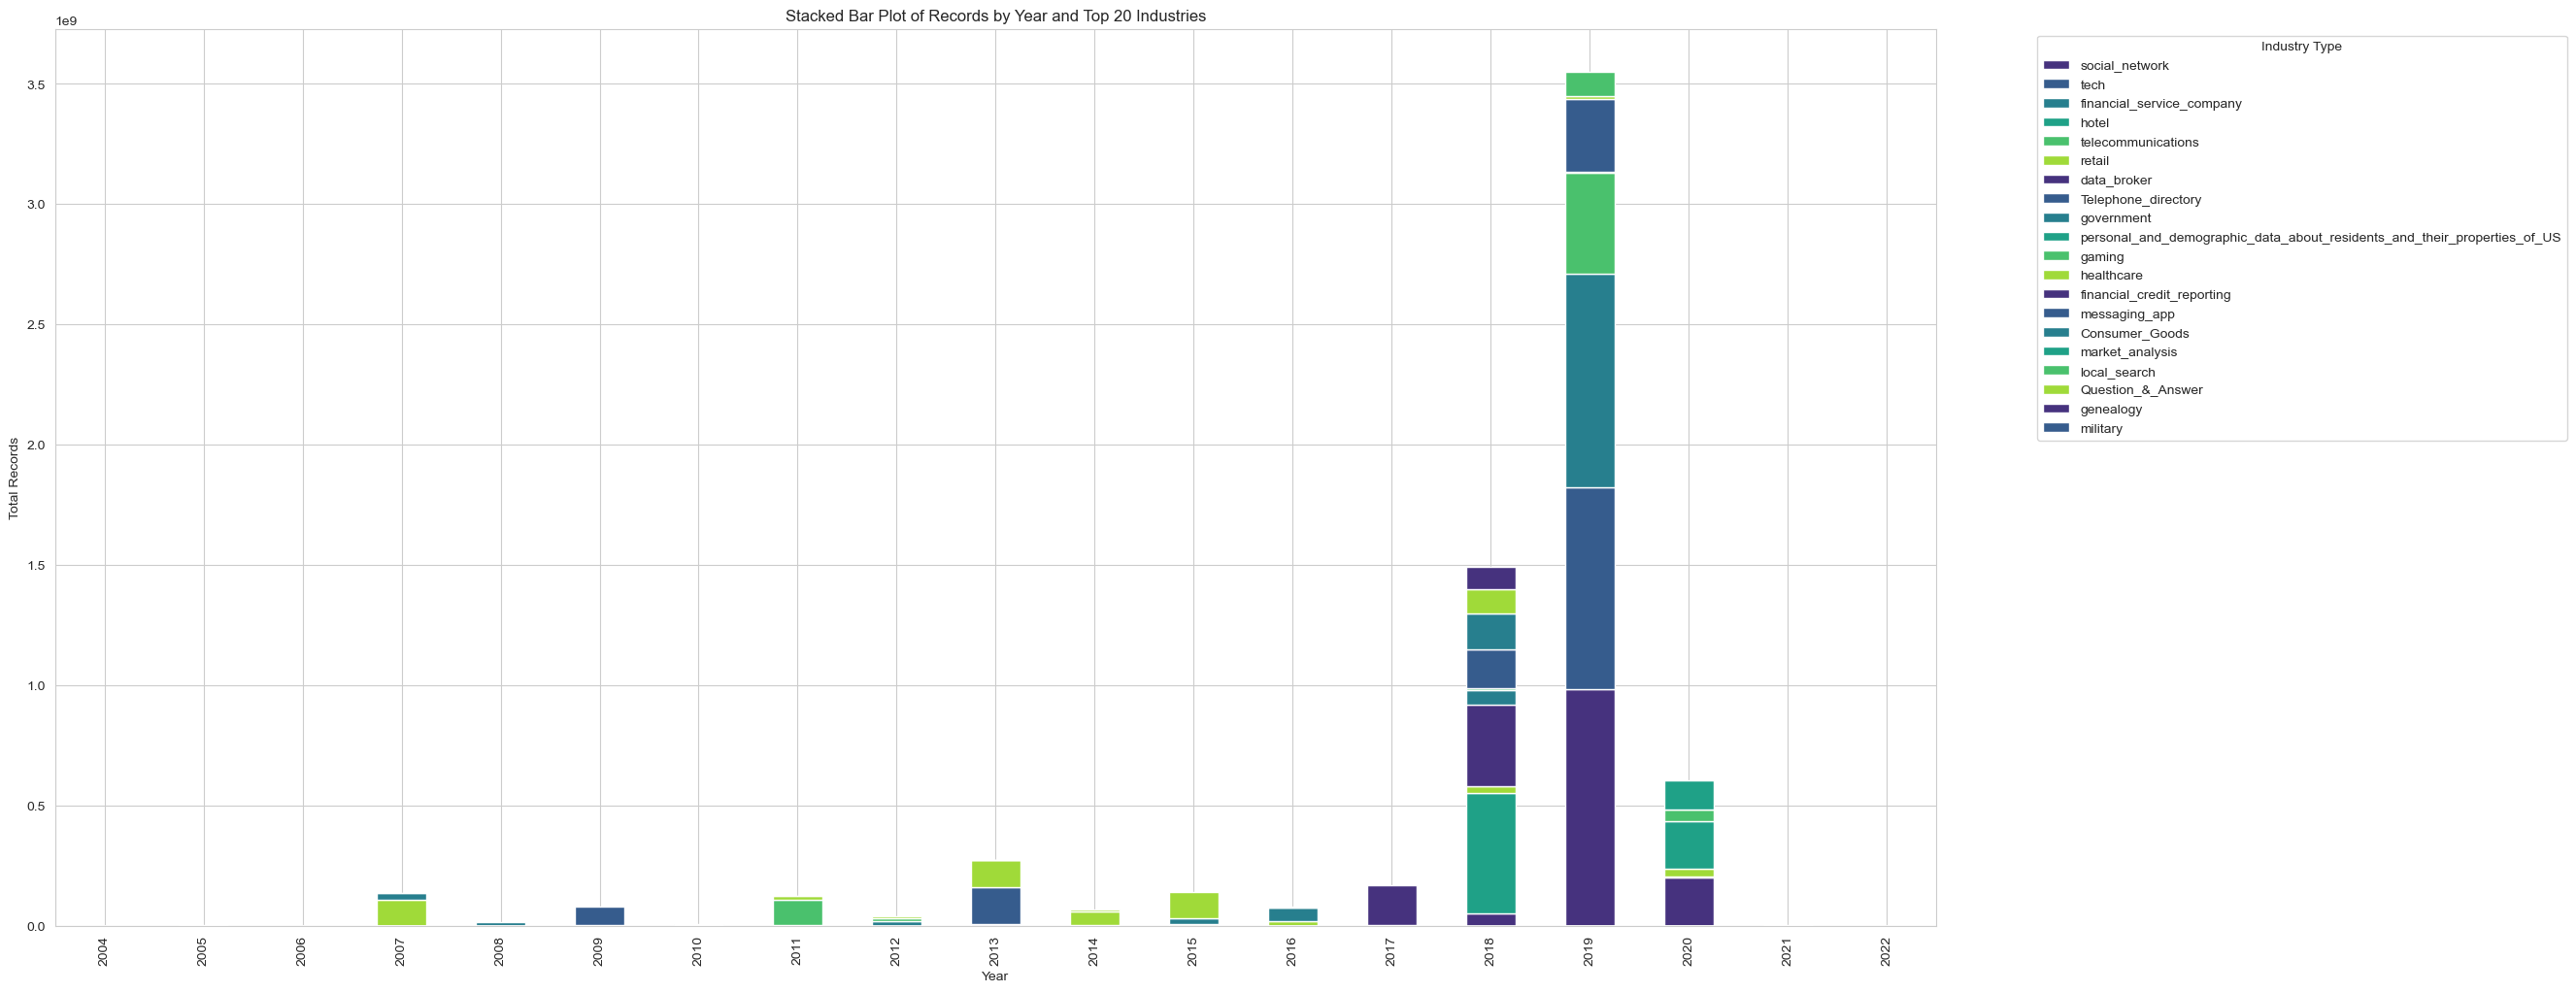

In [38]:


# Grouping the data by year and industry and summing the 'Records' column
records_by_year_and_industry = df_vis.groupby(['Year', 'Organization_type'])['Records'].sum().unstack()

# Finding the top 20 industries based on total records
top_20_industries = records_by_year_and_industry.sum().sort_values(ascending=False).head(20).index

# Filtering the DataFrame to include only the top 20 industries
records_by_year_and_industry_top20 = records_by_year_and_industry[top_20_industries]

# Creating a stacked bar plot for records by year and industry (top 20)
records_by_year_and_industry_top20.plot(kind='bar', stacked=True, figsize=(25, 12))

# Adding labels and title
plt.title("Stacked Bar Plot of Records by Year and Top 20 Industries")
plt.xlabel("Year")
plt.ylabel("Total Records")
plt.xticks(rotation=90)
plt.legend(title='Industry Type', bbox_to_anchor=(1.05, 1), loc='upper left')  # Adjust legend position

#save the plot as "industryrecords.png" in the directory called graphs
plt.savefig('visualization_graphs/industryrecords.png', bbox_inches='tight')
# Display the plot
plt.show()
#displays a bar plot vertically stacked on top of one another


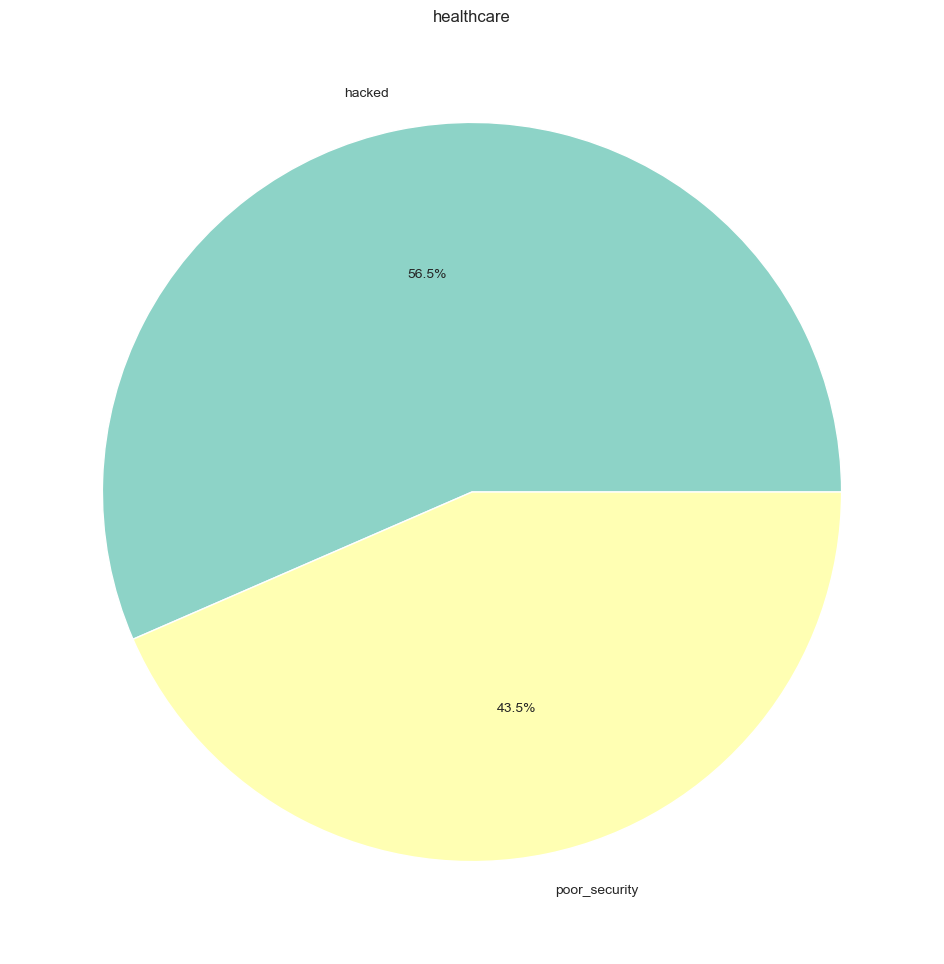

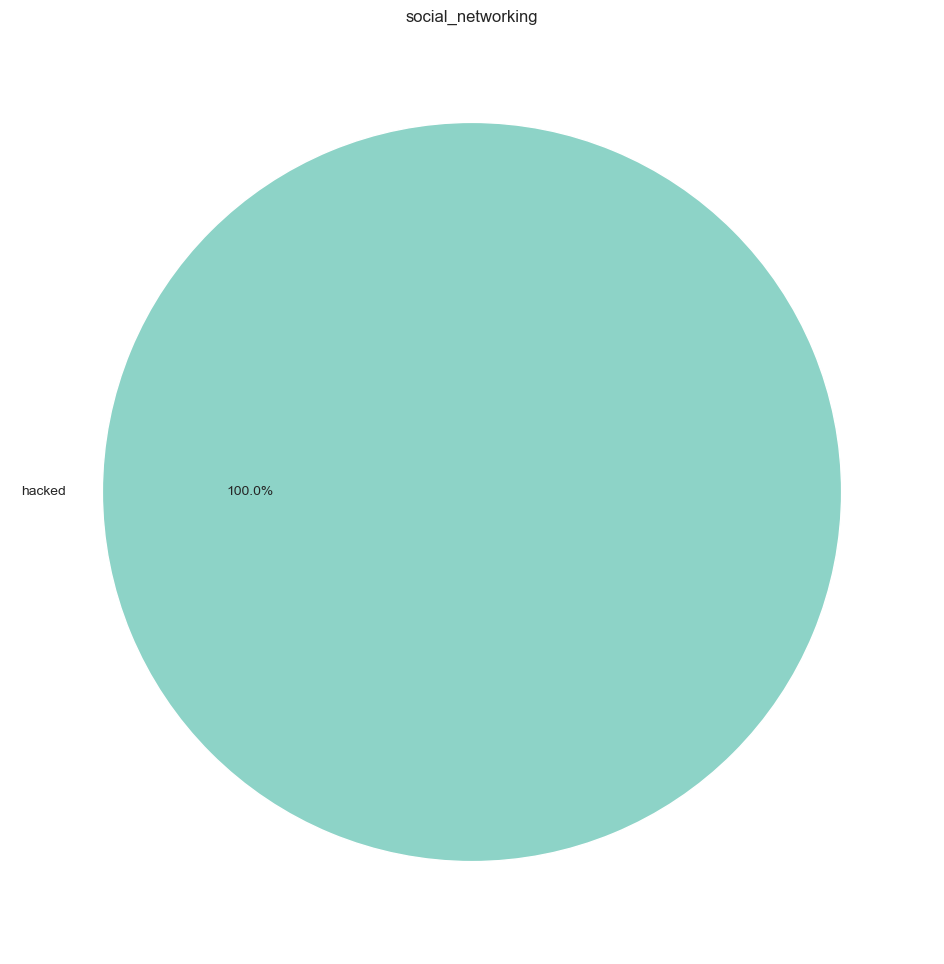

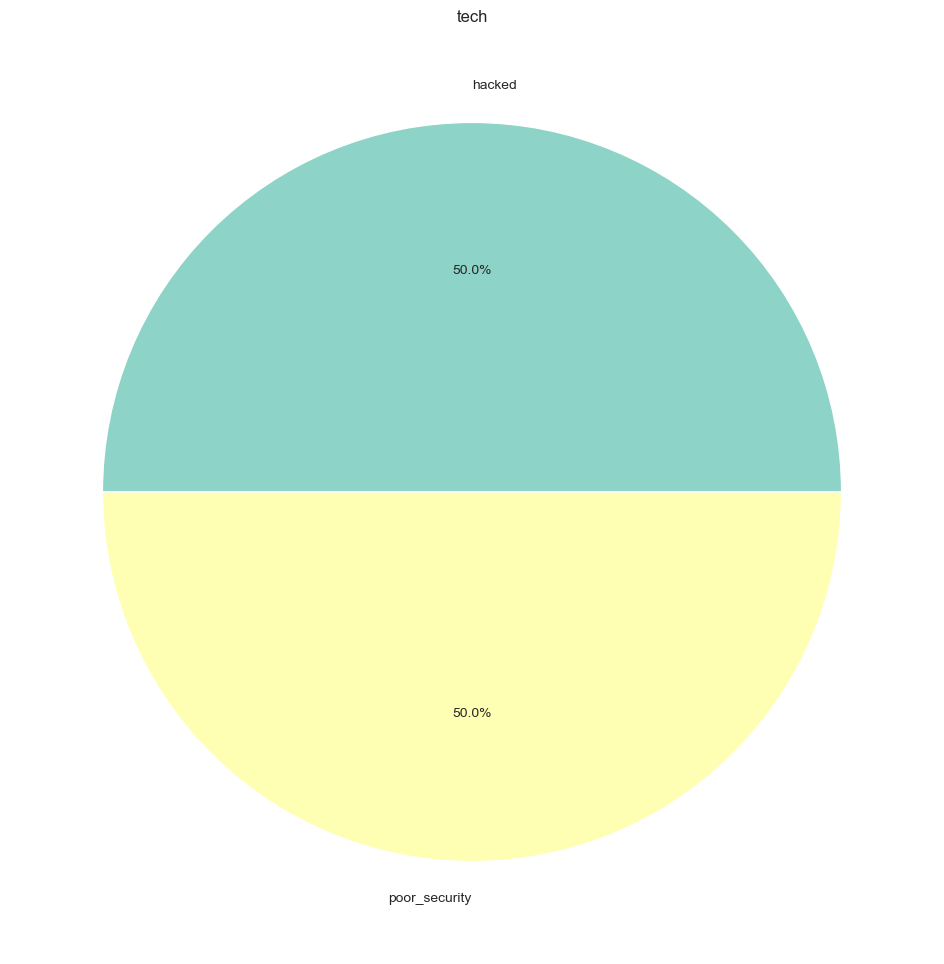

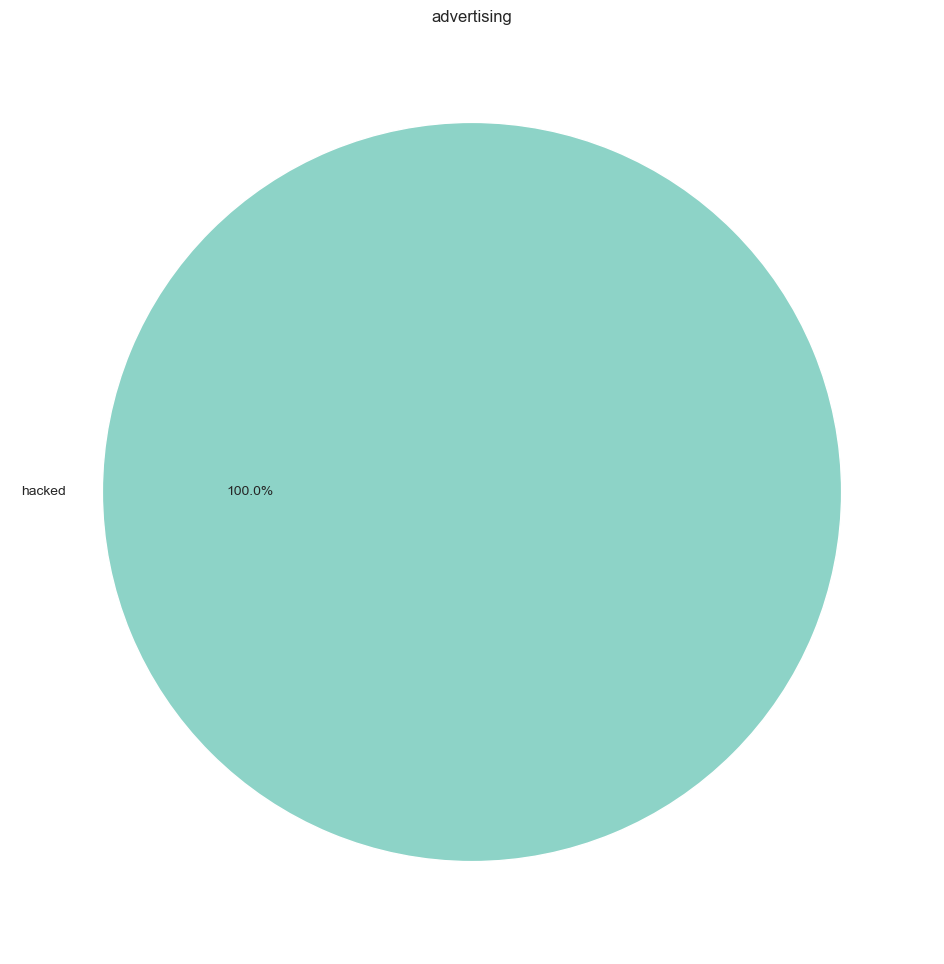

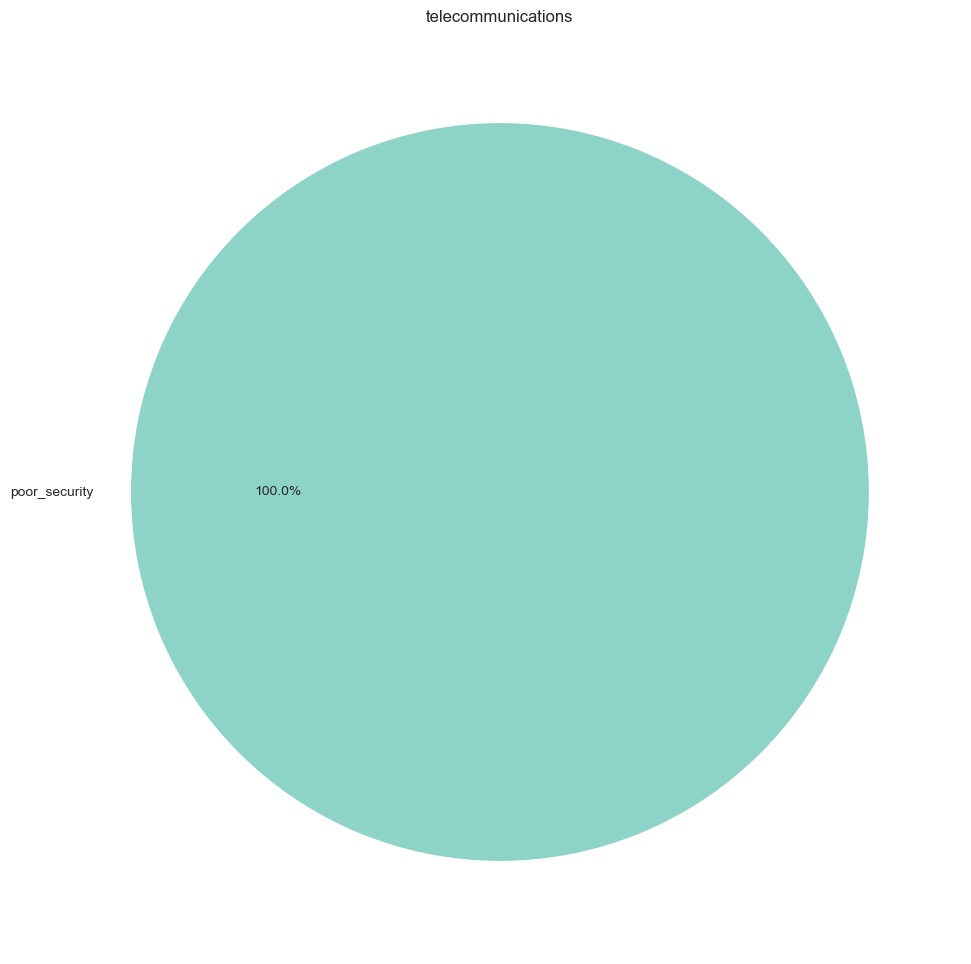

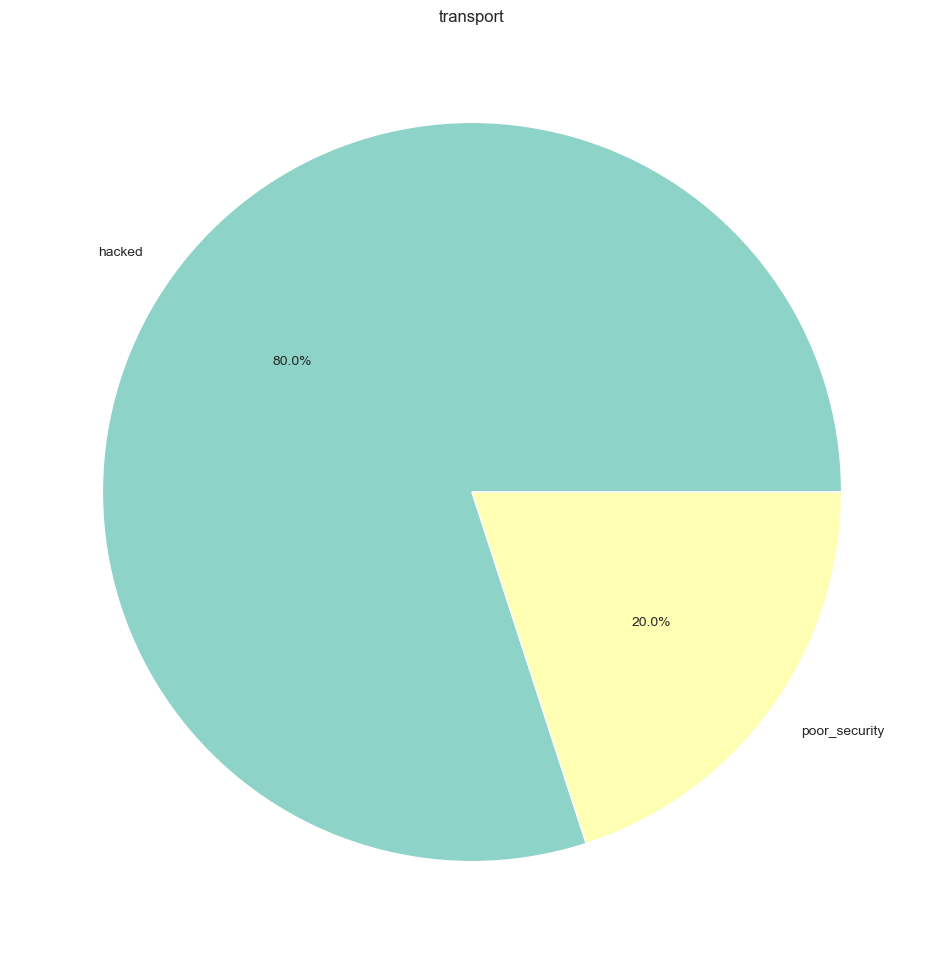

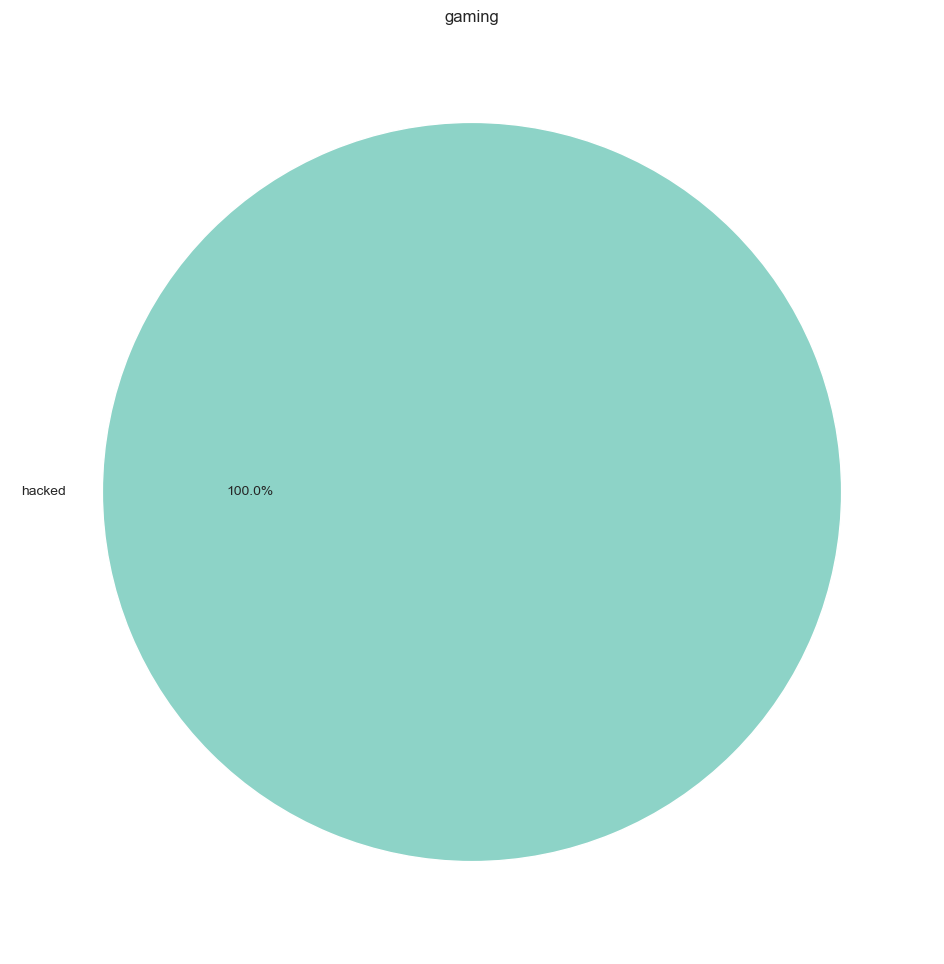

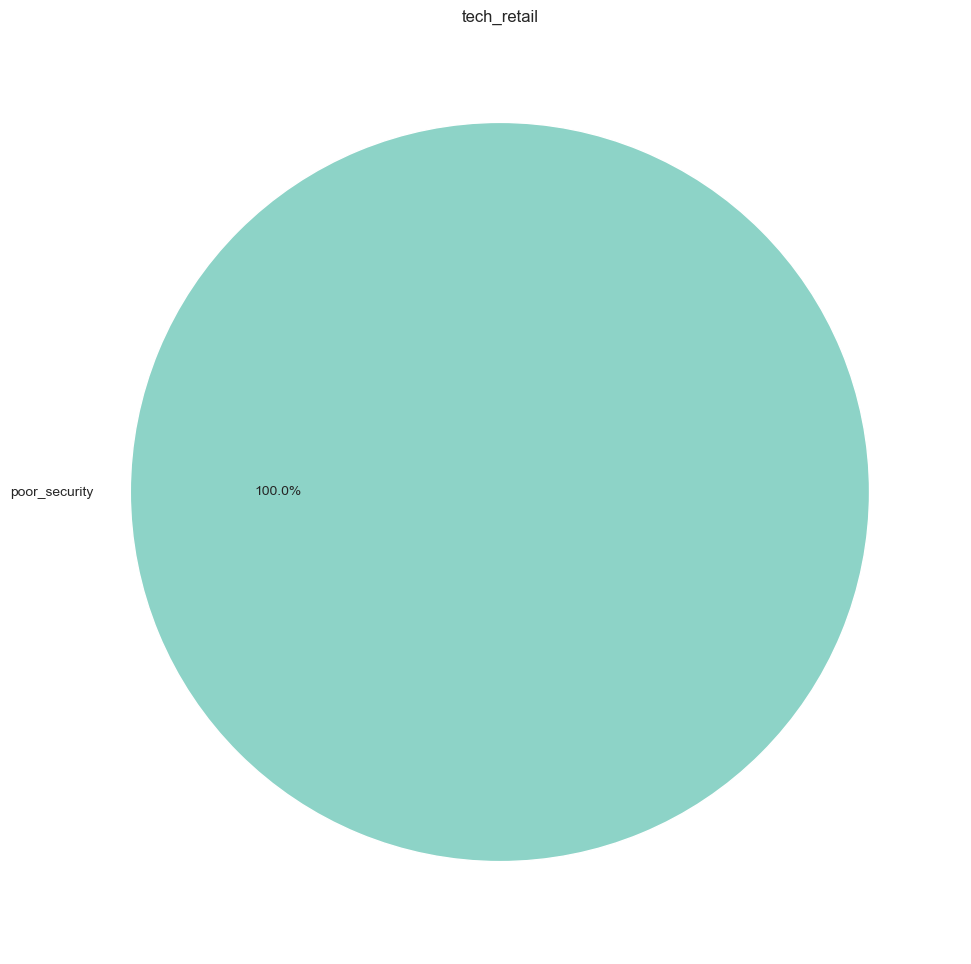

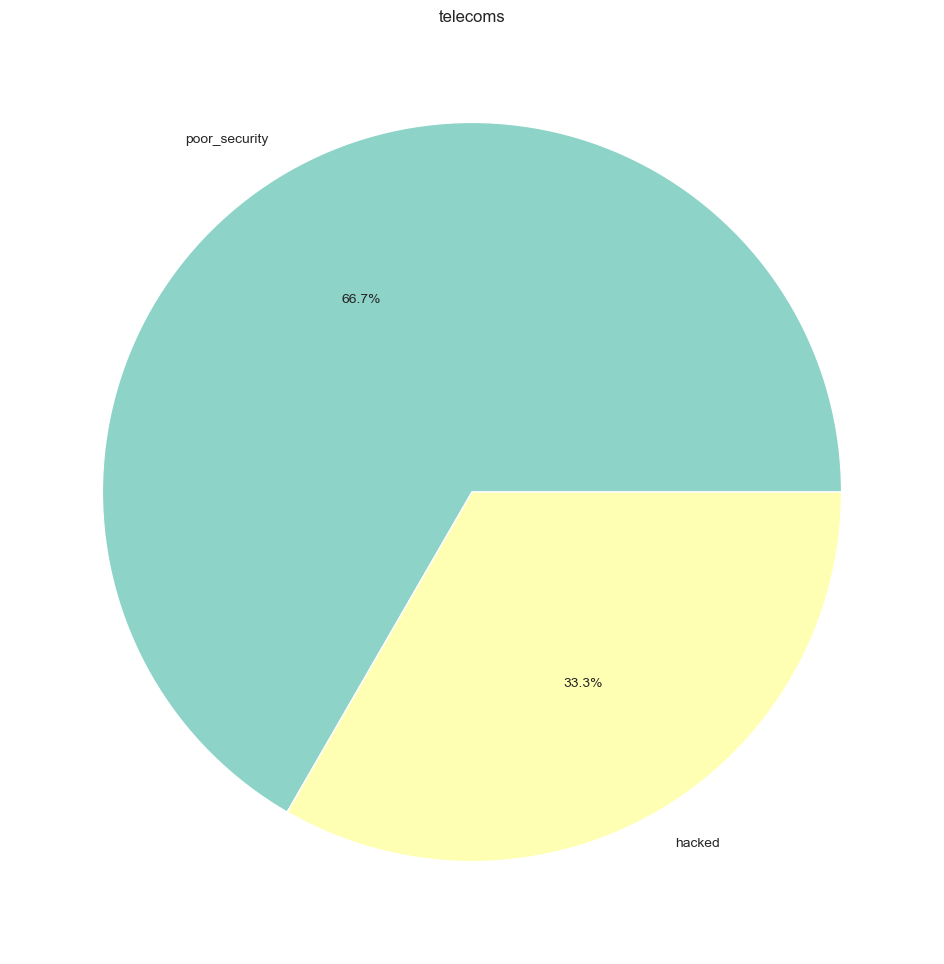

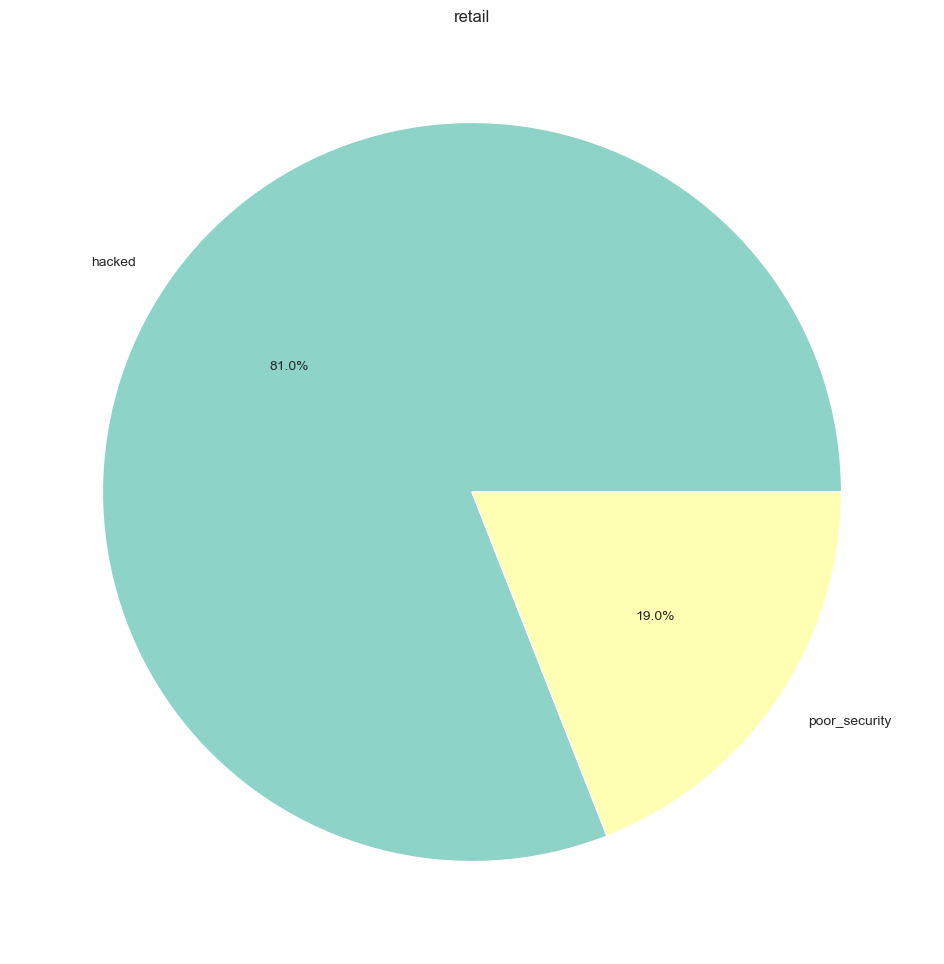

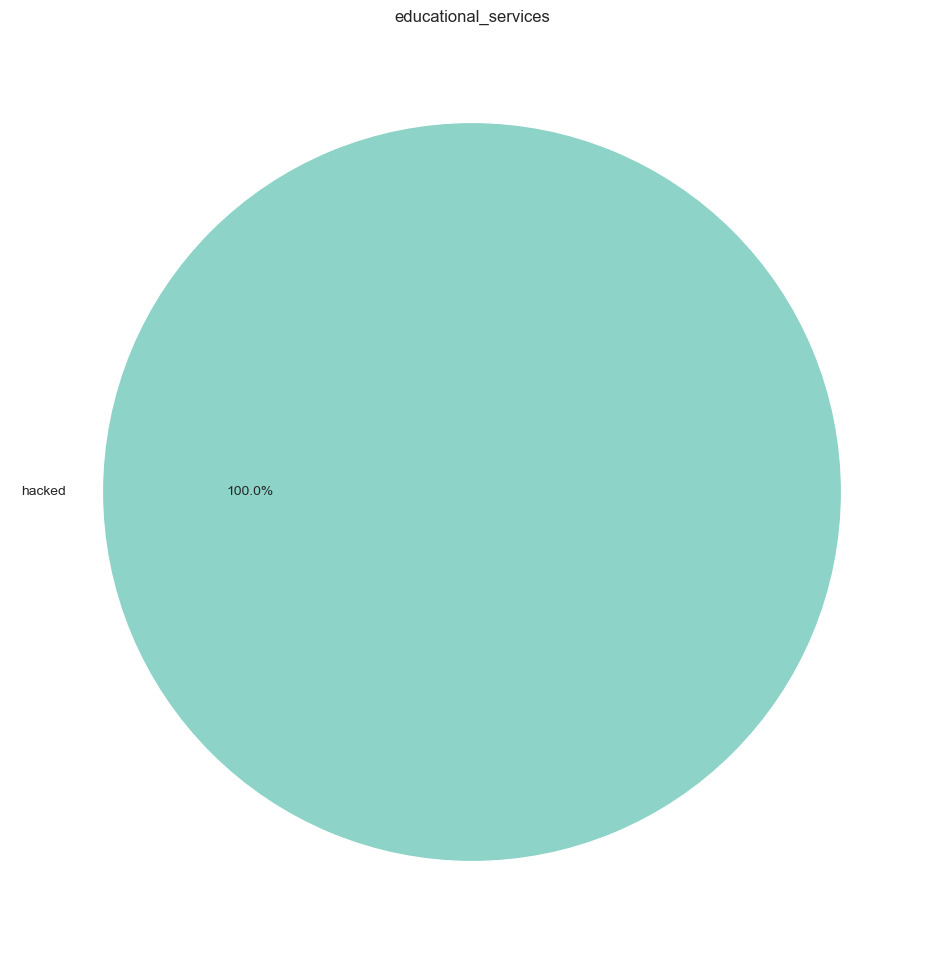

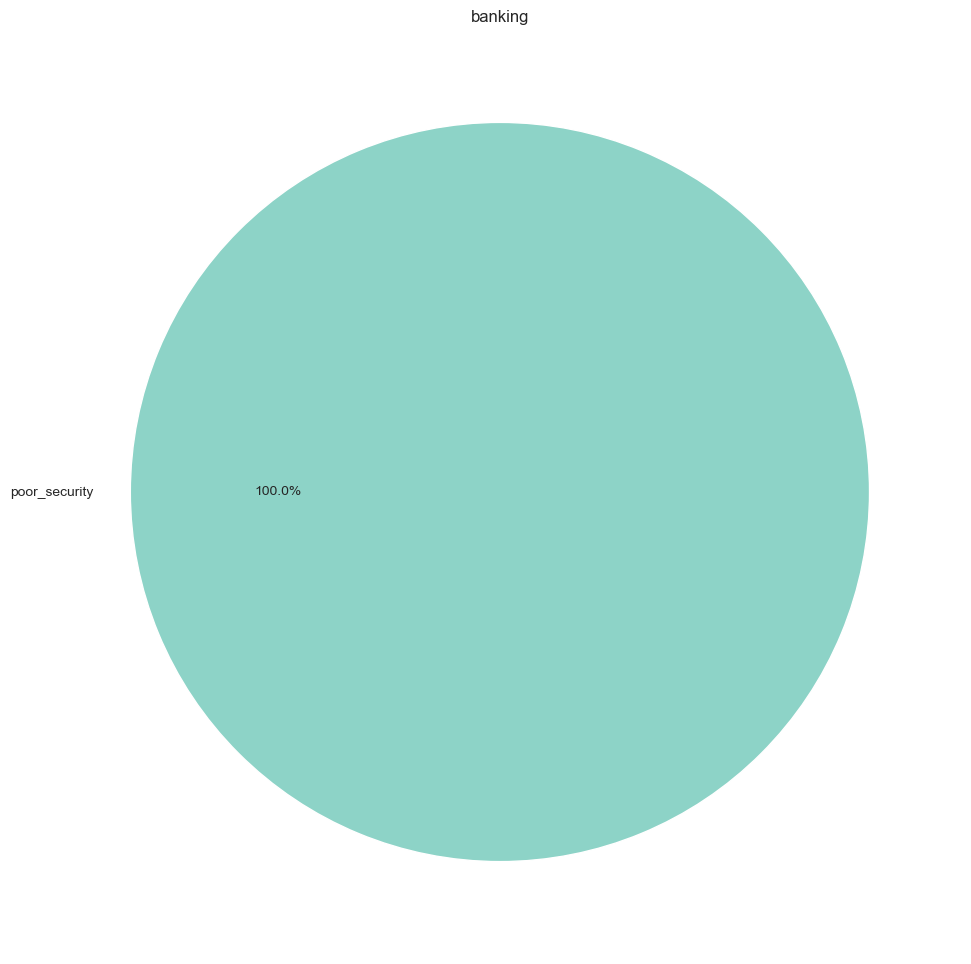

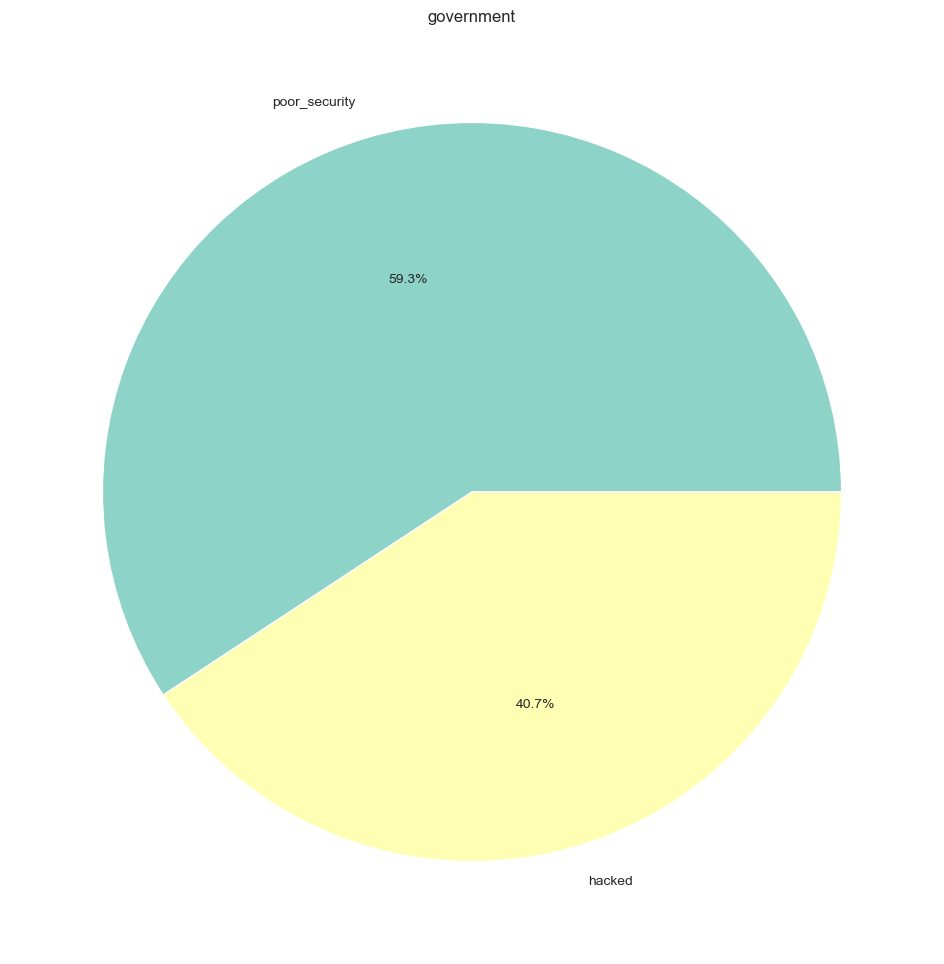

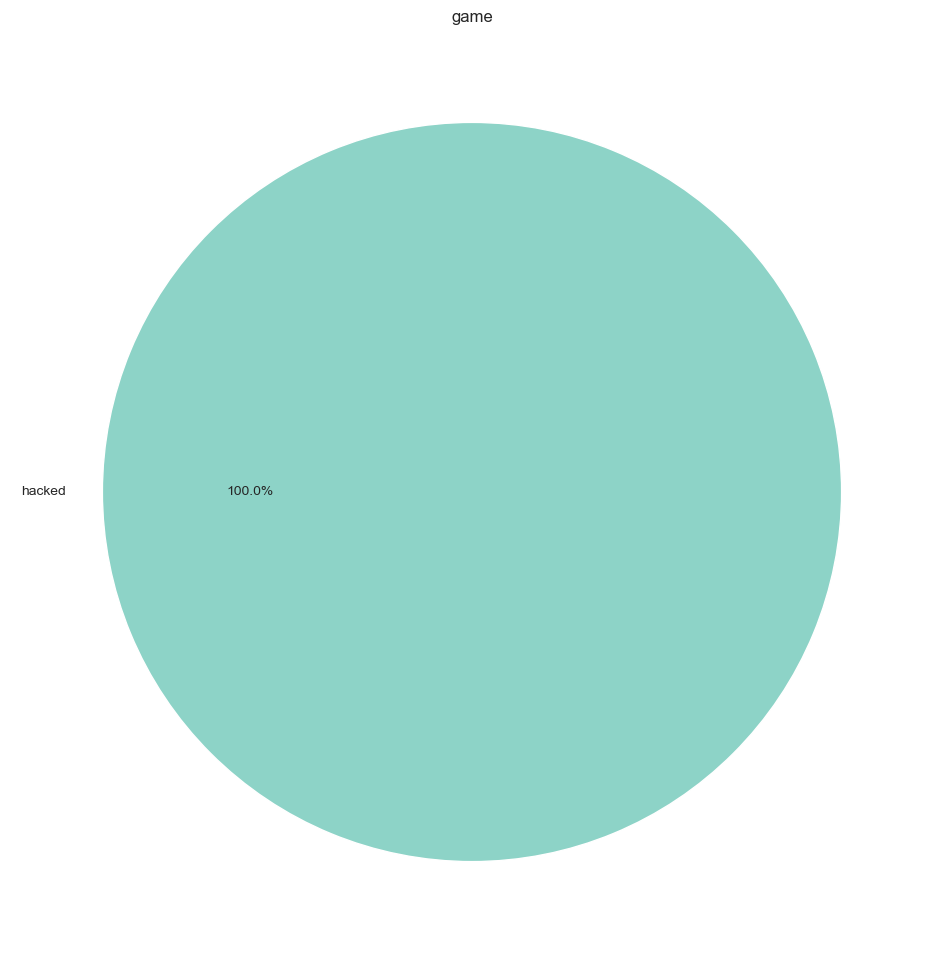

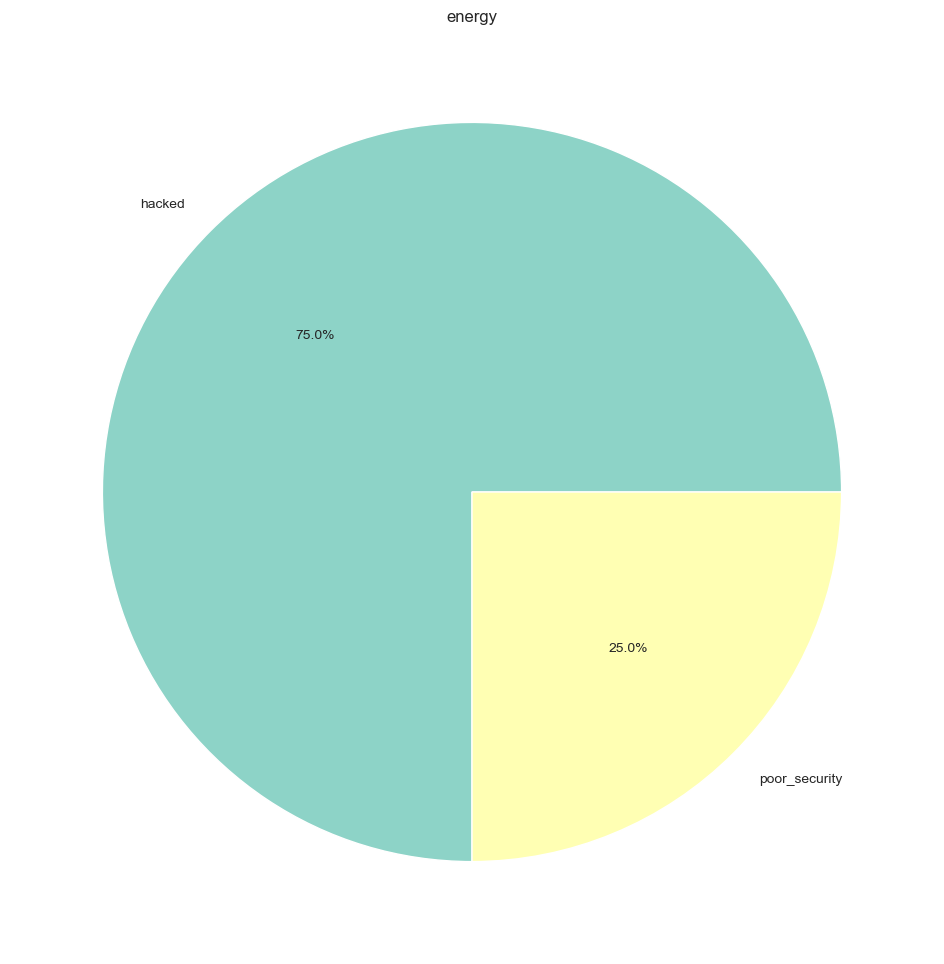

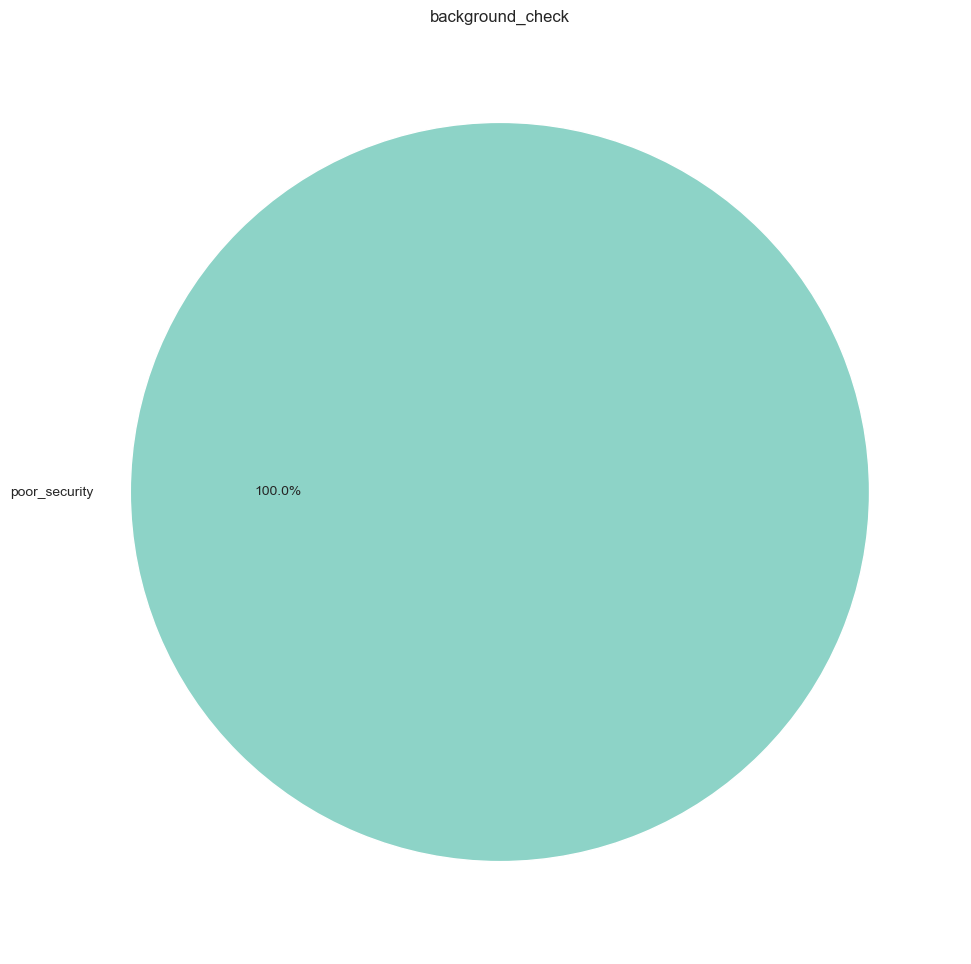

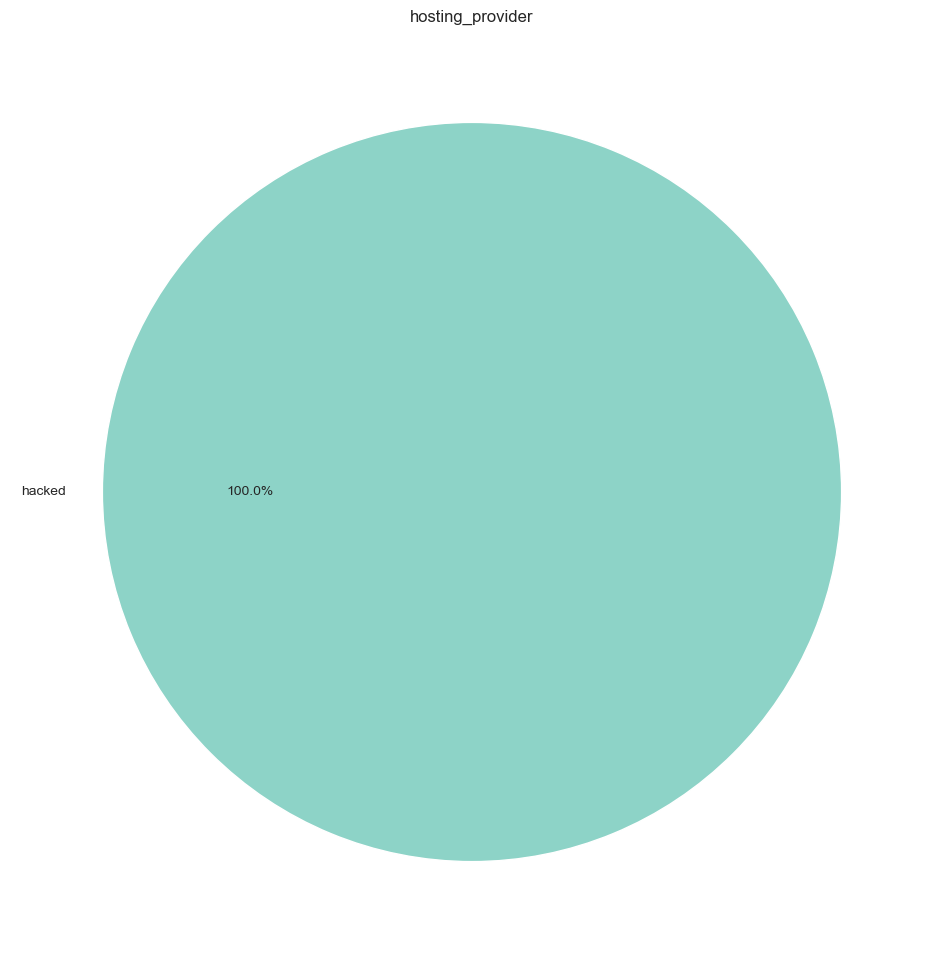

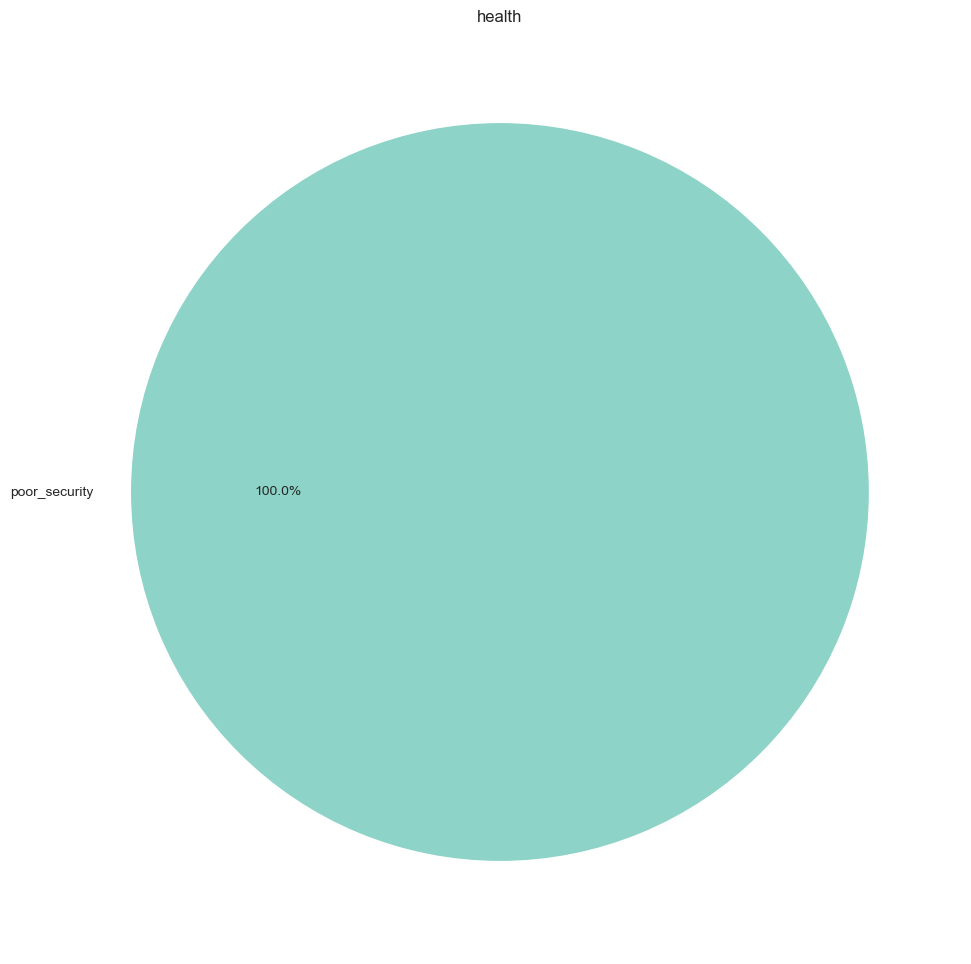

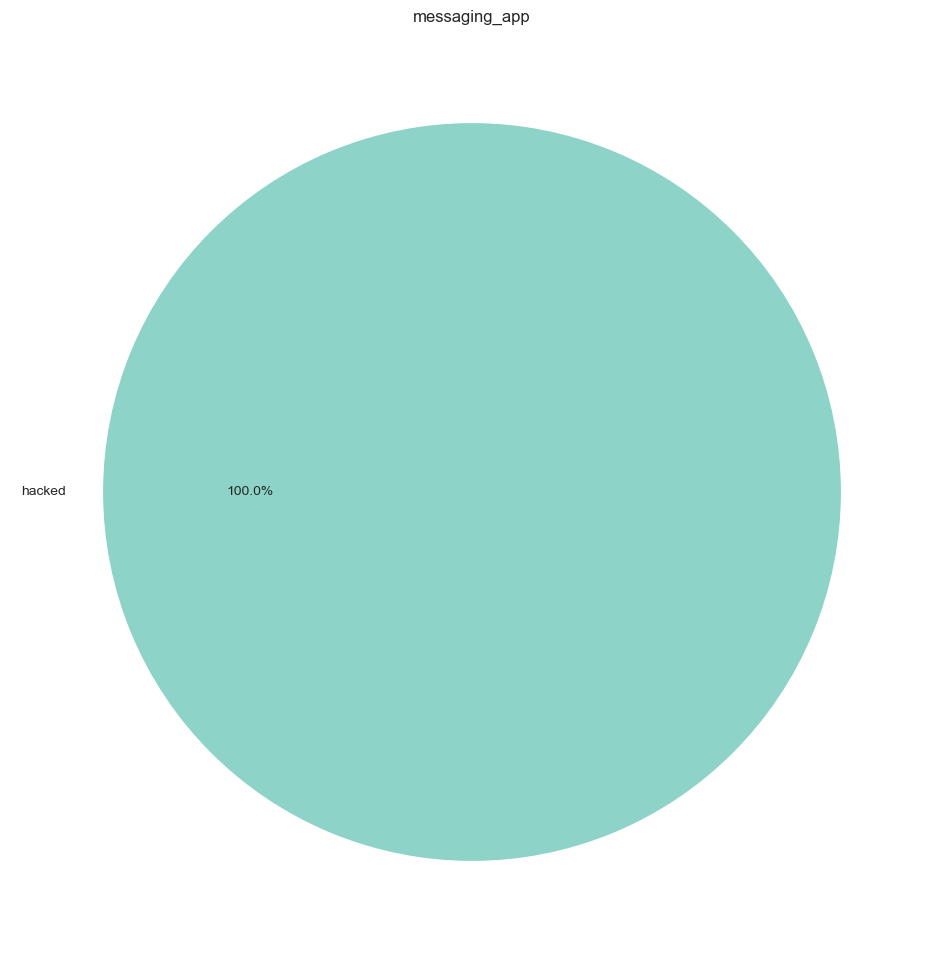

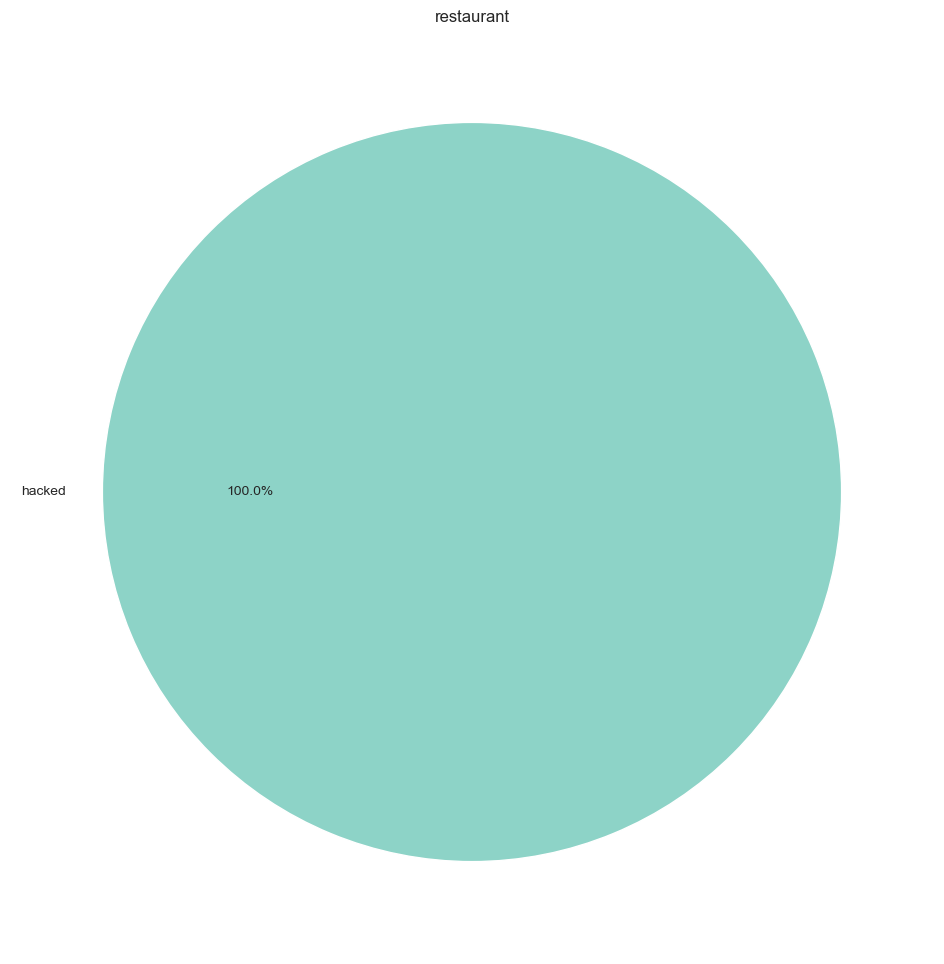

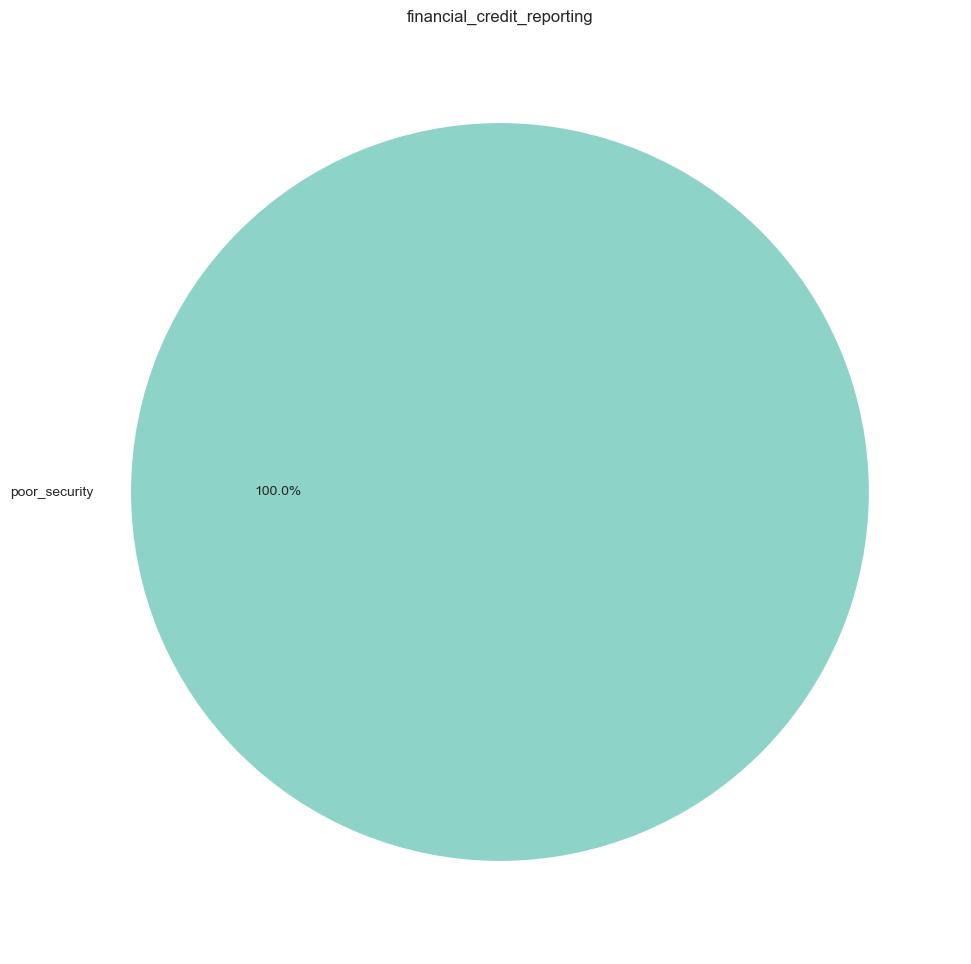

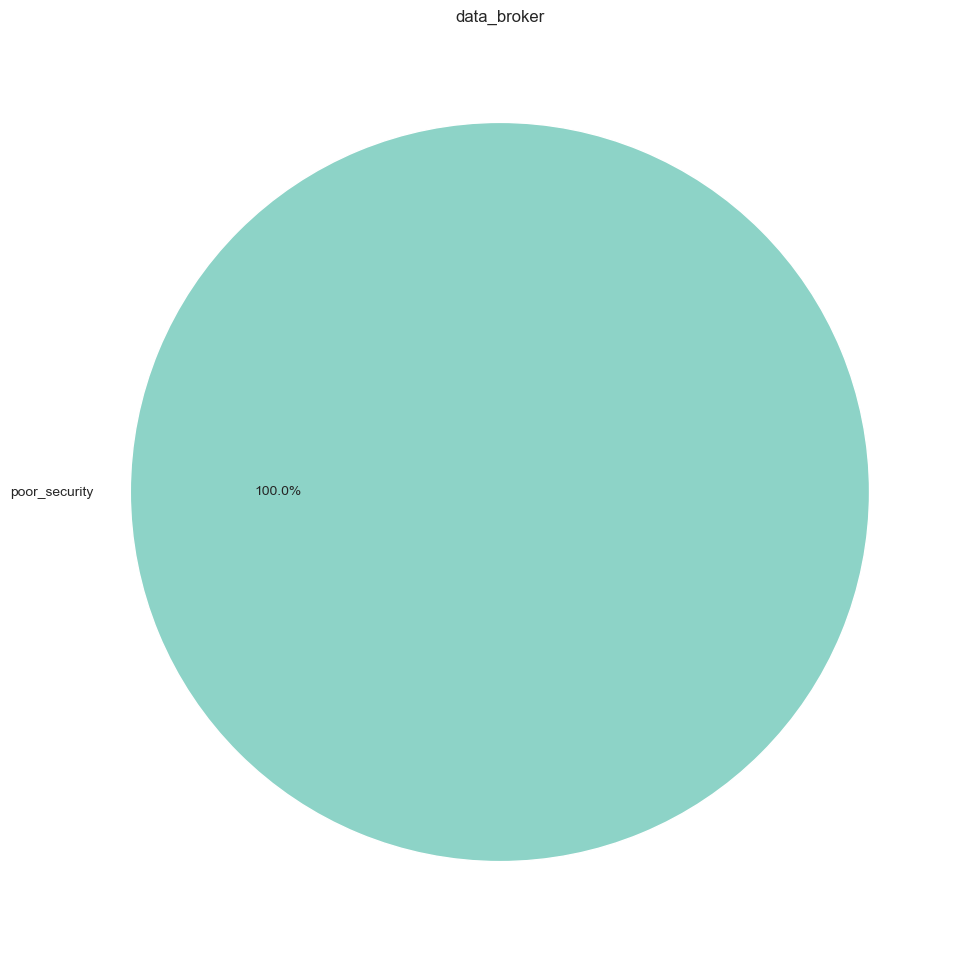

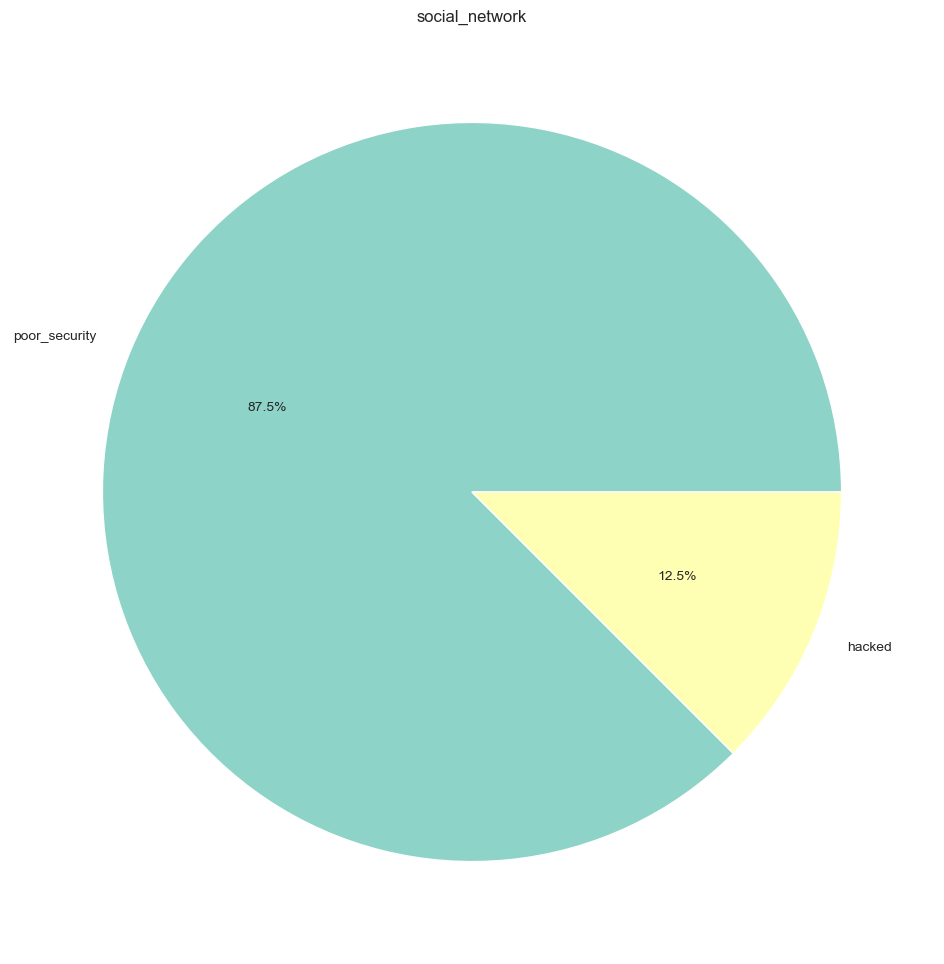

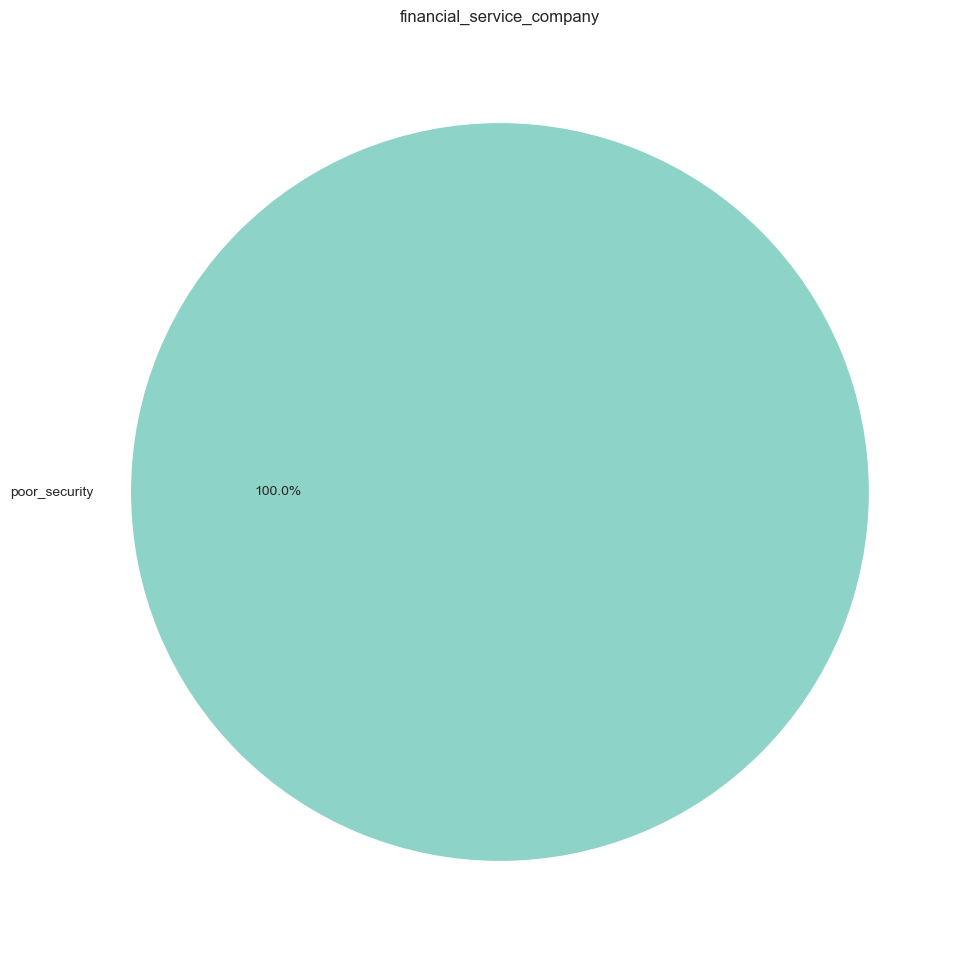

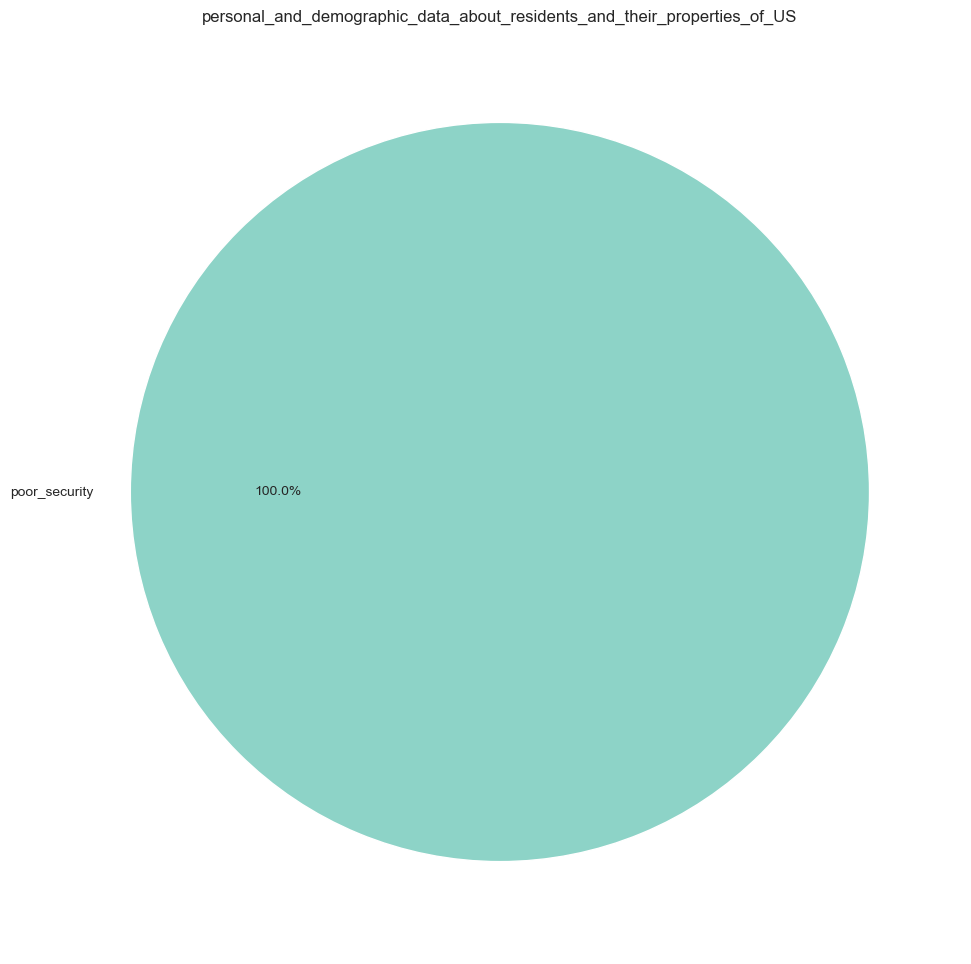

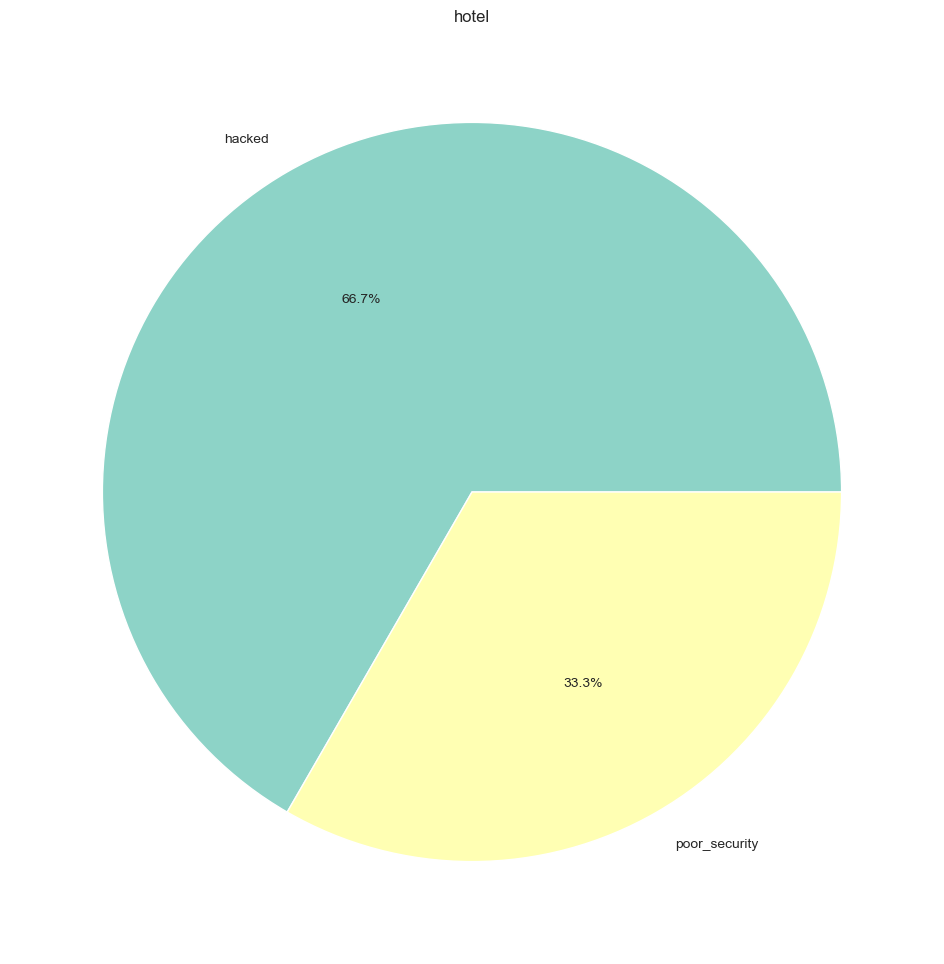

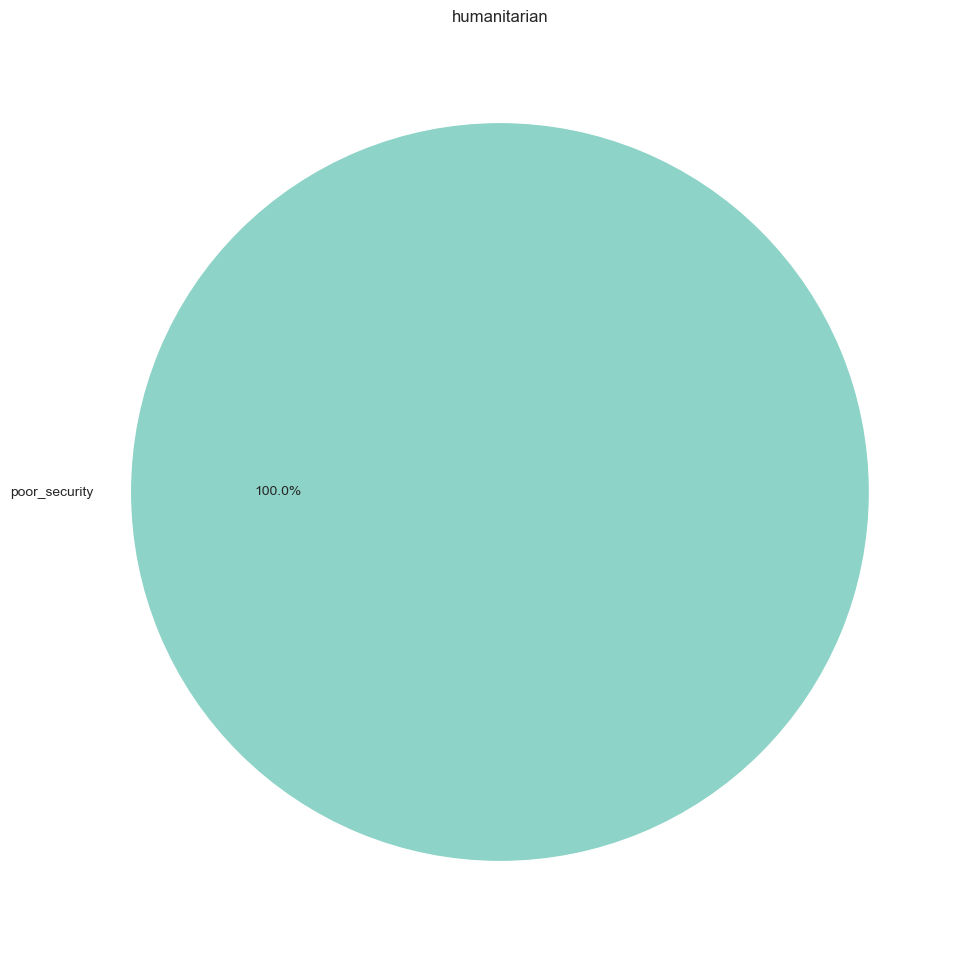

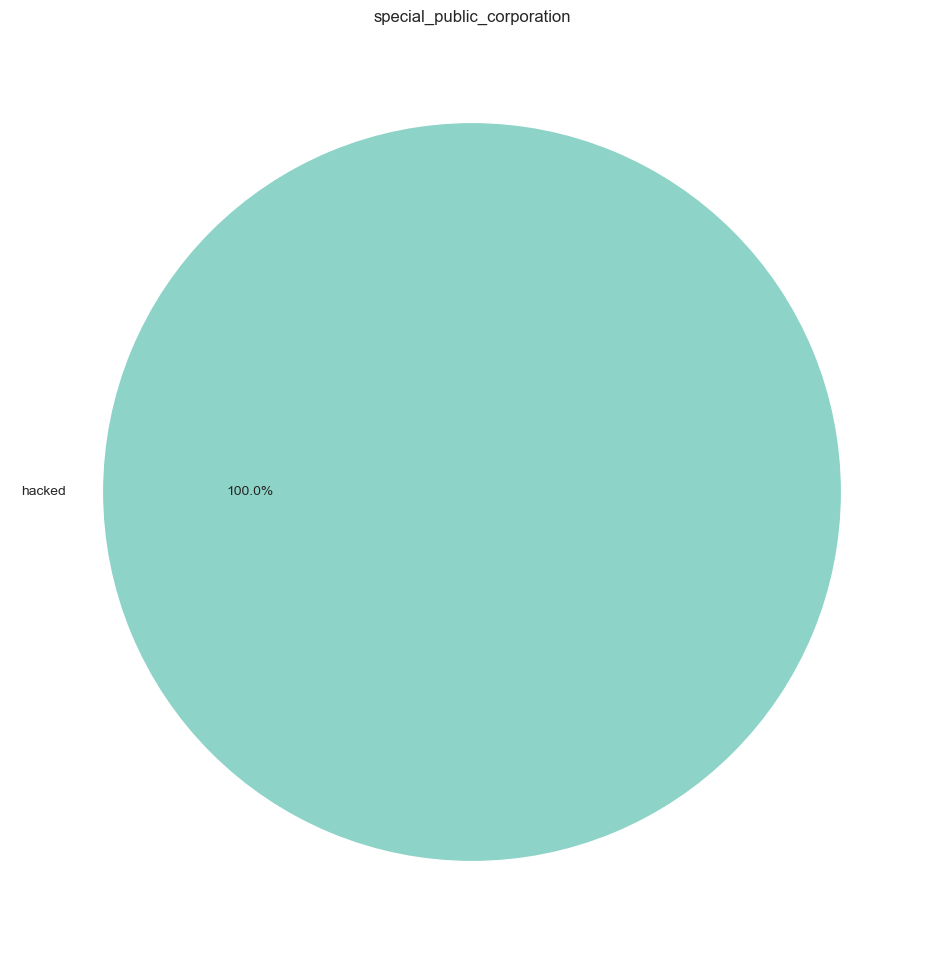

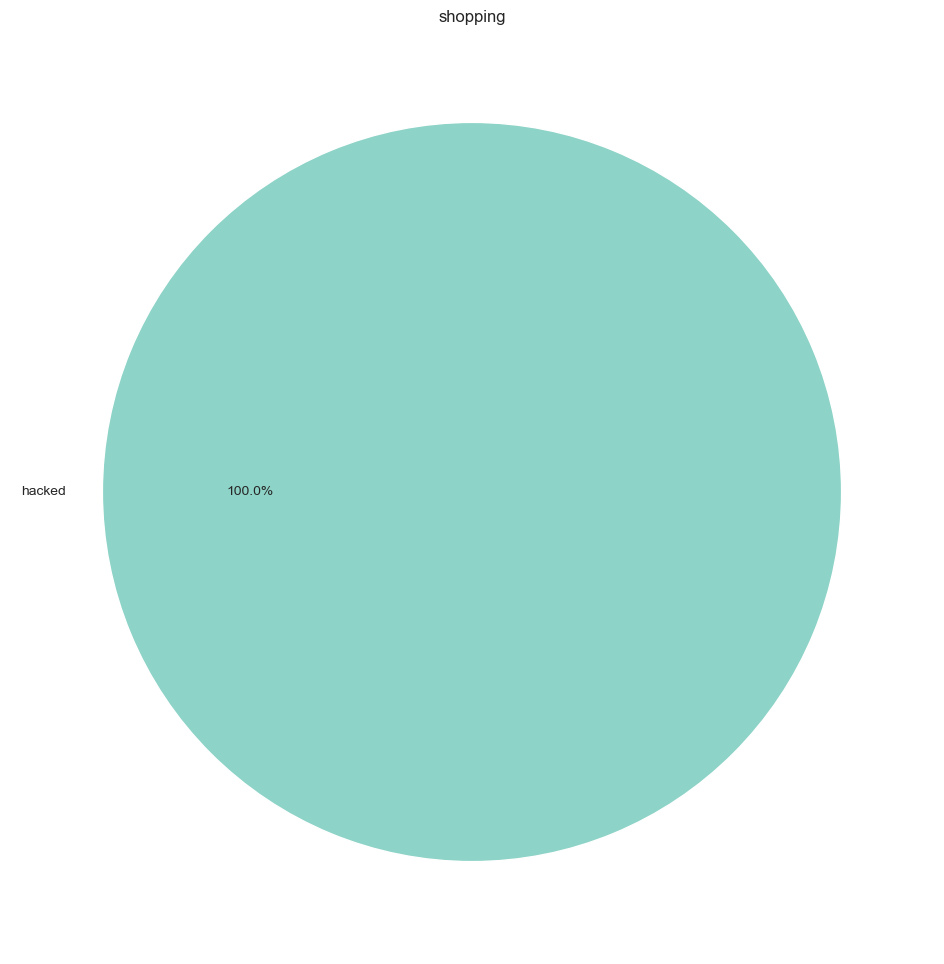

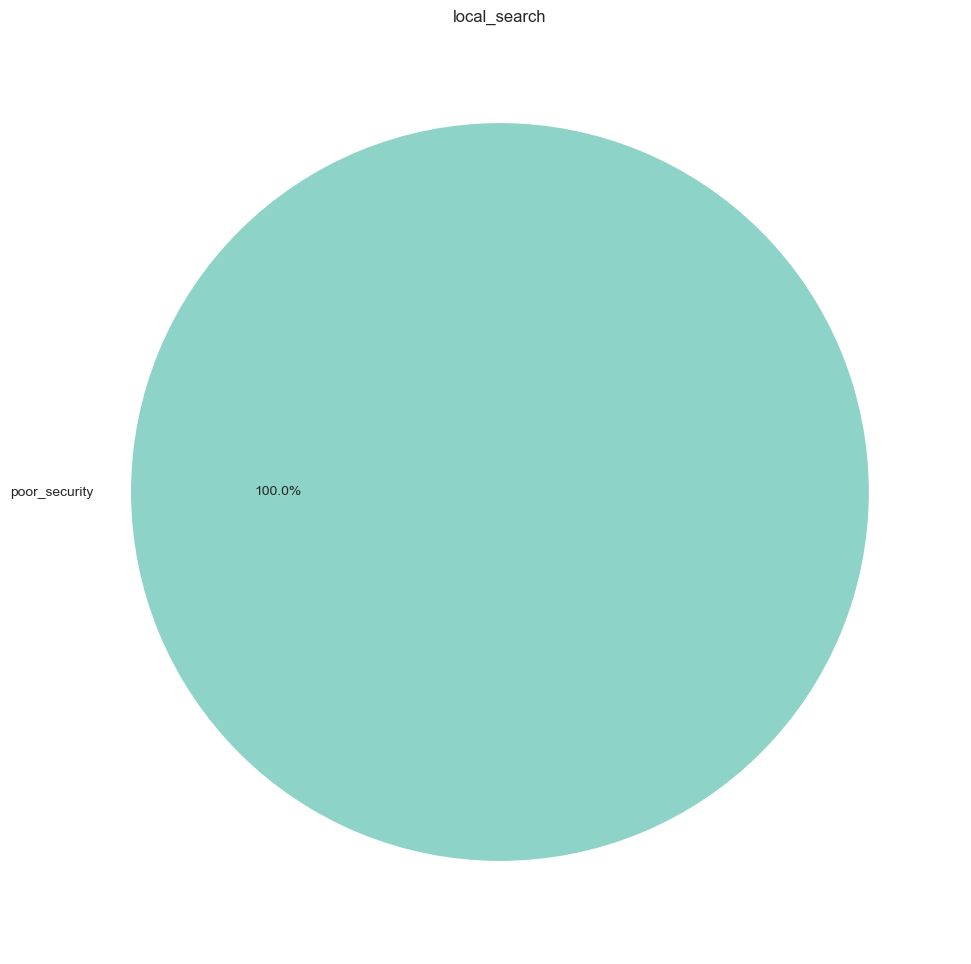

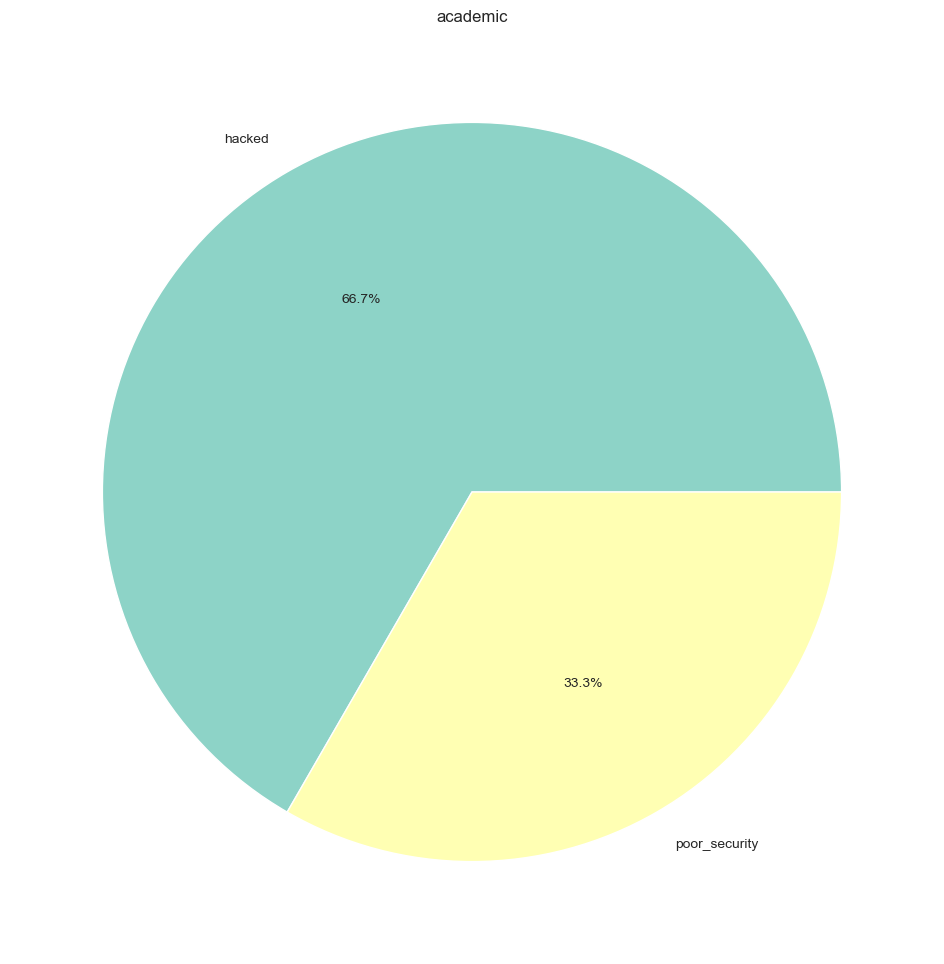

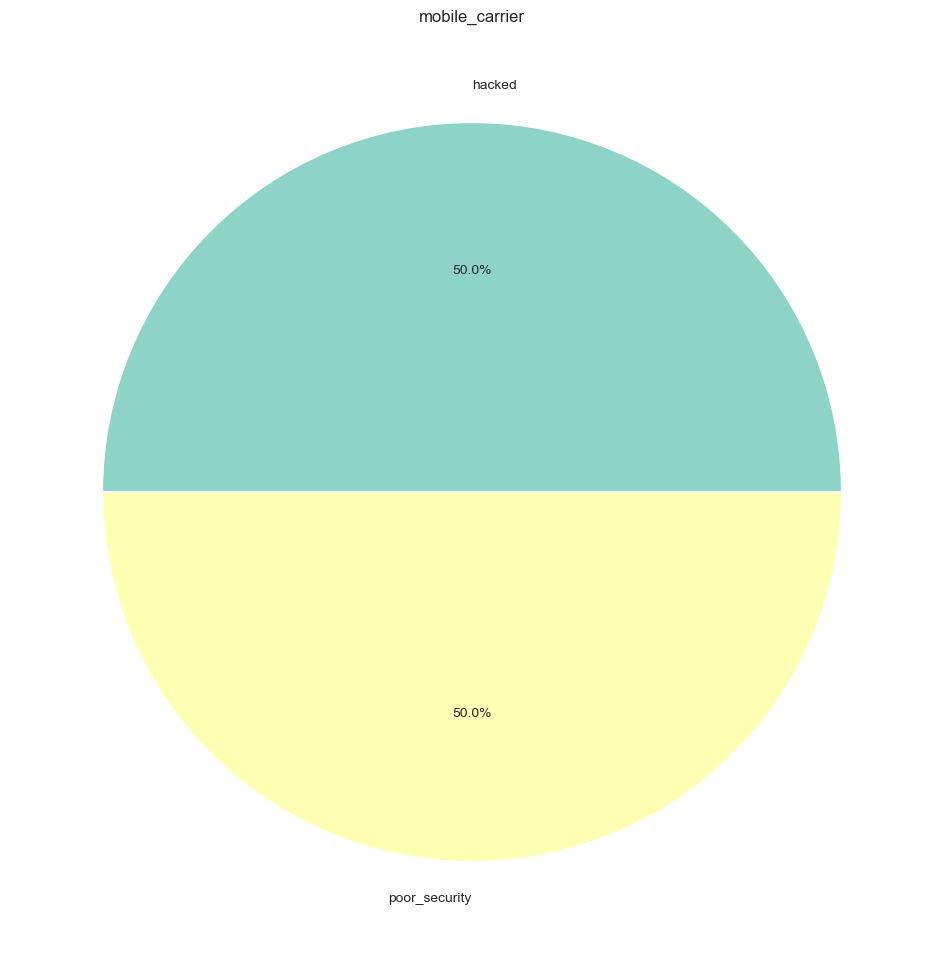

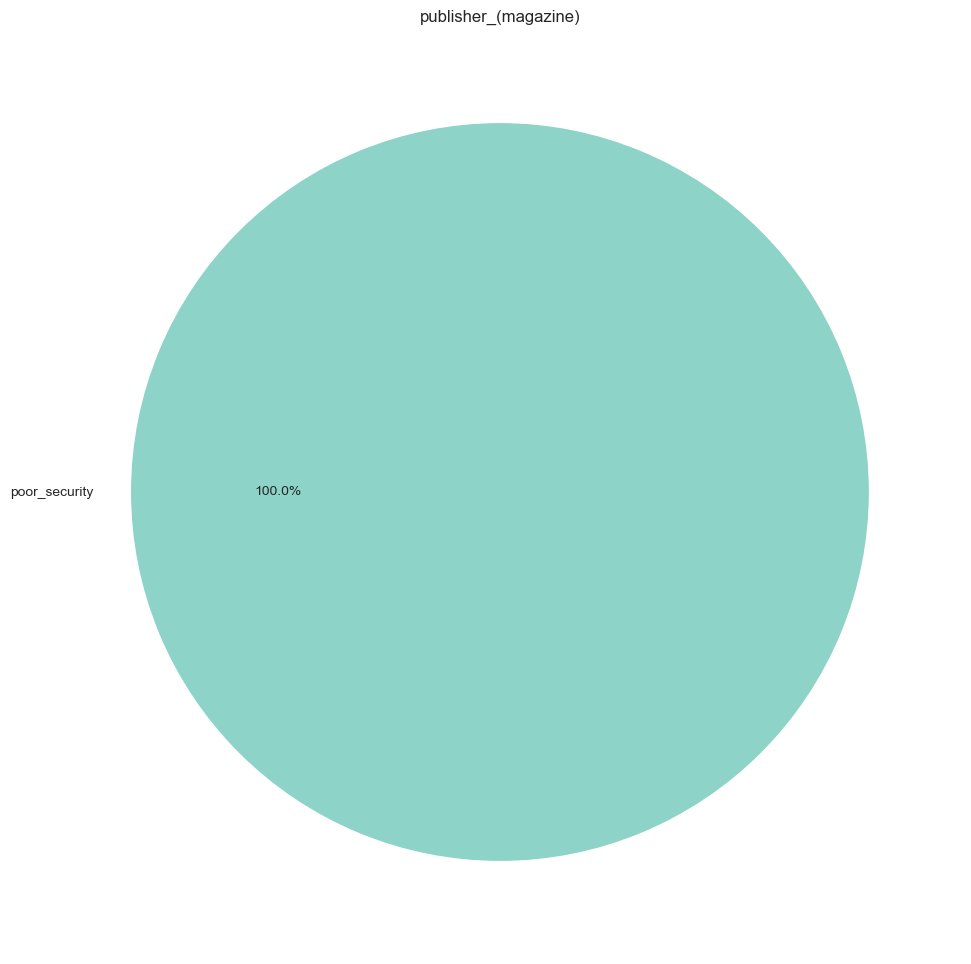

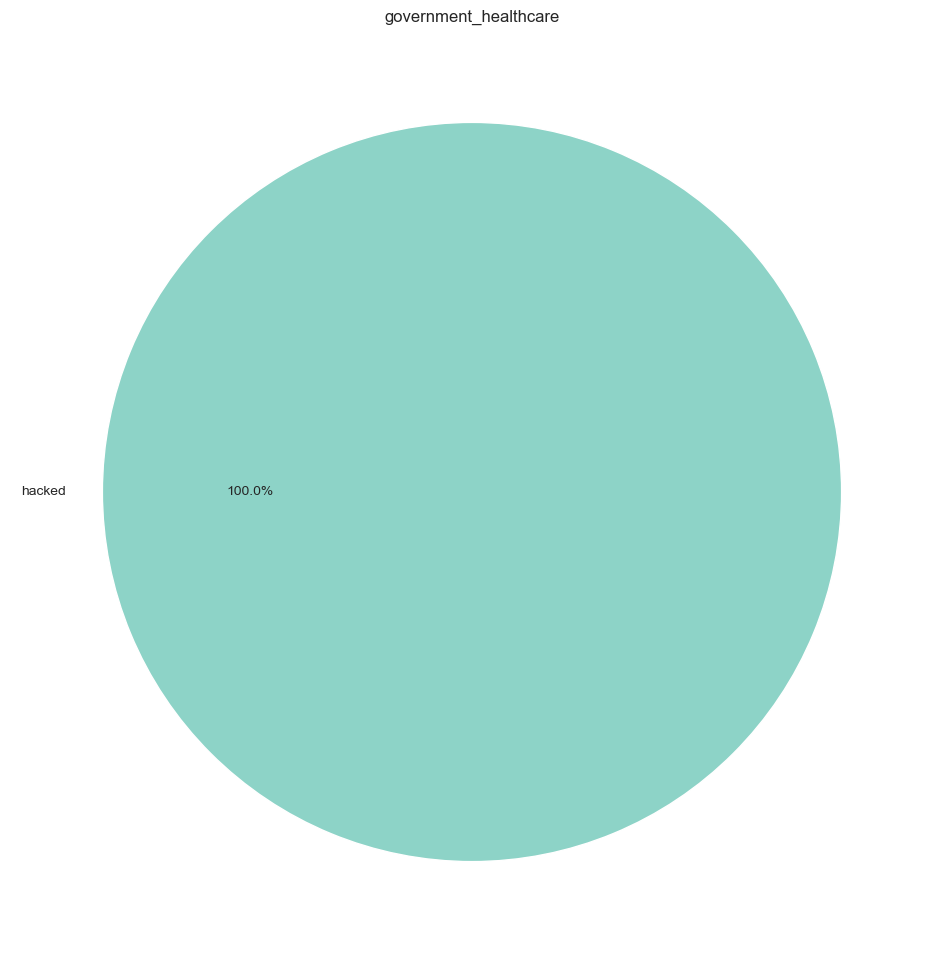

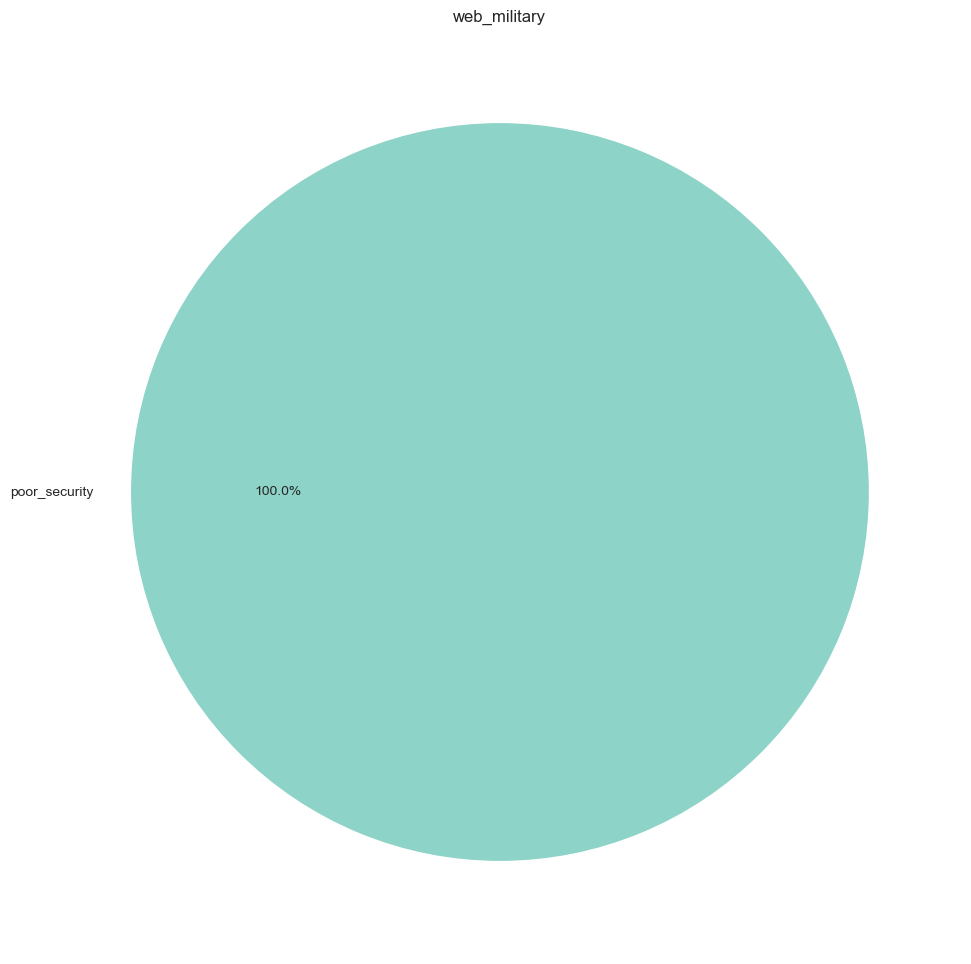

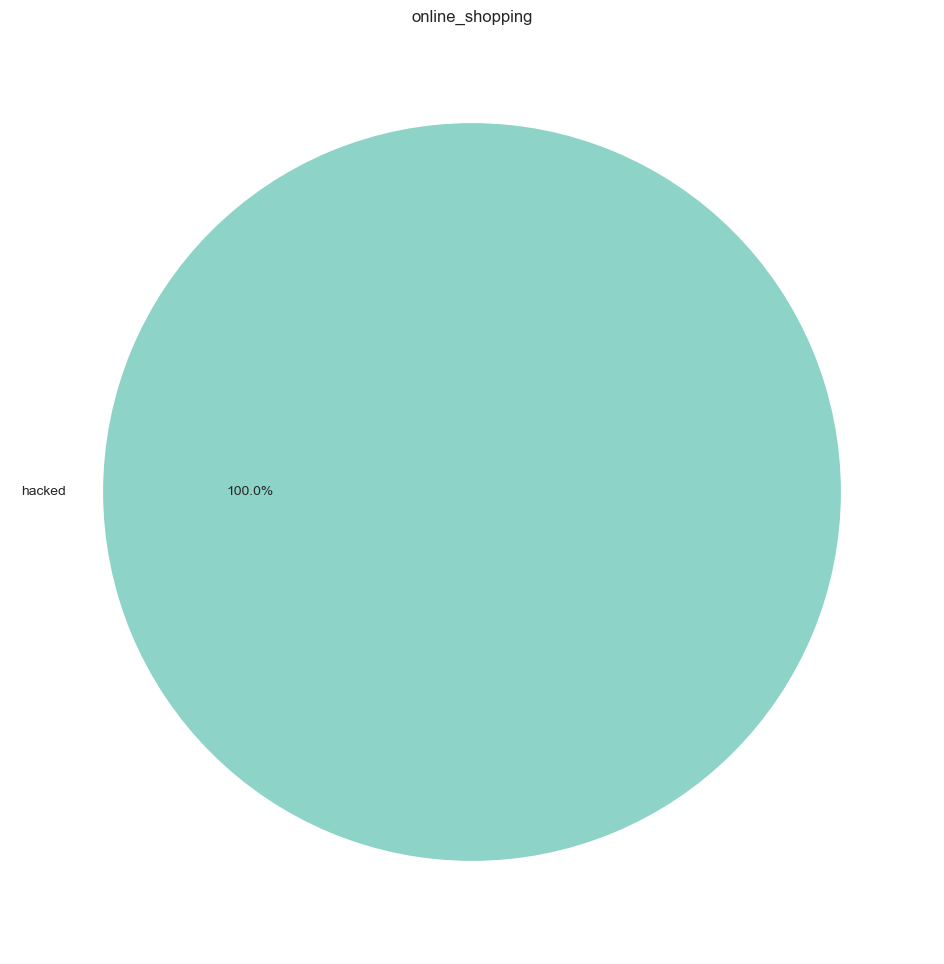

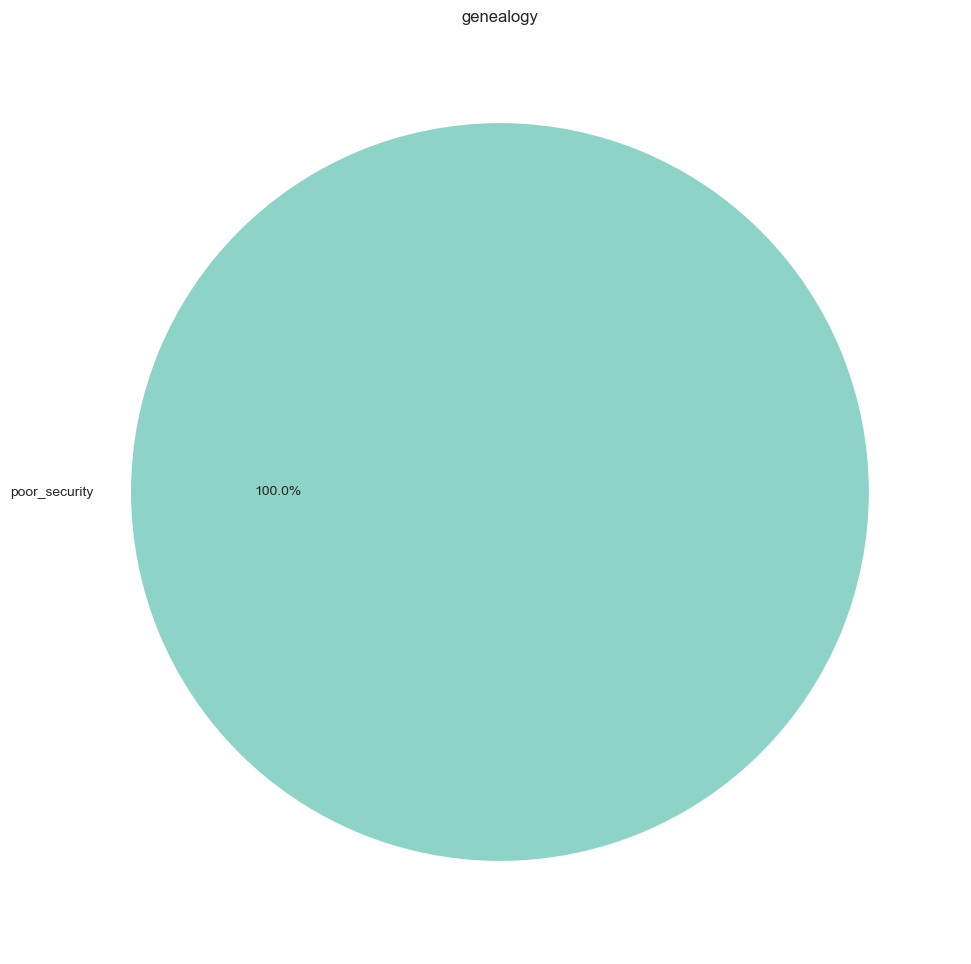

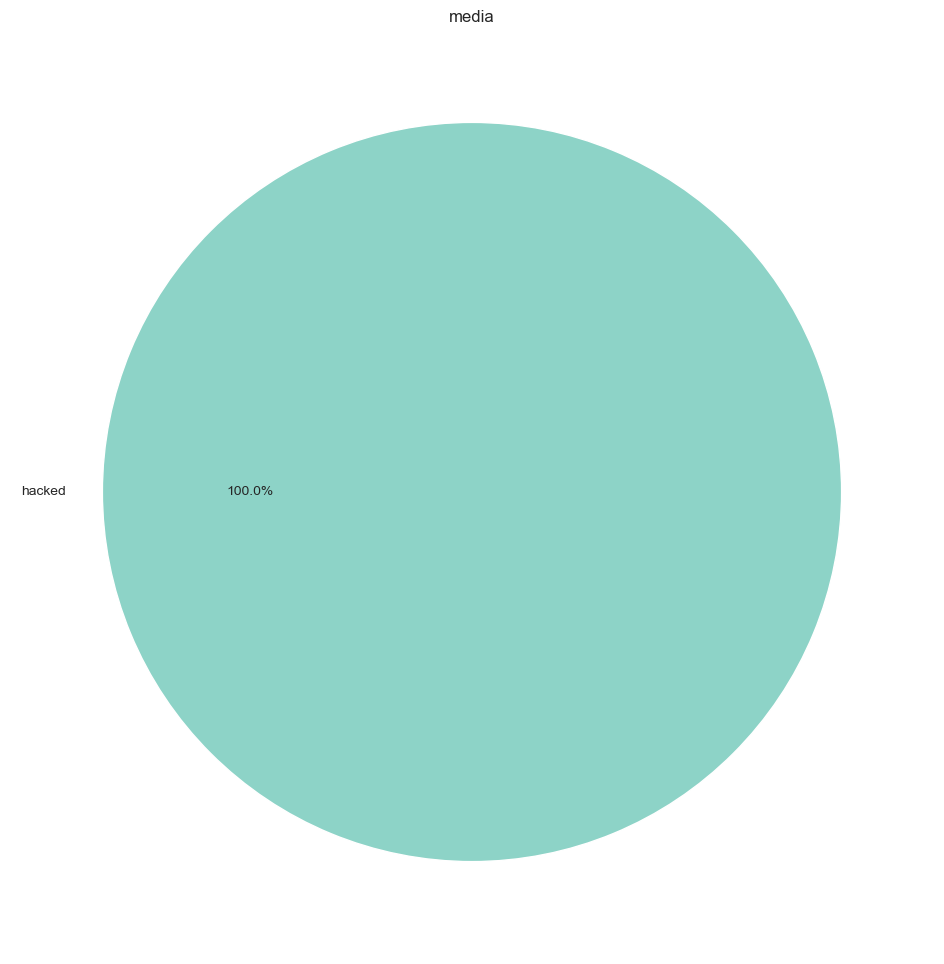

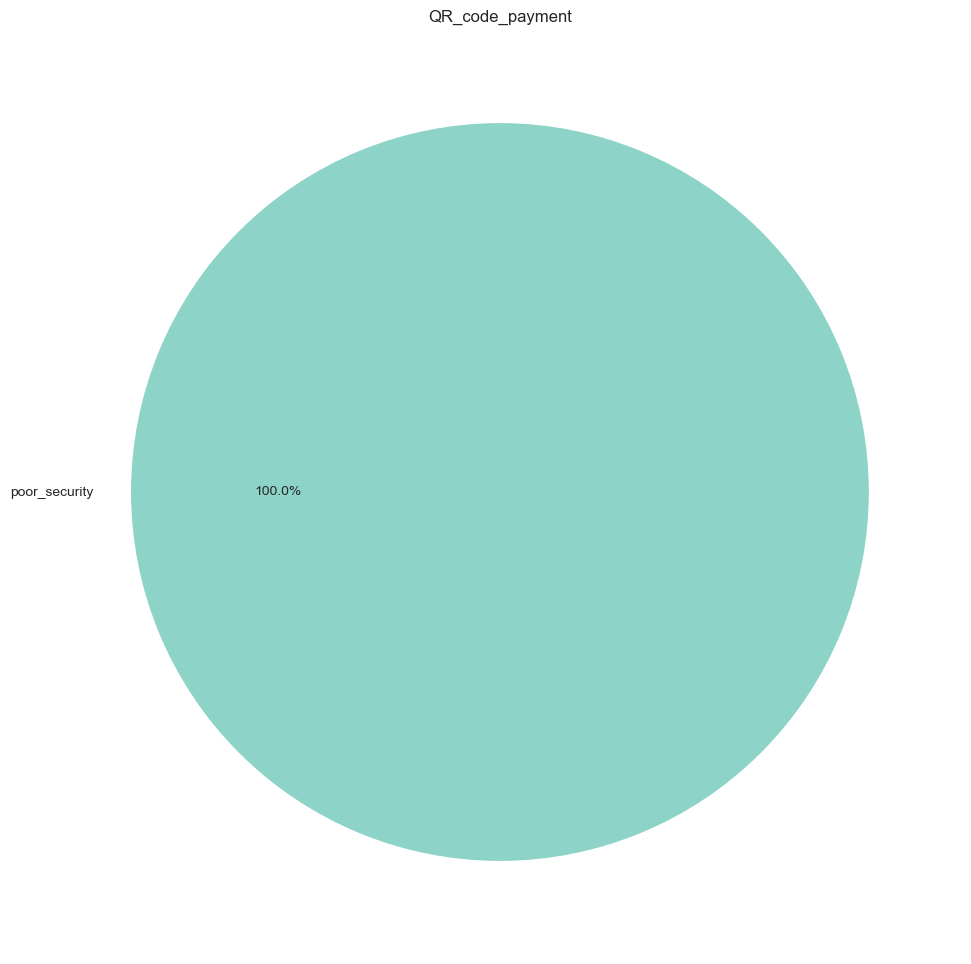

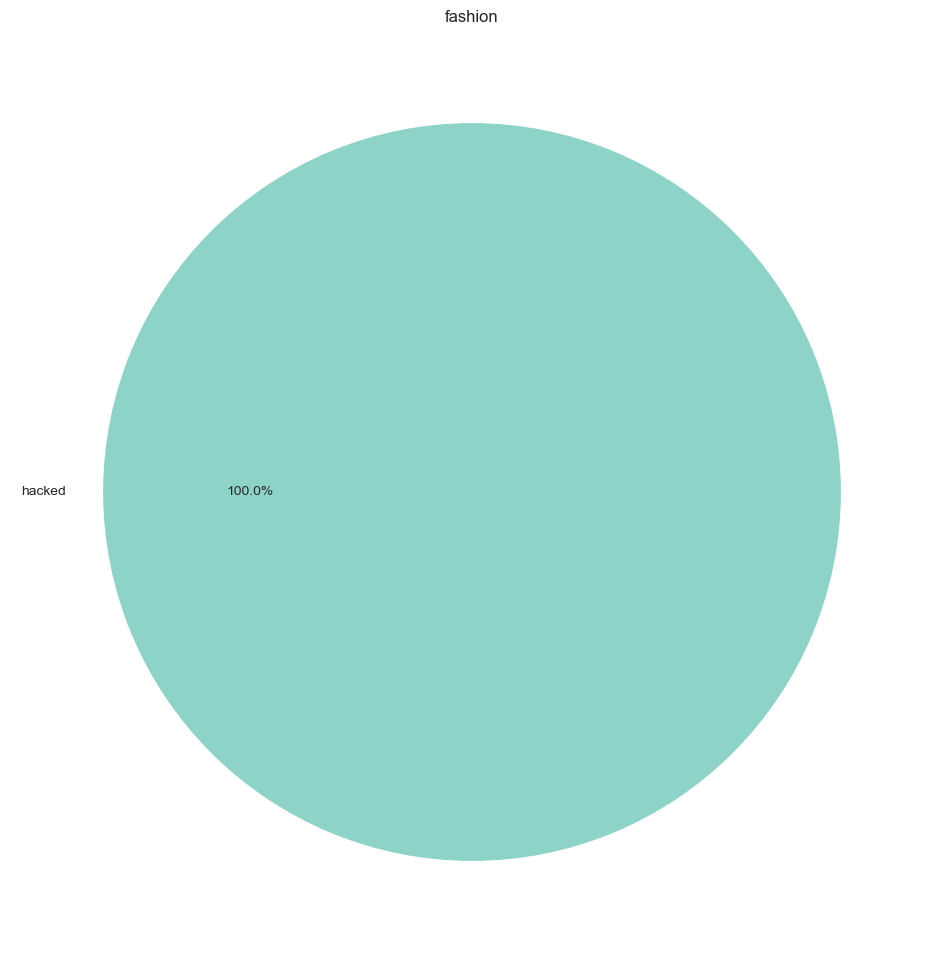

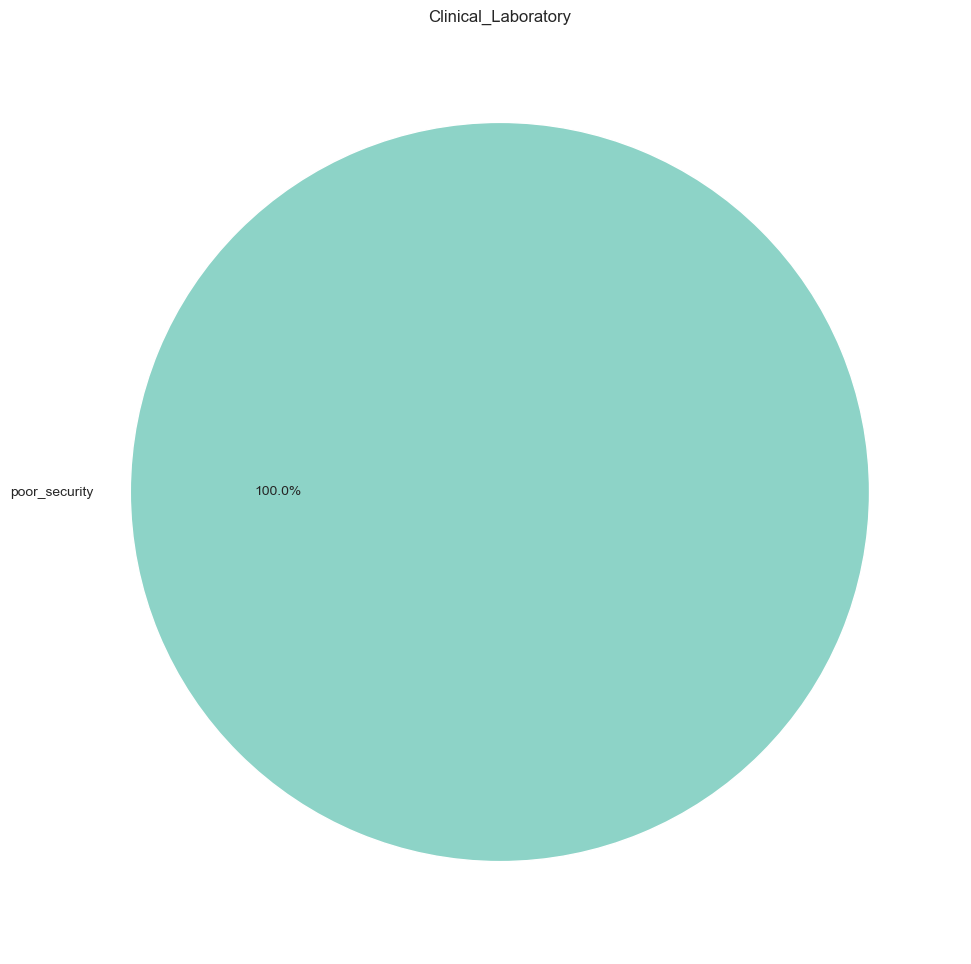

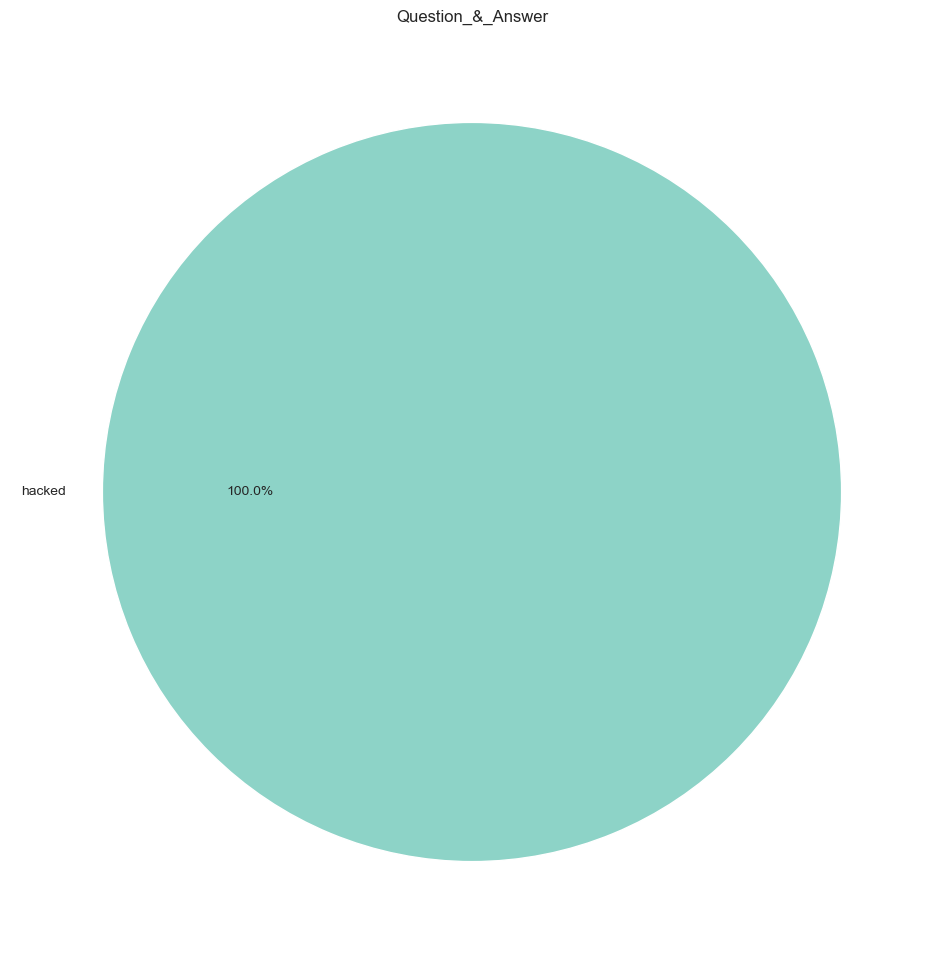

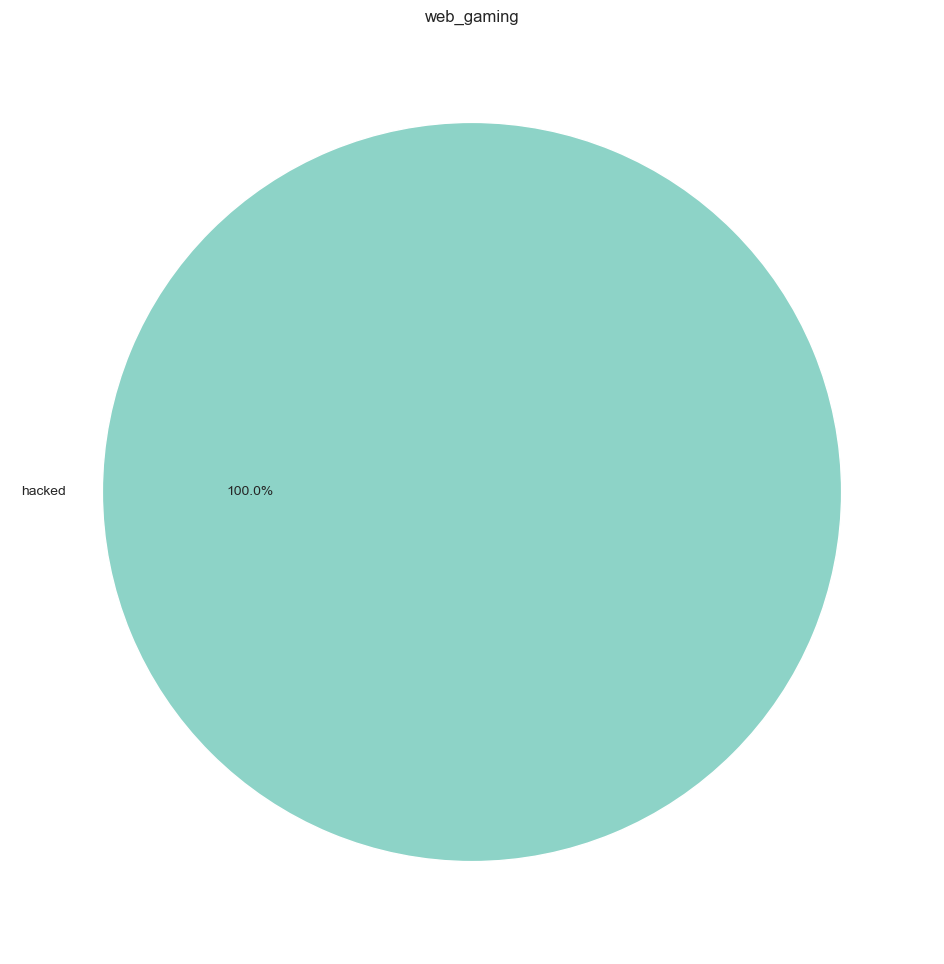

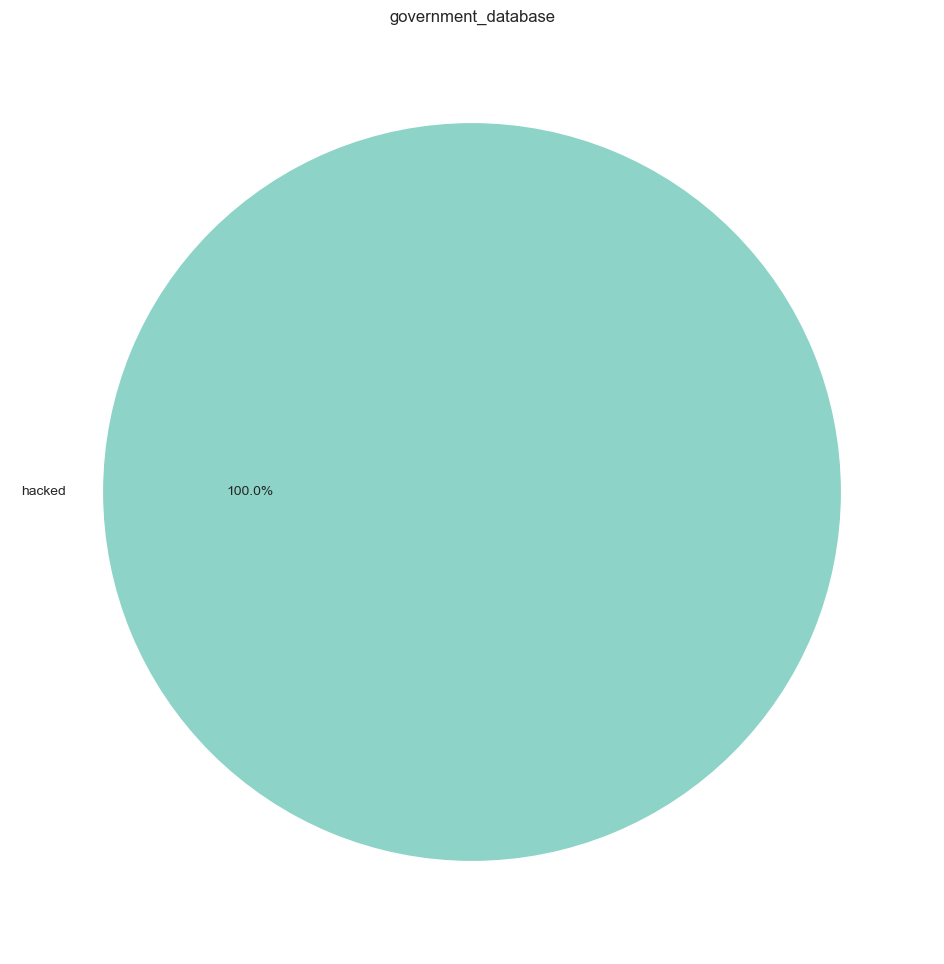

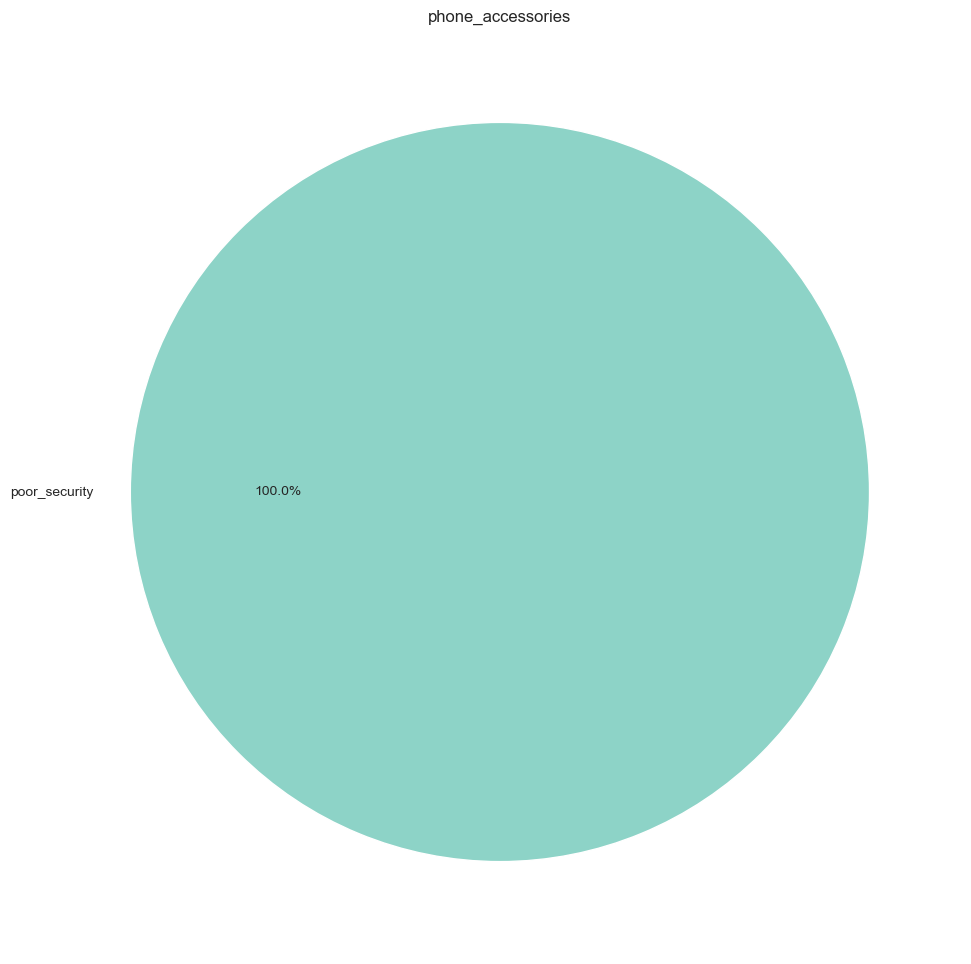

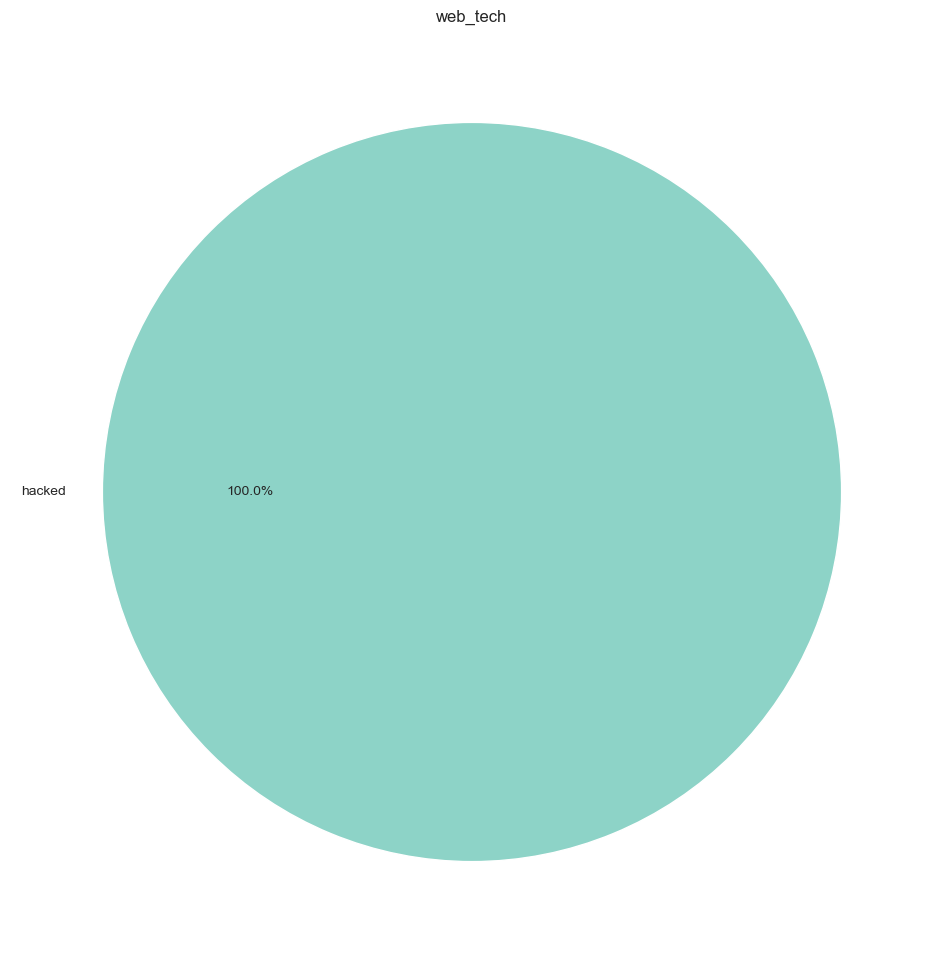

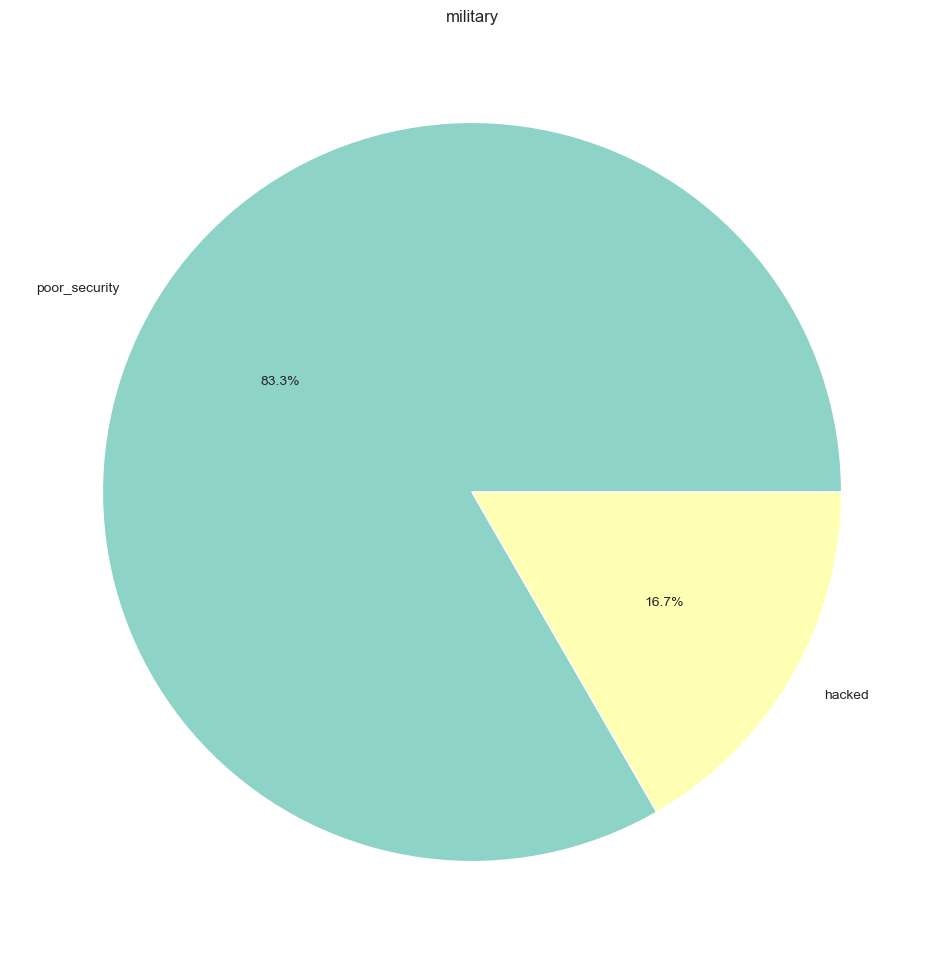

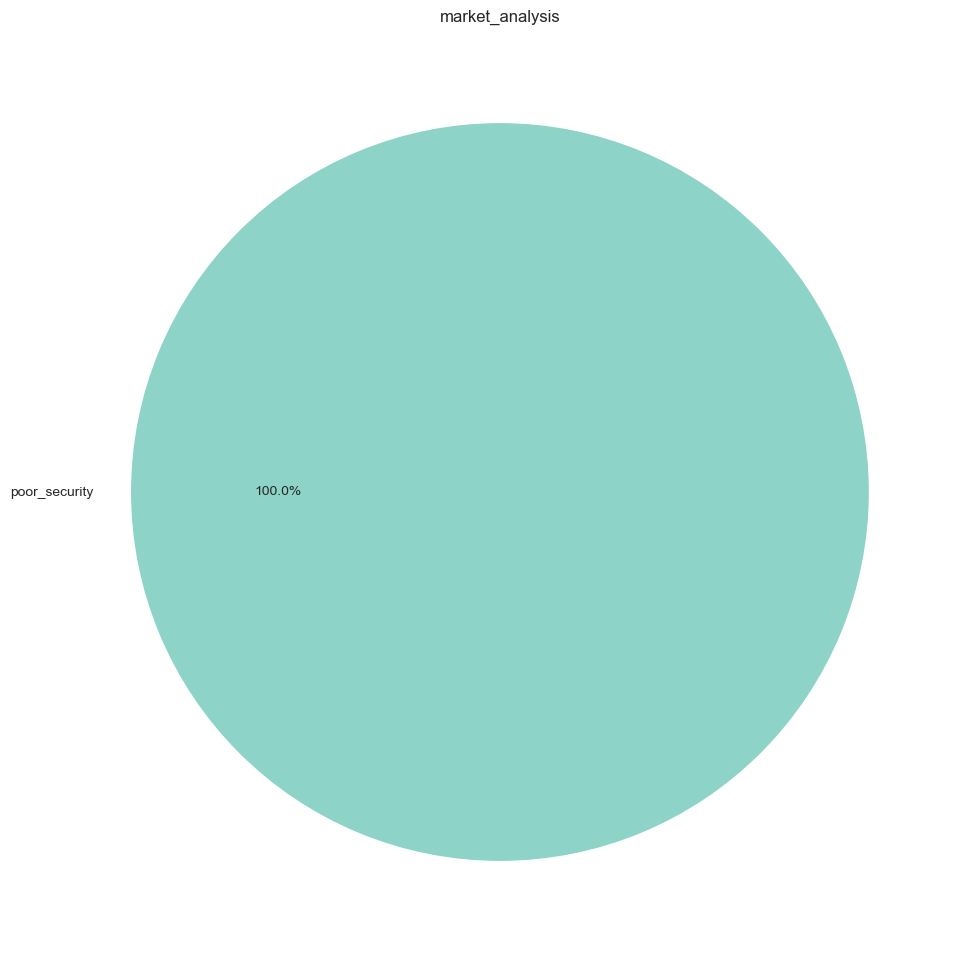

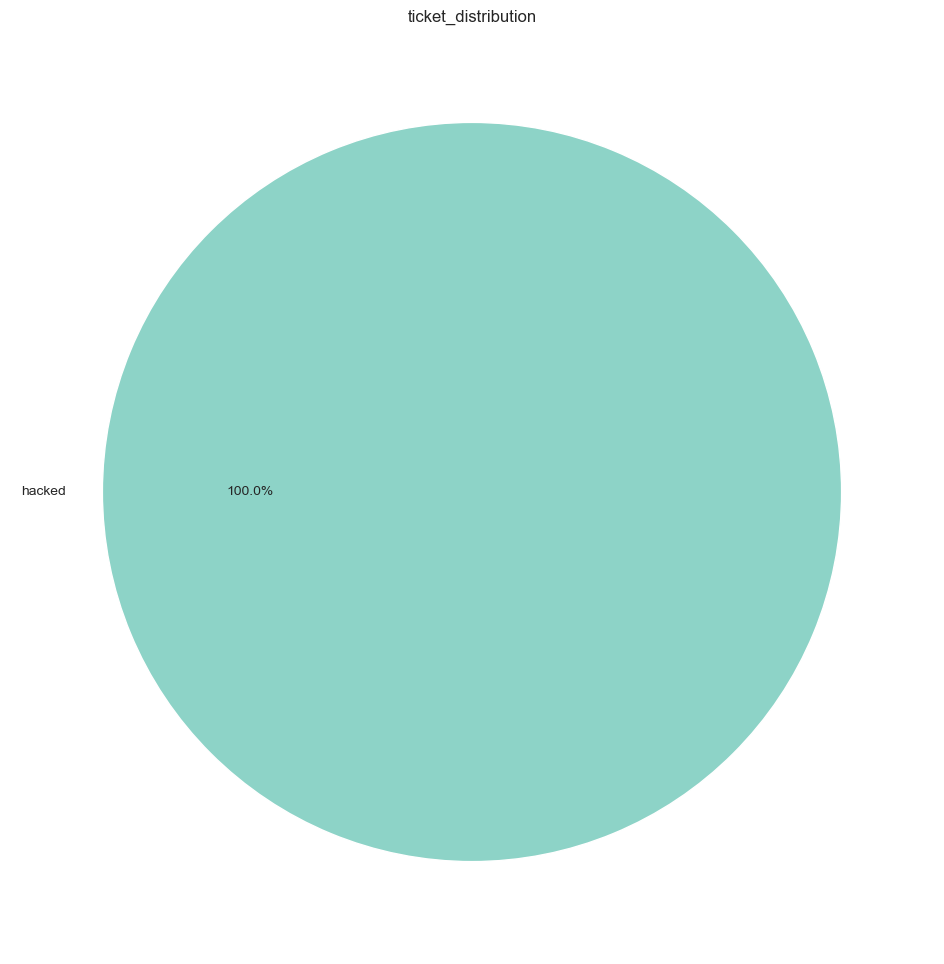

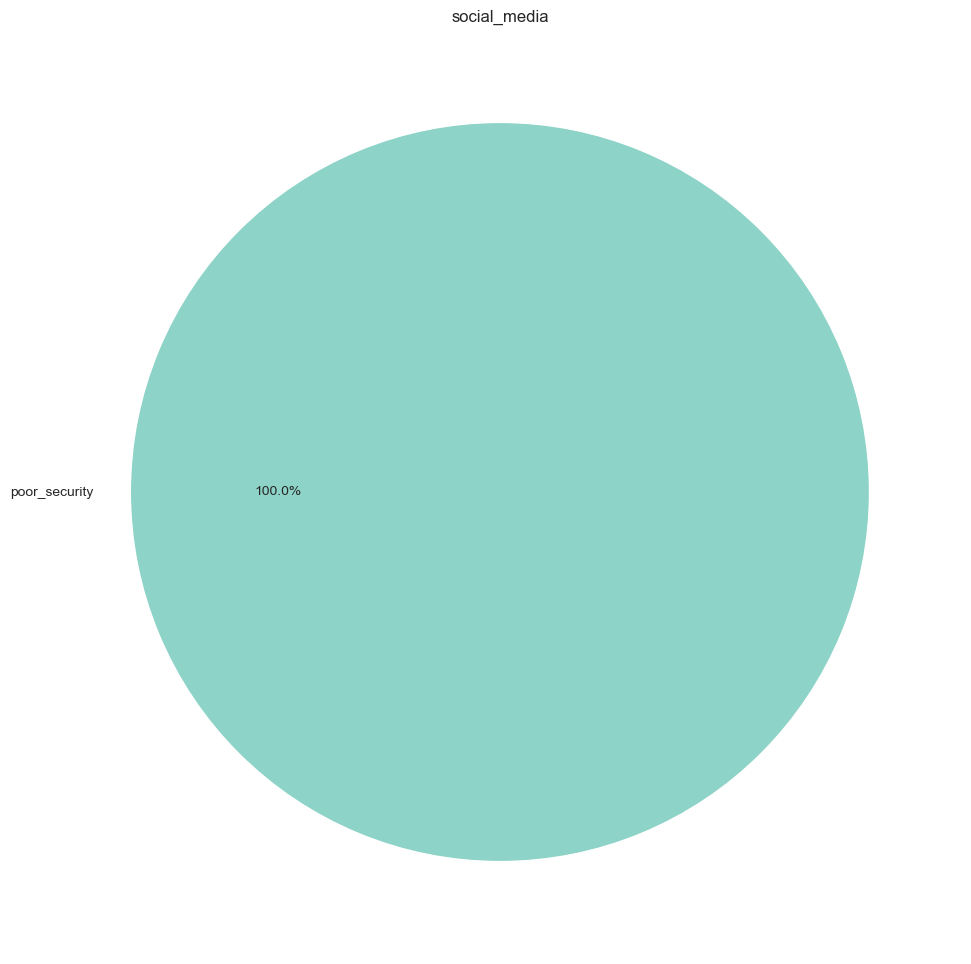

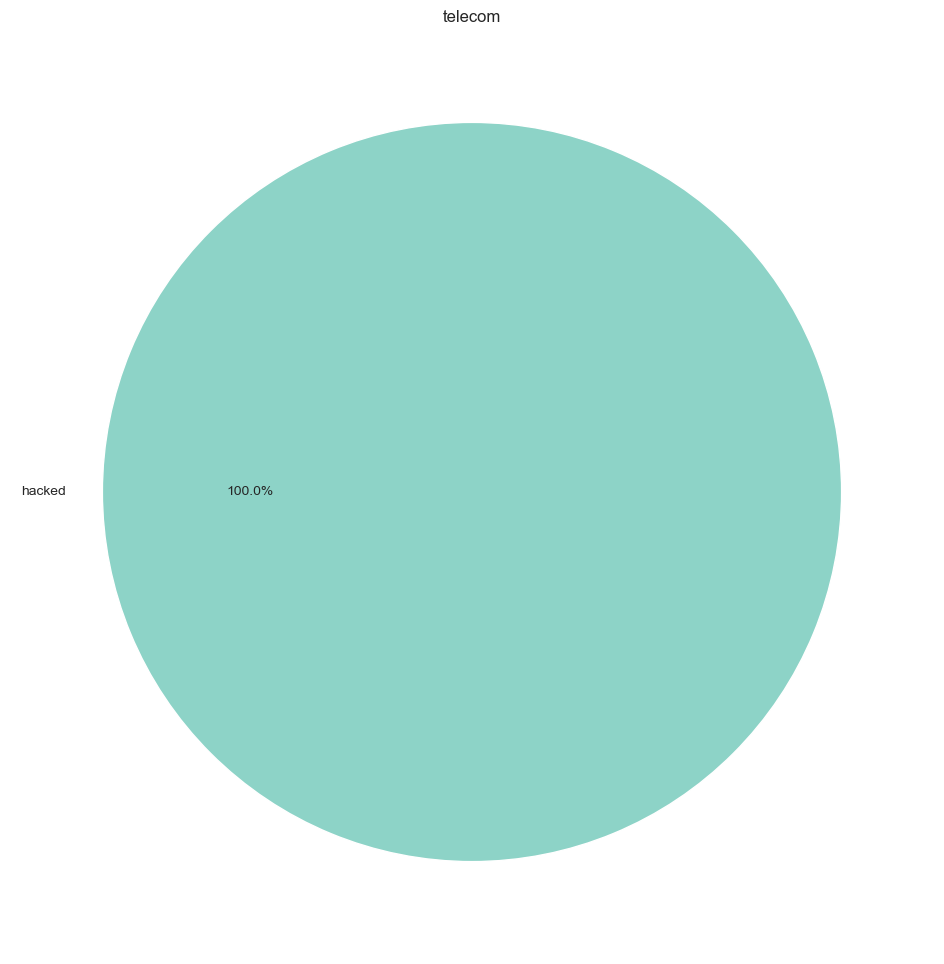

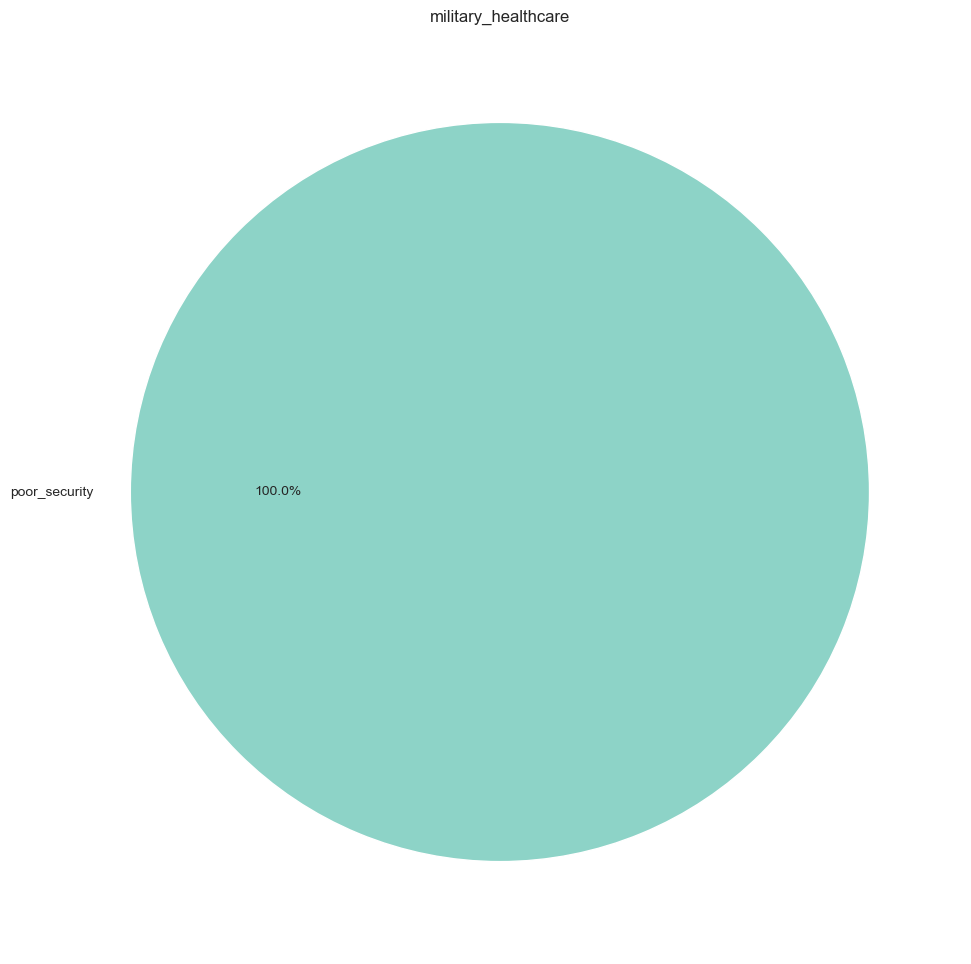

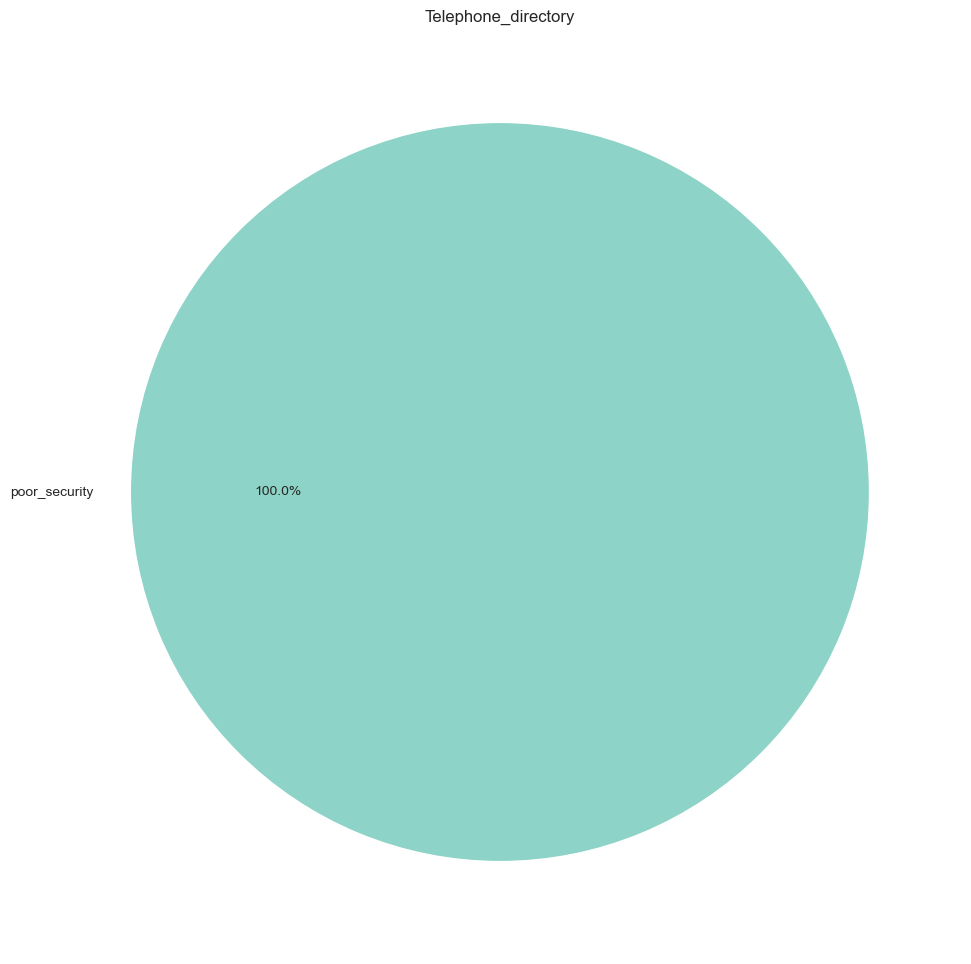

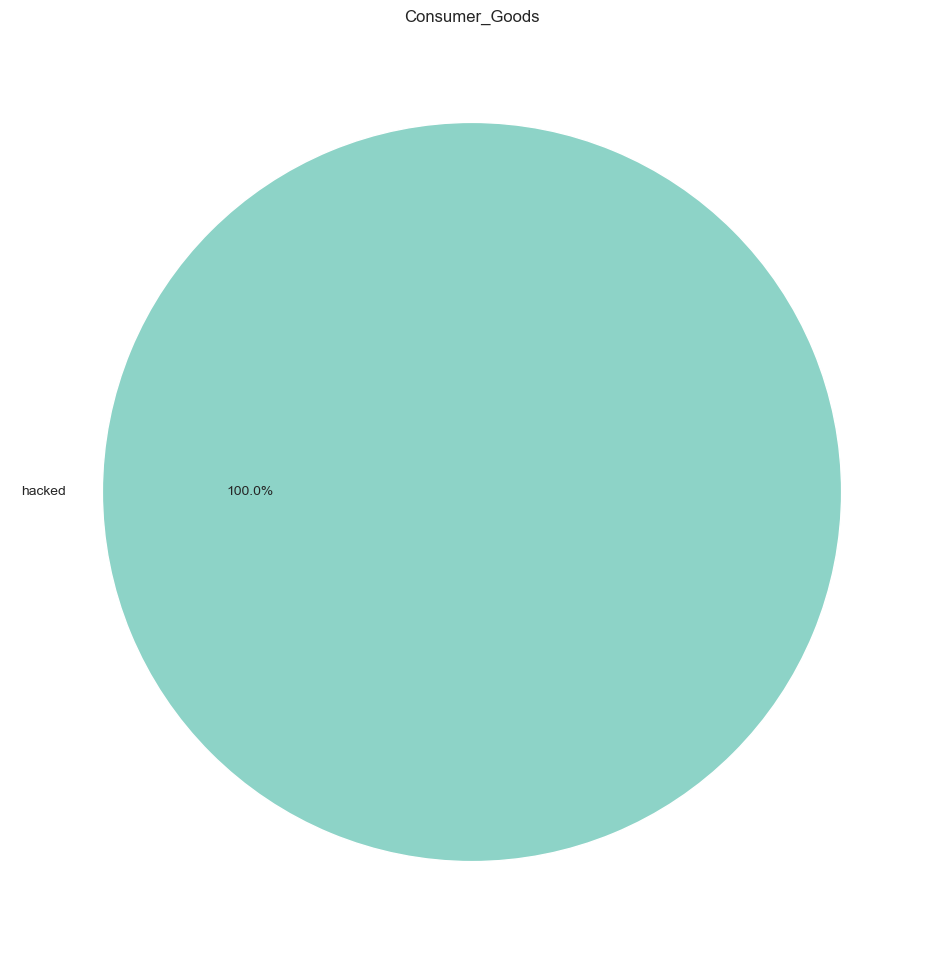

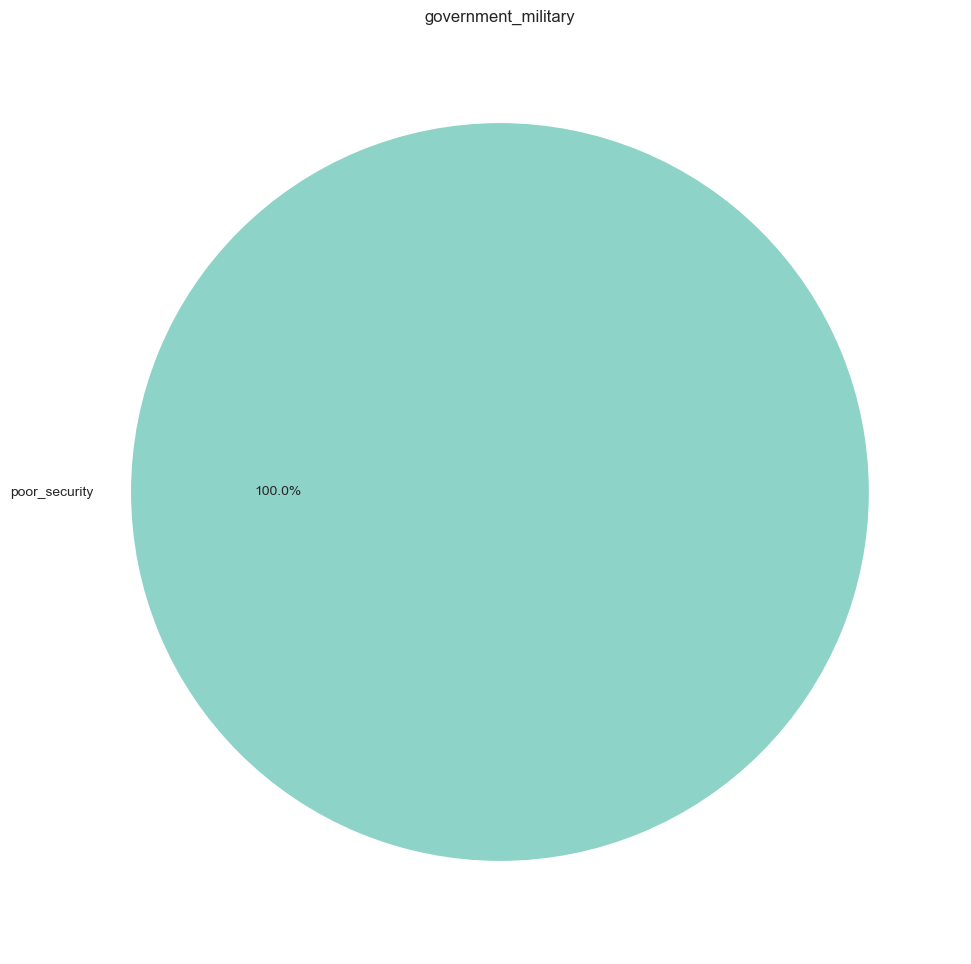

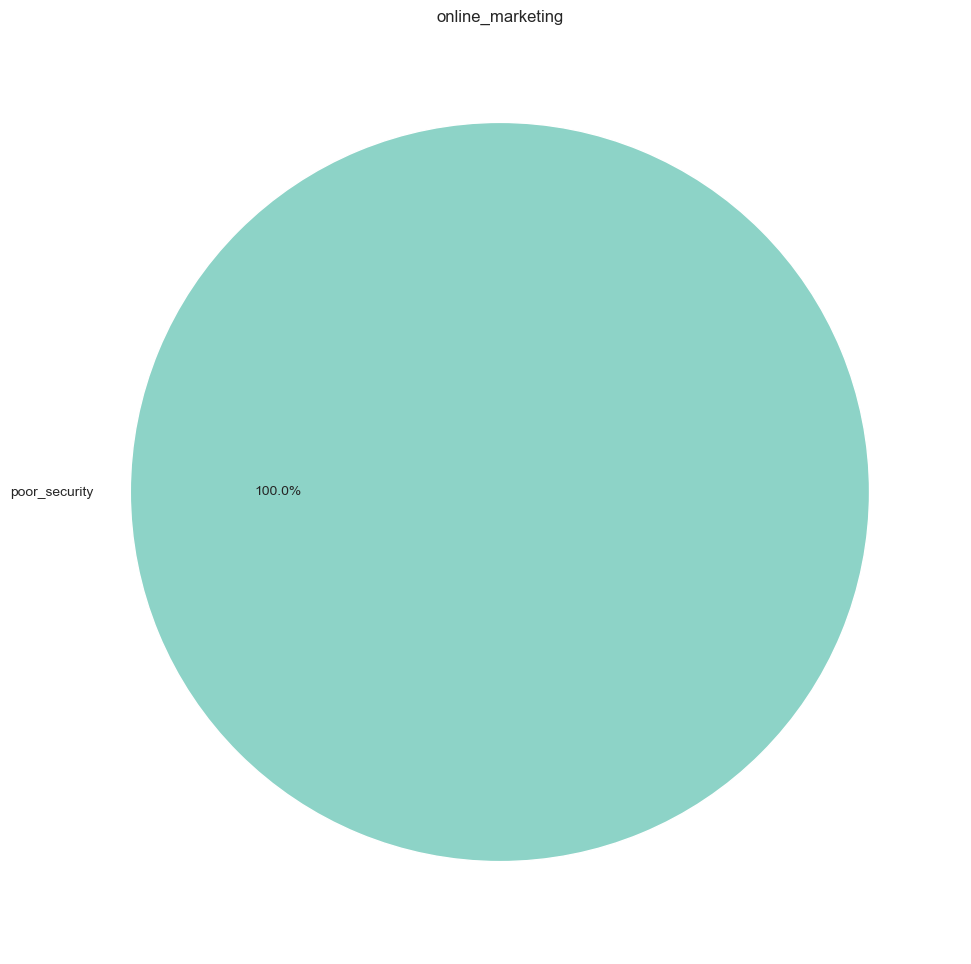

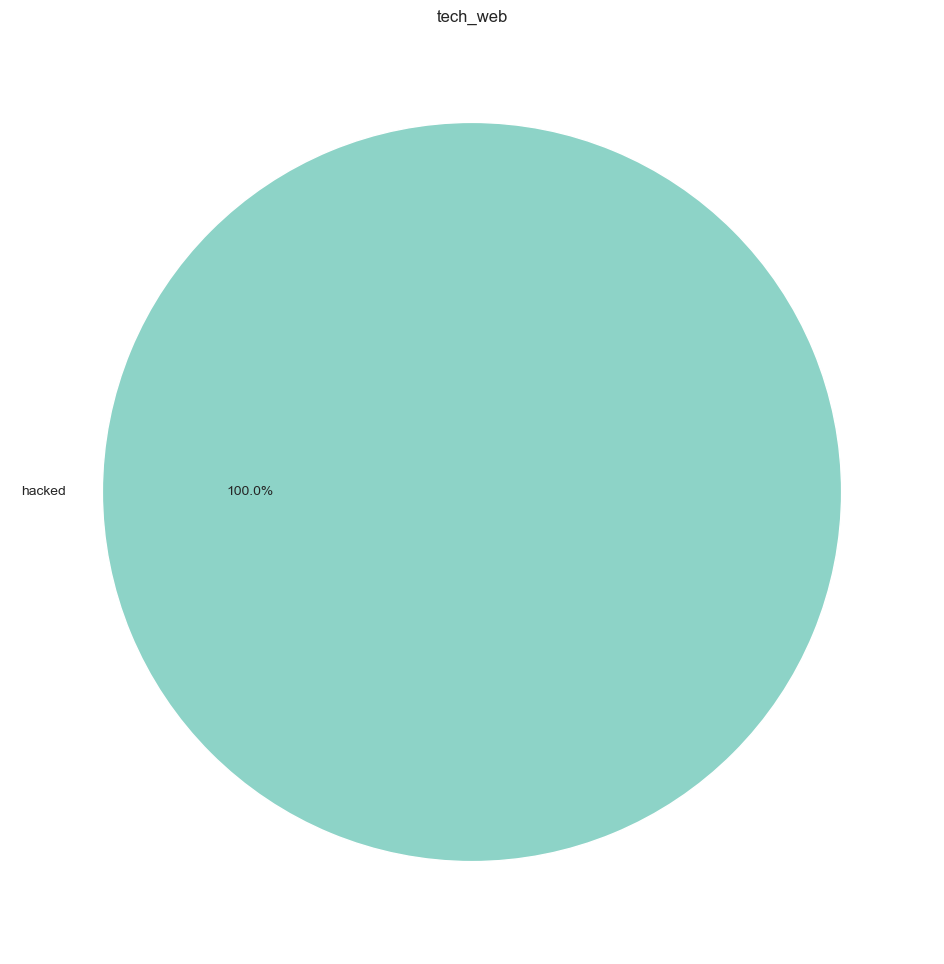

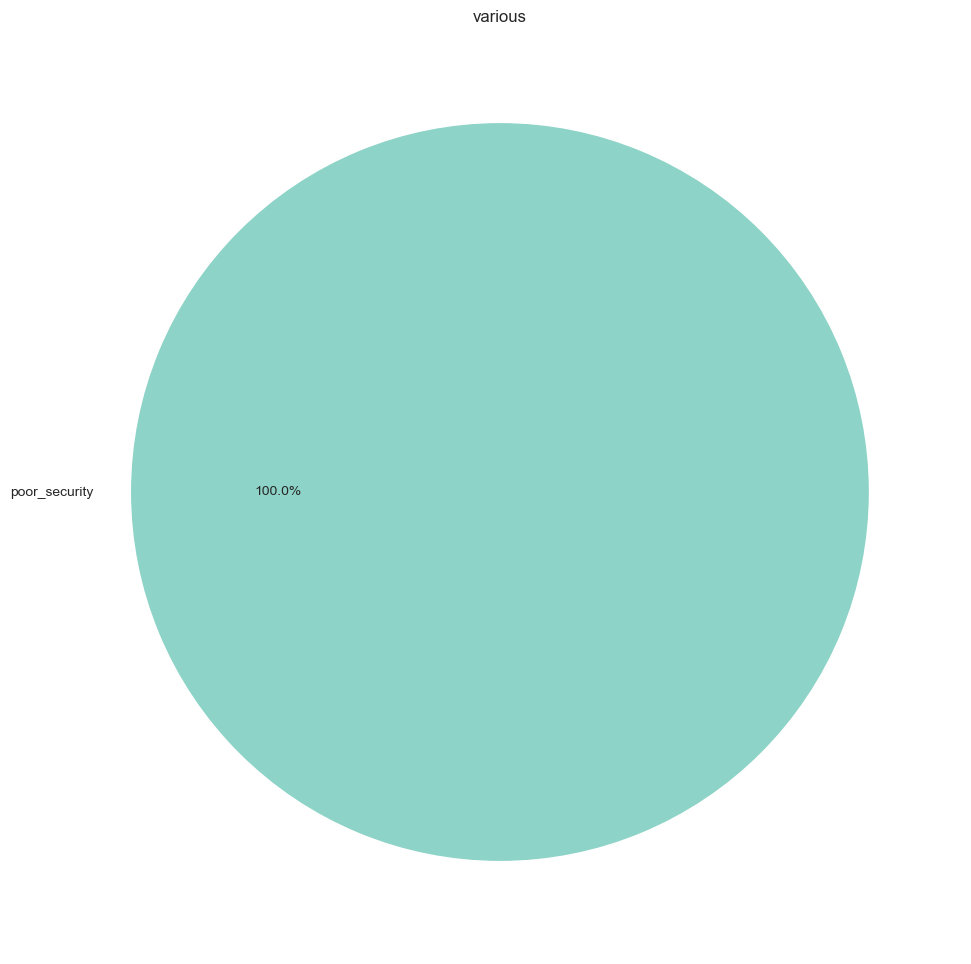

Plots saved successfully.


In [39]:
# Specify the directory to save the plots
output_directory = 'Generated_Pie_Graphs'

# Create the directory if it doesn't exist
os.makedirs(output_directory, exist_ok=True)
organization_types = df_class['Organization_type'].unique()
# Iterate over the organization types and create a pie chart for each
for org_type in organization_types:
    # Filter the data for the current organization type
    org_data = df_class[df_class['Organization_type'] == org_type]
    
    # Get the unique methods for the current organization type
    methods = org_data['Method'].unique()
    
    # Get the counts for each method
    method_counts = org_data['Method'].value_counts()
    
    # Generate a list of colors for the pie chart
    colors = plt.cm.Set3(range(len(methods)))
    
    # Create the pie chart
    plt.figure(figsize=(12, 12))
    plt.pie(method_counts, labels=methods, colors=colors, autopct='%1.1f%%')
    plt.title(org_type)
    
    # Save the plot as a .png file in the specified directory
    output_filename = os.path.join(output_directory, f'{org_type}_breach_causes.png')
    plt.savefig(output_filename)
    plt.show()
    # Close the current plot to free up resources for the next iteration
    plt.close()

print("Plots saved successfully.")

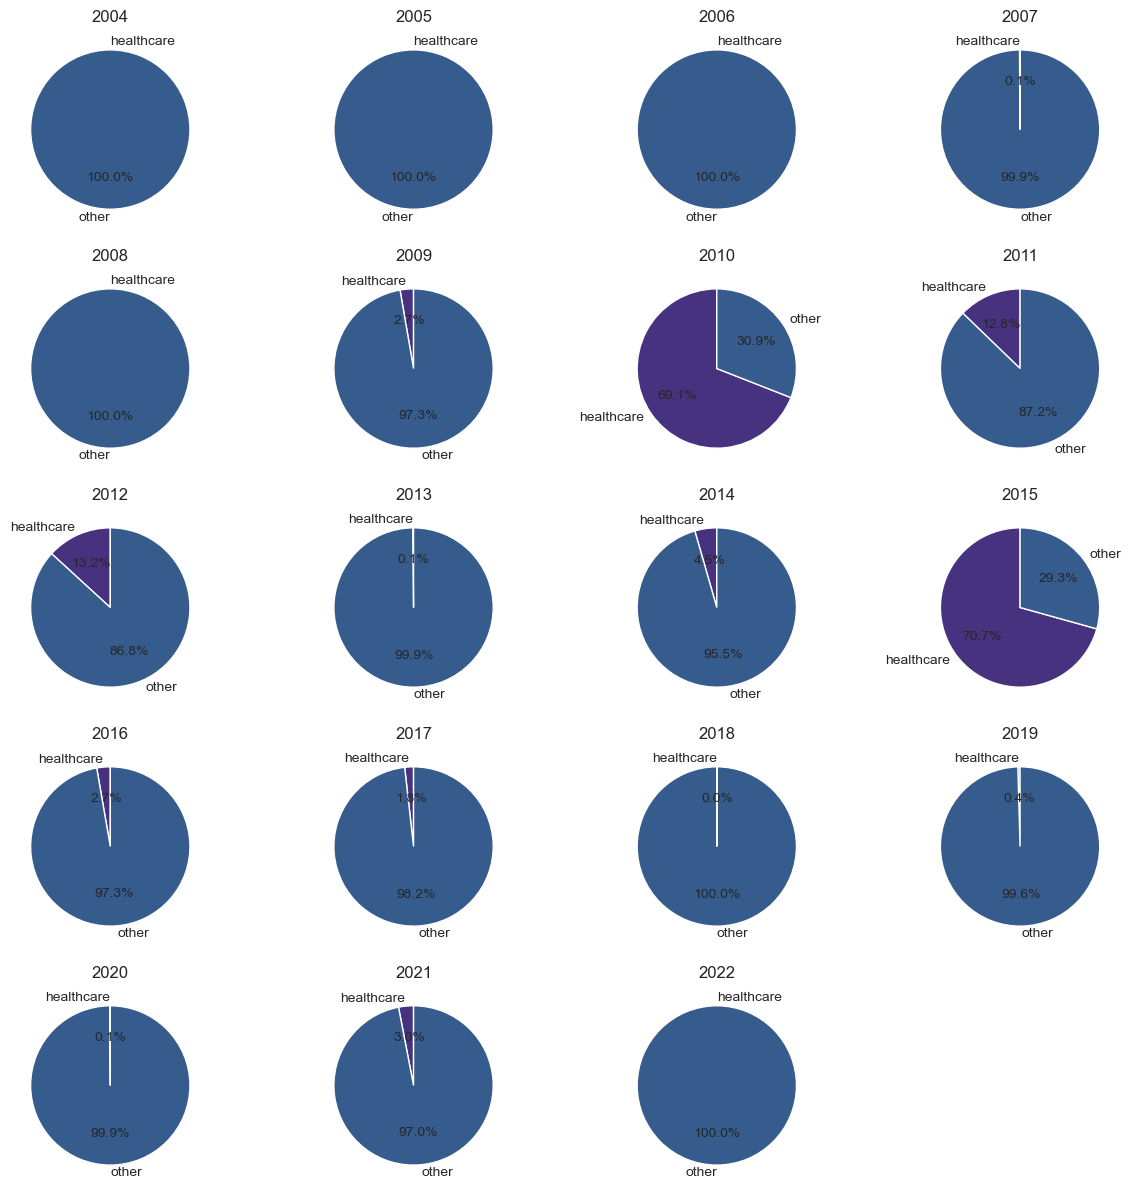

In [40]:


# Grouping the data by year and industry and summing the 'Records' column
records_by_year_and_industry = df_vis.groupby(['Year', 'Organization_type'])['Records'].sum().unstack()

# Finding the top 20 industries based on total records
top_20_industries = records_by_year_and_industry.sum().sort_values(ascending=False).head(13).index

# Filtering the DataFrame to include all industries and filling NaN values with 0
records_by_year_and_industry_all = records_by_year_and_industry.fillna(0)

# Create a consolidated image for all pie charts
plt.figure(figsize=(15, 15))

# Create subplots based on the number of years
num_years = len(records_by_year_and_industry_all.index)
num_cols = 4 
num_rows = (num_years + num_cols - 1) // num_cols


for i, year in enumerate(records_by_year_and_industry_all.index, start=1):
    data_for_year = records_by_year_and_industry_all.loc[year]

    # Calculate the percentage of records lost in the healthcare industry and the rest
    #the total number of records lost that year where "Organization type == healthcare"
    healthcare_sum = data_for_year.groupby('Organization_type').sum()['healthcare']
    healthcare_percentage = healthcare_sum / data_for_year.sum()
    other_percentage = 1 - healthcare_percentage

    # Create subplots
    plt.subplot(num_rows, num_cols, i)
    plt.pie([healthcare_percentage, other_percentage], labels=['healthcare', 'other'],
            autopct=lambda p: '{:.1f}%'.format(p) if p > 0 else '',
            startangle=90)
    plt.title(f"{year}")

plt.savefig('visualization_graphs/healthcare_comparison.png')
plt.show()
#this will show how healthcare graphs compares to the rest

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

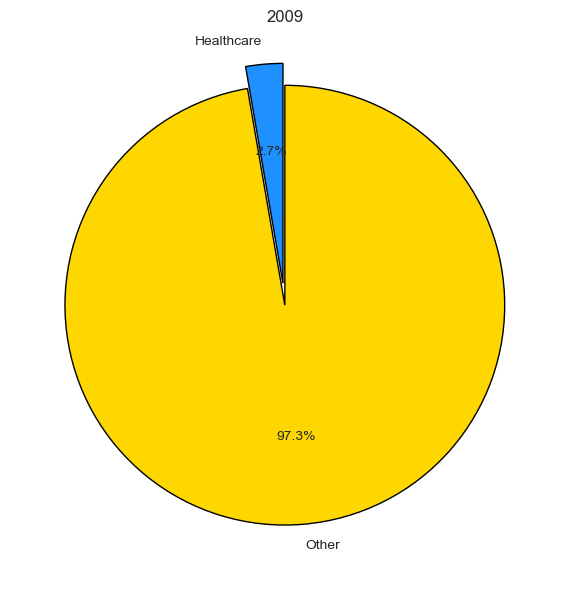

3274609.0


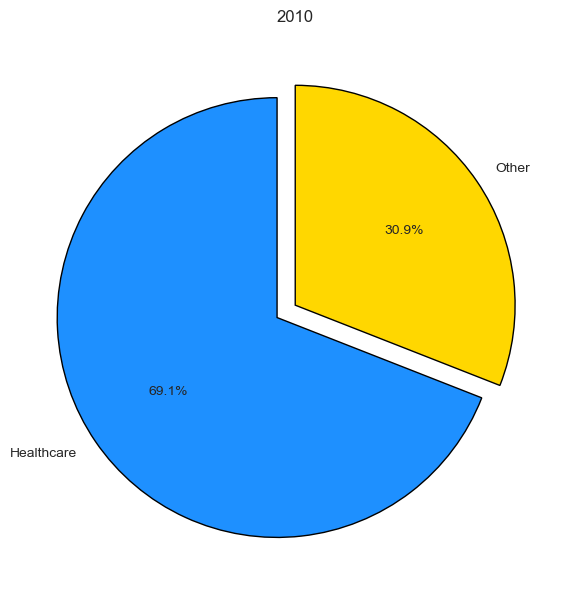

4060476.0


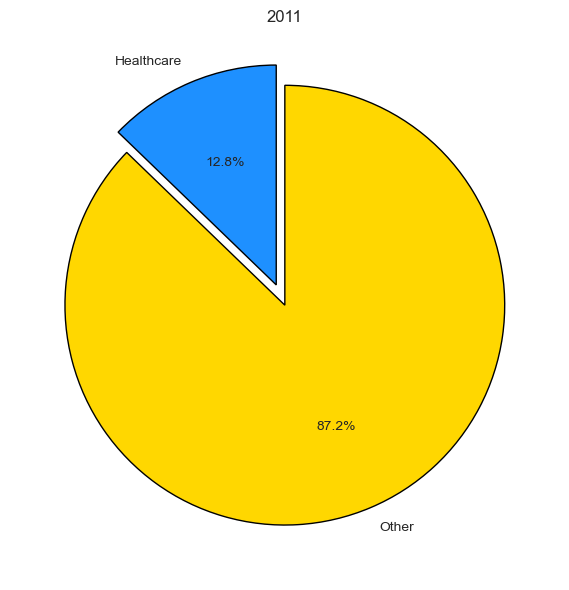

16815406.0


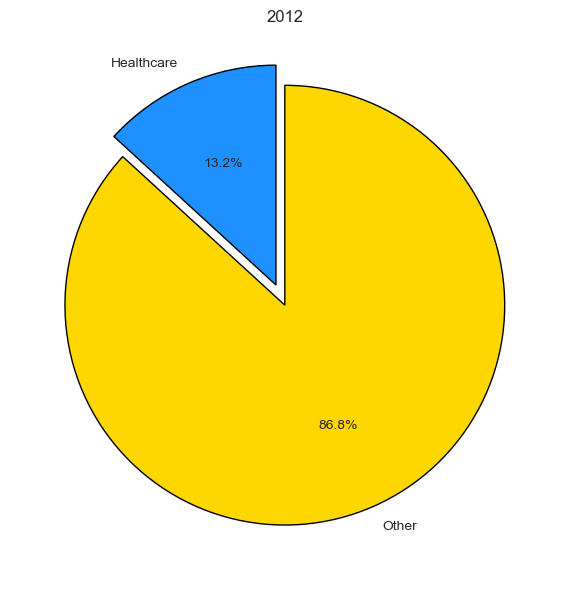

6715000.0


<Figure size 600x600 with 0 Axes>

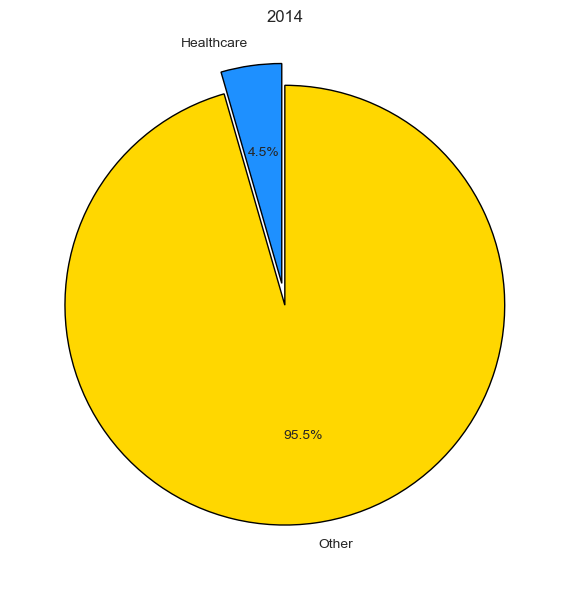

4500000.0


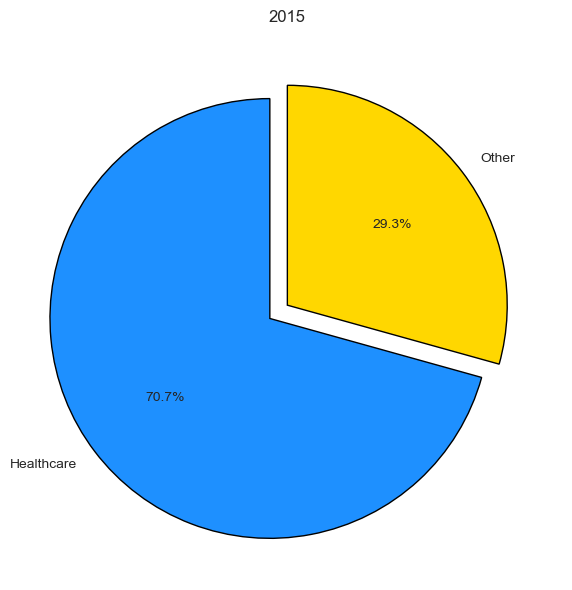

110500000.0


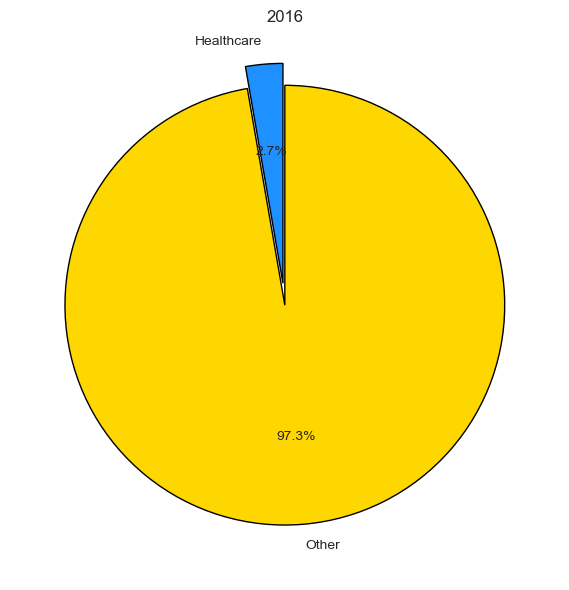

2206700.0


<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

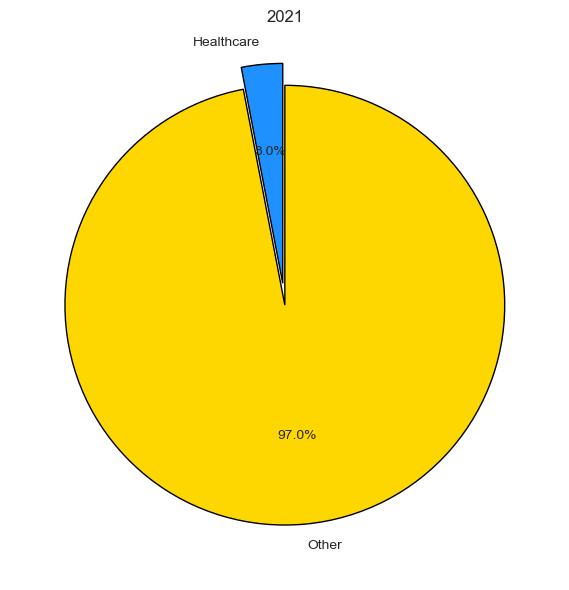

1847000.0


<Figure size 600x600 with 0 Axes>

In [41]:
# Grouping the data by year and industry and summing the 'Records' column
#declare the output directory
output_directory = 'Generated_Pie_Graphs'
records_by_year_and_industry = df_vis.groupby(['Year', 'Organization_type'])['Records'].sum().unstack()

# Finding the top 20 industries based on total records
top_20_industries = records_by_year_and_industry.sum().sort_values(ascending=False).head(13).index

# Filtering the DataFrame to include all industries and filling NaN values with 0
records_by_year_and_industry_all = records_by_year_and_industry.fillna(0)
wp = { 'linewidth' : 1, 'edgecolor' : "black" }
# Creating explode data
explode = (0.1, 0.0)
# Create subplots for each year
for i, year in enumerate(records_by_year_and_industry_all.index, start=1):
    # Create a separate figure for each year
    plt.figure(figsize=(6, 6))

    data_for_year = records_by_year_and_industry_all.loc[year]

    # Calculate the percentage of records lost in the healthcare industry and the rest
    # the total number of records lost that year where "Organization type == healthcare"
    healthcare_sum = data_for_year.groupby('Organization_type').sum().get('healthcare', 0)
    healthcare_percentage = healthcare_sum / data_for_year.sum()
    if healthcare_percentage > 0.02:
        
        other_percentage = 1 - healthcare_percentage

        # Create subplots
        plt.pie([healthcare_percentage, other_percentage], labels=['Healthcare', 'Other'],
                autopct=lambda p: '{:.1f}%'.format(p) if p > 0 else '', wedgeprops=wp, explode = explode,
                colors = ['dodgerblue', 'gold'],
                startangle=90)
        plt.title(f"{year}")
        output_filename = os.path.join(output_directory, f'{year}_comparison.png')  # this will join the directory and name of the newly created files

        # Adjust layout
        plt.tight_layout()
        #also save the graphs onto generated graphs
        plt.savefig(output_filename)
        plt.show()
        print(healthcare_sum)

This marks the end of the data visualization part.

Now we will begin the part of Label Encoding.

In [42]:
df_class.dtypes   # the same columns needs to be dropped here as well

Entity                object
Year                   int32
Records              float64
Method                object
Organization_type     object
dtype: object

In [43]:
df_vis.dtypes   # as we can see, the Organization type changed from Object --> integer datatype

Entity                object
Year                   int32
Records              float64
Method                object
Organization_type     object
dtype: object

In [44]:
# observe the label frequency, to gain an understanding of outliers and inlier values
df_vis['Organization_type'].value_counts()    # some values to note: 7 repeats 13 times, 18 repeats 38  times, 23 repeats 12 times, 25 repeats 30 times, 30 repeats 47 times, 49 repeats 27 times.

healthcare                                                                  46
government                                                                  27
retail                                                                      21
tech                                                                        14
academic                                                                    12
telecoms                                                                    12
gaming                                                                      10
social_network                                                               8
military                                                                     6
transport                                                                    5
government_healthcare                                                        4
energy                                                                       4
hotel                                               

In [45]:
print(df_vis['Method'].unique())  # we will also need to perform label encoding on the method section
df_vis['Method'].value_counts()   # to get a general idea of the distributions

['hacked' 'poor_security' 'stolen_media' 'accidental_breach' 'inside_job']


hacked               107
poor_security         48
stolen_media          42
accidental_breach     16
inside_job            12
Name: Method, dtype: int64

In [46]:
print(df_class['Method'].unique())
df_class['Method'].value_counts()  # a more even distribution of hacked vs poor_security

['hacked' 'poor_security']


hacked           119
poor_security    106
Name: Method, dtype: int64

In [47]:
""# seems like the method column contains certain NaN values and certain Unknown values, we will need to determine whether we replace such values or drop them in its entirety
df_vis['Method'].value_counts()     

hacked               107
poor_security         48
stolen_media          42
accidental_breach     16
inside_job            12
Name: Method, dtype: int64

In [48]:
#check which columns have null/unknoown values
null_mask = df_vis.isnull().any(axis=1)
null_rows=df_vis[null_mask]

print(null_rows)  # it seems every column have null values
df_vis.dropna(axis=0, inplace=True)  # drop any rows that may contain null values
df_class.dropna(axis=0, inplace=True)  # drop any rows that may contain null values
df_vis.isnull().all() 

Empty DataFrame
Columns: [Entity, Year, Records, Method, Organization_type]
Index: []


Entity               False
Year                 False
Records              False
Method               False
Organization_type    False
dtype: bool

In [49]:
#drop sources and index
df_vis.drop(columns=['Index', 'Sources'], axis=1, inplace=True)     # drop the index and sources
df_vis.drop(352)  # this will drop the outlier value

KeyError: "['Index', 'Sources'] not found in axis"

In [ ]:
df_vis['Method'].value_counts()  #reobserve to see if any changes took place, no changes has been taken place, this was just to verify if the data has been fully preprocessed or not

hacked               106
poor_security         48
stolen_media          42
accidental_breach     16
inside_job            12
Name: Method, dtype: int64

In [ ]:
df_class['Method'].value_counts()    # reobserved to see if any changes took place, as we can see, there has been none, this was mainly to verify if the data has been fully preprocessed or not

hacked           118
poor_security    106
Name: Method, dtype: int64

In [ ]:
df_vis

,Entity,Year,Records,Method,Organization_type
0,21st_Century_Oncology,2016,2200000.0,hacked,healthcare
1,500px,2020,14870304.0,hacked,social_networking
2,Accendo_Insurance_Co.,2020,175350.0,poor_security,healthcare
3,Adobe,2013,152000000.0,hacked,tech
4,Adobe,2019,7500000.0,poor_security,tech
...,...,...,...,...,...
313,US_Medicaid,2012,390000.0,hacked,government_healthcare
314,Tricare,2011,2450716.0,stolen_media,military_healthcare
315,U.S._Department_of_Veteran_Affairs,2006,13250000.0,stolen_media,government_military
316,Virginia_Department_of_Health,2009,4128689.0,hacked,government_healthcare


In [57]:
le = LabelEncoder()  #perform label encoding on the organization_type, the copy of df_vis

# implement label encoding on the Organization type column
le.fit(df_vis['Organization_type'])   # fit the data we want to train the encoder on
df_vis['Organization_type'] = le.transform(df_vis['Organization_type'])  # implement label encoding on Organization_type, and Method

le.fit(df_vis['Method'])  # fit the label encoder on the Method model
df_vis['Method'] = le.transform(df_vis['Method'])
# observe how the column 'Organization_type' and 'Method' has changed

le.fit(df_vis['Entity'])
df_vis['Entity'] = le.transform(df_vis['Entity'])

print(df_vis['Organization_type'].unique())
print(df_vis['Method'].unique())
print(df_vis['Entity'].unique())
df_vis.head()

[23 44 46  6 50 53 16 47 51 40 10  8 18 15 11  7 24 22 30 39 13  9 43 14
 36 25 26 45 41 27  5 33 38 20 56 35 17 29  2 12  0  3 55 19 37 57 31 28
 52 42 49 32  4  1 21 34 48 54]
[1 3 4 0 2]
[  0   1   4   5   6   7   8  10   9  11  12  13  16  14  15   3  17  19
  20  21  22  23  24  25  18  26  27  28  30  29  32  33  34  35  36 123
  31  37  38  39  41  42 178 174  40  43  44  45  46  47  48  49  50  51
  52  53  54  55  56  57  58 192  60  61  62  63  59  64  65  66  67  68
  69  70  71  72  74  75  76  77  78  79  80  81  82  84  85  86  83  88
  87  89  90  91  92 179  93  94  95  96  97  98  99 101 100 102 103 104
 109 110 111 112 113 114 105 115 116 117 118 119 180 120 121 122 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 157 158 159 160 161 162 163 154
 156 155 164 165 166 181 182 173 175 176 177 185 183 186 188 187 189 190
 191 184 167 168 169 170 172 106 171 107 194 195 196 197 198 199 200 193
 201 20

,Entity,Year,Records,Method,Organization_type
0,0,2016,2200000.0,1,23
1,1,2020,14870304.0,1,44
2,4,2020,175350.0,3,23
3,5,2013,152000000.0,1,46
4,5,2019,7500000.0,3,46


In [58]:
# do the same thing with the label encoder for df_class
le.fit(df_class['Organization_type'])  # fit the data for the organization type 
df_class['Organization_type'] = le.transform(df_class['Organization_type'])

le.fit(df_class['Method'])  # again, fit the label encoder on the method, as this will be used for our binary classification
df_class['Method'] = le.transform(df_class['Method']) 

# label encode the entity --> though it won't be that helpful
le.fit(df_class['Entity'])
df_class['Entity'] = le.transform(df_class['Entity'])

#observe how columns 'Orgnaization_type' and 'Method' has changed
print(df_class['Organization_type'].unique())
print(df_class['Method'].unique())
print(df_class['Entity'].unique())
df_class.head()
#successfully encoded

[23 44 46  6 50 53 16 47 51 40 10  8 18 15 11  7 24 22 30 39 13  9 43 14
 36 25 26 45 41 27  5 33 38 20 56 35 17 29  2 12  0  3 55 19 37 57 31 28
 52 42 49 32  4  1 21 34 48 54]
[0 1]
[  0   1   4   5   6   7   8  10   9  11  12  13  16  14  15   3  17  19
  20  21  22  23  24  25  18  26  27  28  30  29  32  33  34  35  36 123
  31  37  38  39  41  42 178 174  40  43  44  45  46  47  48  49  50  51
  52  53  54  55  56  57  58 192  60  61  62  63  59  64  65  66  67  68
  69  70  71  72  74  75  76  77  78  79  80  81  82  84  85  86  83  88
  87  89  90  91  92 179  93  94  95  96  97  98  99 101 100 102 103 104
 109 110 111 112 113 114 105 115 116 117 118 119 180 120 121 122 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 157 158 159 160 161 162 163 154
 156 155 164 165 166 181 182 173 175 176 177 185 183 186 188 187 189 190
 191 184 167 168 169 170 172 106 171 107 194 195 196 197 198 199 200 193
 201 202 203 

,Entity,Year,Records,Method,Organization_type
0,0,2016,2200000.0,0,23
1,1,2020,14870304.0,0,44
2,4,2020,175350.0,1,23
3,5,2013,152000000.0,0,46
4,5,2019,7500000.0,1,46


In [63]:
#change all the datatype into numerical values
print(df_vis.dtypes)
print()
print(df_class.dtypes)

Entity                 int32
Year                   int32
Records              float64
Method                 int32
Organization_type      int32
dtype: object

Entity                 int32
Year                   int32
Records              float64
Method                 int32
Organization_type      int32
dtype: object


In [60]:
#pd.to_numeric(df_class['Entity'])
#pd.to_numeric(df_class['Method'])
#pd.to_numeric(df_class['Organization_type'])

df_class

,Entity,Year,Records,Method,Organization_type
0,0,2016,2200000.0,0,23
1,1,2020,14870304.0,0,44
2,4,2020,175350.0,1,23
3,5,2013,152000000.0,0,46
4,5,2019,7500000.0,1,46
...,...,...,...,...,...
314,179,2012,390000.0,0,20
315,164,2011,2450716.0,1,32
316,170,2006,13250000.0,1,21
317,198,2009,4128689.0,0,20


Model is ready to be trained, we will first begin with Binary Classification models.

In [86]:
#import the neccessary components
from copy import deepcopy  # this needed to be adjusted
import torch
import torch.nn as nn
import torch.optim as optim
import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

#read the dataframes --> df_vis and df_class
features1 = 'Organization_type'
features2 = ['Organization_type', 'Year']
features3 = ['Organization_type', 'Year', 'Records']
features4 = ['Organization_type', 'Year', 'Records', 'Entity']  # should have the least success rate



X1 = df_class[[features1]]
X2 = df_class[features2]
X3 = df_class[features3]
X4 = df_class[features4]
y = df_class['Method']

# split the data for features 1
X_train, X_test, y_train, y_test = train_test_split(X1, y, test_size=0.33, random_state=42)
X_train.dtypes

Organization_type    int32
dtype: object

Next, we perform data split for our first feature and labels combination for both df_vis and df_class, df_class will utilize binary classification whereas df_vis will utilize multilabel classification.

The following are the instructions for how we would go about implementing classification algorithms using sickit learn:
- Import the neccessary libraries
- Load the Data
- Split the Data into training set and testing set
- Choose a classification algorithm
- Train the model on the training set
- Evaluate the model on the testing set
- Make predictions on the new data.

Metrics used for classification models:
1. Accuracy
2. Recall
3. Log Loss
4. False Negative Rate
5. True Positive
6. Example
7. Confusion Matrix
8. AUC
9. ROC Curve
10. Conclusion
11. F1 Score
12. Precision
13. Specificity
14. True Negative

The following are the list of models from sickit learn that can be used for classification: (Based on Sickit-Learn)
- ANN MLP Classifier

In [91]:
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, log_loss, precision_score, recall_score, roc_auc_score, roc_curve
from imblearn.metrics import specificity_score
import sklearn.neural_network

#create an instance of the MLP classifier class
neural_network = sklearn.neural_network.MLPClassifier(hidden_layer_sizes=(5,60), activation='relu', solver='adam', learning_rate='constant') # mess around with the hyperparameters to see how  the model performance changes --> right now they are set to default values

#fit the model to the training data
neural_network.fit(X_train, y_train)

#predict the labels of new data
y_pred = neural_network.predict(X_test)

# Evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
logloss = log_loss(y_test, y_pred)  # Note: log_loss requires predicted probabilities, not binary predictions

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# True Positive, False Negative Rate
true_positive = conf_matrix[1, 1]
false_negative_rate = conf_matrix[1, 0] / (conf_matrix[1, 0] + conf_matrix[1, 1])

# AUC and ROC Curve
auc = roc_auc_score(y_test, y_pred)
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

# F1 Score, Precision, Specificity
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
specificity = specificity_score(y_test, y_pred, average='macro')

# True Negative
true_negative = conf_matrix[0, 0]

# Print the metrics
print("Accuracy:", accuracy)
print("Recall:", recall)
print("Log Loss:", logloss)
print("True Positive:", true_positive)
print("False Negative Rate:", false_negative_rate)
print("Confusion Matrix:")
print(conf_matrix)
print("AUC:", auc)
print("F1 Score:", f1)
print("Precision:", precision)
print("Specificity:", specificity)
print("True Negative:", true_negative)

Accuracy: 0.52
Recall: 0.0
Log Loss: 17.300953626776234
True Positive: 0
False Negative Rate: 1.0
Confusion Matrix:
[[39  0]
 [36  0]]
AUC: 0.5
F1 Score: 0.0
Precision: 0.0
Specificity: 0.5
True Negative: 39


c:\Users\dasa7\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Let us split the data with 2 features and check to see if the accuracy improved or not for the same model

In [92]:
X_train, X_test, y_train, y_test = train_test_split(X2, y, test_size=0.33, random_state=42)

#fit the model to the training data
neural_network.fit(X_train, y_train)

#predict the labels of new data
y_pred = neural_network.predict(X_test)

# Evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
logloss = log_loss(y_test, y_pred)  # Note: log_loss requires predicted probabilities, not binary predictions

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# True Positive, False Negative Rate
true_positive = conf_matrix[1, 1]
false_negative_rate = conf_matrix[1, 0] / (conf_matrix[1, 0] + conf_matrix[1, 1])

# AUC and ROC Curve
auc = roc_auc_score(y_test, y_pred)
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

# F1 Score, Precision, Specificity
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
specificity = specificity_score(y_test, y_pred, average='macro')

# True Negative
true_negative = conf_matrix[0, 0]

# Print the metrics
print("Accuracy:", accuracy)
print("Recall:", recall)
print("Log Loss:", logloss)
print("True Positive:", true_positive)
print("False Negative Rate:", false_negative_rate)
print("Confusion Matrix:")
print(conf_matrix)
print("AUC:", auc)
print("F1 Score:", f1)
print("Precision:", precision)
print("Specificity:", specificity)
print("True Negative:", true_negative)


Accuracy: 0.5066666666666667
Recall: 0.19444444444444445
Log Loss: 17.781535671964463
True Positive: 7
False Negative Rate: 0.8055555555555556
Confusion Matrix:
[[31  8]
 [29  7]]
AUC: 0.4946581196581197
F1 Score: 0.27450980392156865
Precision: 0.4666666666666667
Specificity: 0.4946581196581196
True Negative: 31


__The below code should be ignored for now, the data may need further preprocessing in order to achieve higher levels of accuracy and precision.__

In [1]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

#1st split
ETC = ExtraTreesClassifier(n_estimators=1000, random_state=0, criterion='gini')
ETC.fit(X1_train_80_raw, y1_train_80_raw)  # fit the model
y_pred = ETC.predict(X1_test_20_raw)

accuracy = accuracy_score(y1_test_20_raw, y_pred)
print(f"Accuracy for 80:20 split with 1 feature: {accuracy:.2f}")

# Create a confusion matrix
cm = confusion_matrix(y1_test_20_raw, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y1_test_20_raw), yticklabels=np.unique(y1_test_20_raw))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Create a classification report
print("Classification Report for feature1 with 80:20 split:")
print(classification_report(y1_test_20_raw, y_pred))


ETC.fit(X1_train_50_raw, y1_train_50_raw)
y_pred = ETC.predict(X1_test_50_raw)

accuracy = accuracy_score(y1_test_50_raw, y_pred) #compare the predicted vs actual scores
print(f"Accuracy for 50:50 split with 1 feature: {accuracy:.2f}")

#create a confusion matrix
cm = confusion_matrix(y1_test_50_raw, y_pred)

#plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y1_test_50_raw), yticklabels=np.unique(y1_test_50_raw))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report for feature1 with 50:50 split:")
print(classification_report(y1_test_50_raw, y_pred))

#2nd split
ETC.fit(X2_train_80_raw, y2_train_80_raw)
y_pred = ETC.predict(X2_test_20_raw)

accuracy = accuracy_score(y2_test_20_raw, y_pred) #compare the predicted vs actual scores
print(f"Accuracy for 80:20 split with 2 features: {accuracy:.2f}")

#create a confusion matrix
cm = confusion_matrix(y2_test_20_raw, y_pred)

#plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y2_test_20_raw), yticklabels=np.unique(y2_test_50_raw))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report for feature2 with 80:20 split:")
print(classification_report(y2_test_20_raw, y_pred))

ETC.fit(X2_train_50_raw, y2_train_50_raw)
y_pred = ETC.predict(X2_test_50_raw)

accuracy = accuracy_score(y2_test_50_raw, y_pred) #compare the predicted vs actual scores
print(f"Accuracy for 50:50 split with 2 features: {accuracy:.2f}")

#create a confusion matrix
cm = confusion_matrix(y2_test_50_raw, y_pred)

#plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y2_test_50_raw), yticklabels=np.unique(y2_test_50_raw))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report for feature2 with 50:50 split:")
print(classification_report(y2_test_50_raw, y_pred))


# 3rd splits
ETC.fit(X3_train_80_raw, y3_train_80_raw)
y_pred = ETC.predict(X3_test_20_raw)

accuracy = accuracy_score(y3_test_20_raw, y_pred) #compare the predicted vs actual scores
print(f"Accuracy for 80:20 split with 3 features: {accuracy:.2f}")

#create a confusion matrix
cm = confusion_matrix(y3_test_20_raw, y_pred)

#plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y3_test_20_raw), yticklabels=np.unique(y3_test_20_raw))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report for feature3 with 80:20 split:")
print(classification_report(y3_test_20_raw, y_pred))

ETC.fit(X3_train_50_raw, y3_train_50_raw)
y_pred = ETC.predict(X3_test_50_raw)

accuracy = accuracy_score(y3_test_50_raw, y_pred) #compare the predicted vs actual scores
print(f"Accuracy for 50:50 split with 3 features: {accuracy:.2f}")

#create a confusion matrix
cm = confusion_matrix(y3_test_50_raw, y_pred)

#plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y3_test_50_raw), yticklabels=np.unique(y3_test_50_raw))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report for feature1 with 50:50 split:")
print(classification_report(y3_test_50_raw, y_pred))

#4th split
ETC.fit(X4_train_80_raw, y4_train_80_raw)
y_pred = ETC.predict(X4_test_20_raw)

accuracy = accuracy_score(y4_test_20_raw, y_pred) #compare the predicted vs actual scores
print(f"Accuracy for 80:20 split with 4 features: {accuracy:.2f}")

#create a confusion matrix
cm = confusion_matrix(y4_test_20_raw, y_pred)

#plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y4_test_20_raw), yticklabels=np.unique(y4_test_20_raw))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report for feature4 with 80:20 split:")
print(classification_report(y4_test_20_raw, y_pred))

ETC.fit(X4_train_50_raw, y4_train_50_raw)
y_pred = ETC.predict(X4_test_50_raw)

accuracy = accuracy_score(y4_test_50_raw, y_pred) #compare the predicted vs actual scores
print(f"Accuracy for 50:50 split with 4 features: {accuracy:.2f}")

#create a confusion matrix
cm = confusion_matrix(y4_test_50_raw, y_pred)

#plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y4_test_50_raw), yticklabels=np.unique(y4_test_50_raw))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report for feature4 with 50:50 split:")
print(classification_report(y4_test_50_raw, y_pred))

NameError: name 'X1_train_80_raw' is not defined

In [3]:
%%js 
console.log("Hello World")

<IPython.core.display.Javascript object>

Accuracy for 80:20 split with 1 feature: 0.67


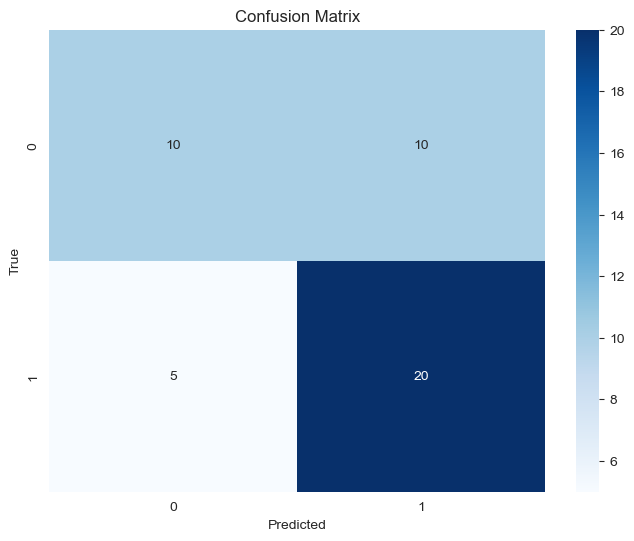

Classification Report for feature1 with 80:20 split:
              precision    recall  f1-score   support

           0       0.67      0.50      0.57        20
           1       0.67      0.80      0.73        25

    accuracy                           0.67        45
   macro avg       0.67      0.65      0.65        45
weighted avg       0.67      0.67      0.66        45

Accuracy for 50:50 split with 1 feature: 0.59


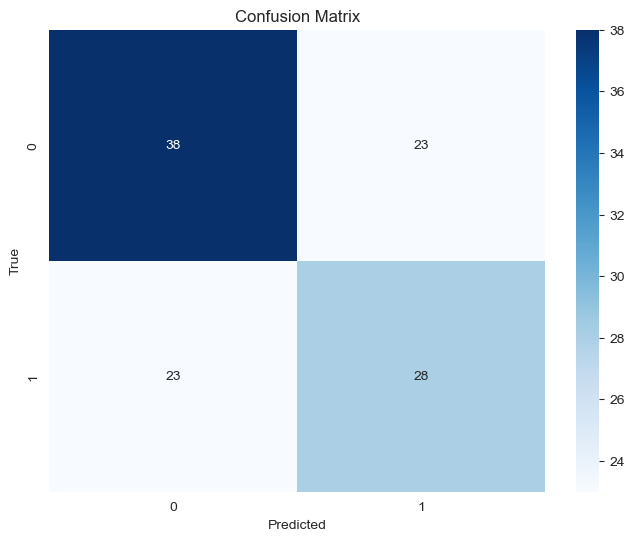

Classification Report for feature1 with 50:50 split:
              precision    recall  f1-score   support

           0       0.62      0.62      0.62        61
           1       0.55      0.55      0.55        51

    accuracy                           0.59       112
   macro avg       0.59      0.59      0.59       112
weighted avg       0.59      0.59      0.59       112

Accuracy for 80:20 split with 2 features: 0.58


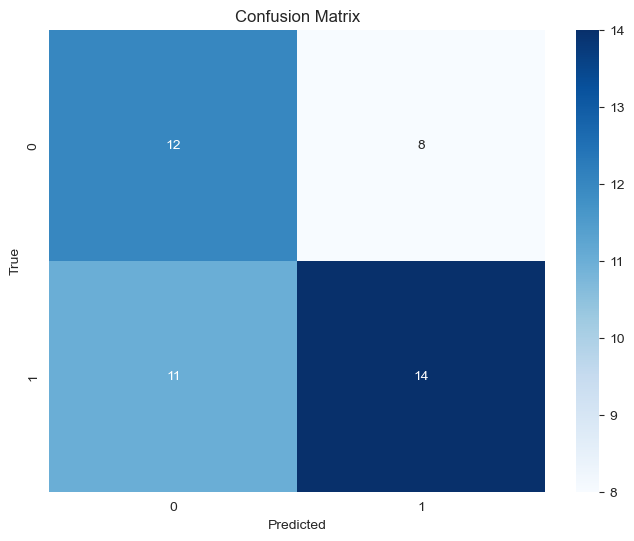

Classification Report for feature2 with 80:20 split:
              precision    recall  f1-score   support

           0       0.52      0.60      0.56        20
           1       0.64      0.56      0.60        25

    accuracy                           0.58        45
   macro avg       0.58      0.58      0.58        45
weighted avg       0.59      0.58      0.58        45

Accuracy for 50:50 split with 2 features: 0.69


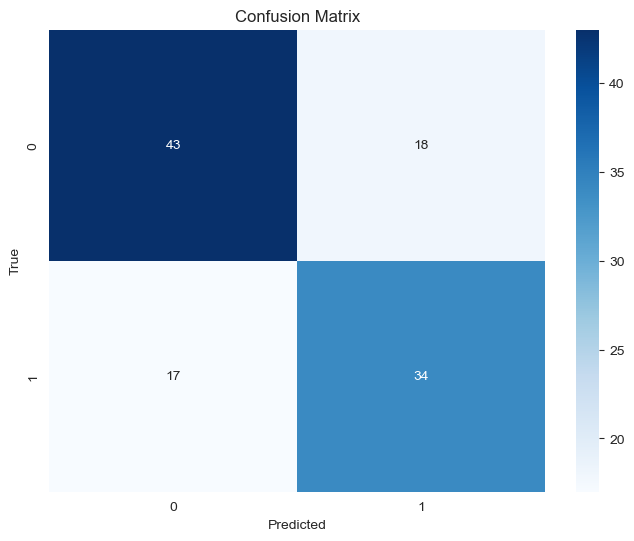

Classification Report for feature2 with 50:50 split:
              precision    recall  f1-score   support

           0       0.72      0.70      0.71        61
           1       0.65      0.67      0.66        51

    accuracy                           0.69       112
   macro avg       0.69      0.69      0.69       112
weighted avg       0.69      0.69      0.69       112

Accuracy for 80:20 split with 3 features: 0.60


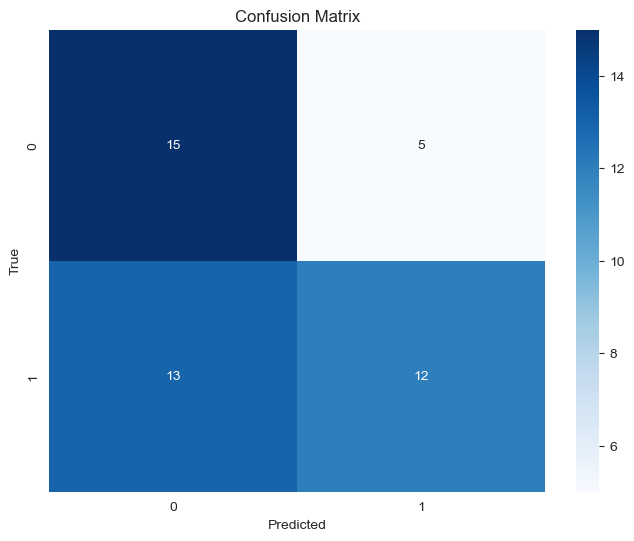

Classification Report for feature3 with 80:20 split:
              precision    recall  f1-score   support

           0       0.54      0.75      0.63        20
           1       0.71      0.48      0.57        25

    accuracy                           0.60        45
   macro avg       0.62      0.61      0.60        45
weighted avg       0.63      0.60      0.60        45

Accuracy for 50:50 split with 3 features: 0.67


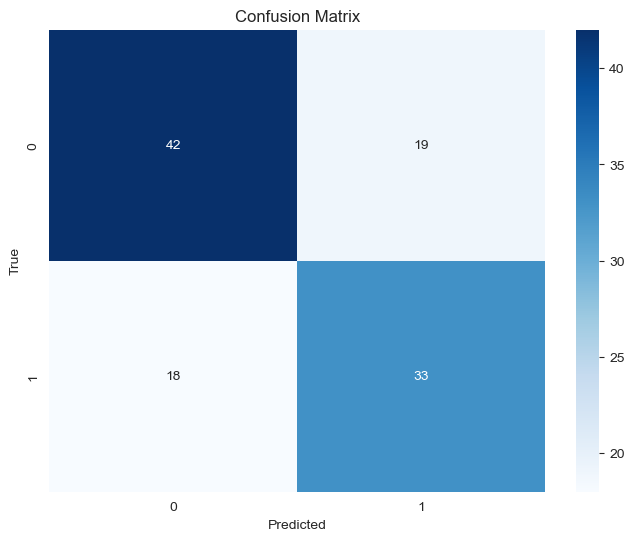

Classification Report for feature1 with 50:50 split:
              precision    recall  f1-score   support

           0       0.70      0.69      0.69        61
           1       0.63      0.65      0.64        51

    accuracy                           0.67       112
   macro avg       0.67      0.67      0.67       112
weighted avg       0.67      0.67      0.67       112

Accuracy for 80:20 split with 4 features: 0.67


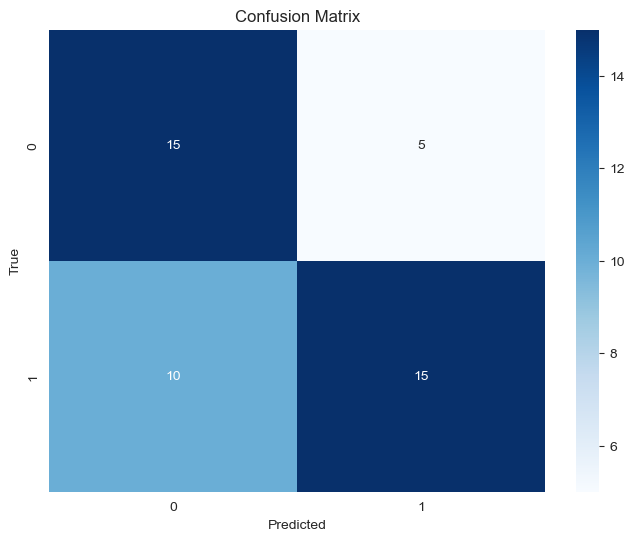

Classification Report for feature4 with 80:20 split:
              precision    recall  f1-score   support

           0       0.60      0.75      0.67        20
           1       0.75      0.60      0.67        25

    accuracy                           0.67        45
   macro avg       0.68      0.68      0.67        45
weighted avg       0.68      0.67      0.67        45

Accuracy for 50:50 split with 4 features: 0.55


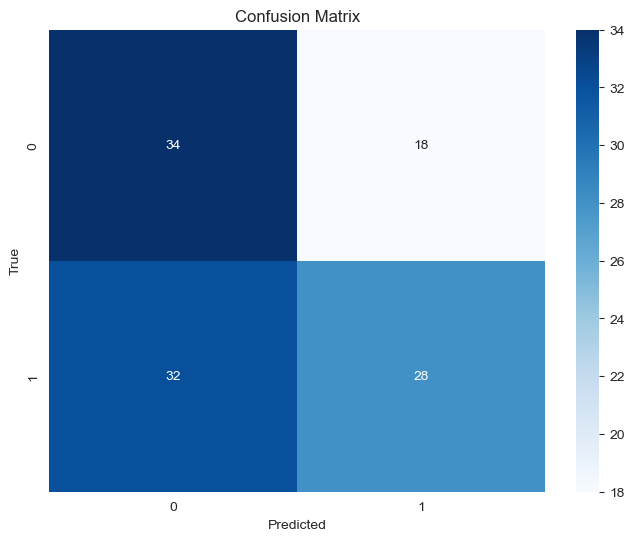

Classification Report for feature4 with 50:50 split:
              precision    recall  f1-score   support

           0       0.52      0.65      0.58        52
           1       0.61      0.47      0.53        60

    accuracy                           0.55       112
   macro avg       0.56      0.56      0.55       112
weighted avg       0.57      0.55      0.55       112



In [254]:
# next, test it out with Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier

RFC = RandomForestClassifier(max_depth=200, random_state=1234)  # initialize the mode, beyond 10, there's marginal difference in accuracy
RFC.fit(X1_train_80_raw, y1_train_80_raw)  # fit the model
y_pred = RFC.predict(X1_test_20_raw)

accuracy = accuracy_score(y1_test_20_raw, y_pred)
print(f"Accuracy for 80:20 split with 1 feature: {accuracy:.2f}")

# Create a confusion matrix
cm = confusion_matrix(y1_test_20_raw, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y1_test_20_raw), yticklabels=np.unique(y1_test_20_raw))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Create a classification report
print("Classification Report for feature1 with 80:20 split:")
print(classification_report(y1_test_20_raw, y_pred))


RFC.fit(X1_train_50_raw, y1_train_50_raw)
y_pred = RFC.predict(X1_test_50_raw)

accuracy = accuracy_score(y1_test_50_raw, y_pred) #compare the predicted vs actual scores
print(f"Accuracy for 50:50 split with 1 feature: {accuracy:.2f}")

#create a confusion matrix
cm = confusion_matrix(y1_test_50_raw, y_pred)

#plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y1_test_50_raw), yticklabels=np.unique(y1_test_50_raw))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report for feature1 with 50:50 split:")
print(classification_report(y1_test_50_raw, y_pred))

#2nd split
RFC.fit(X2_train_80_raw, y2_train_80_raw)
y_pred = RFC.predict(X2_test_20_raw)

accuracy = accuracy_score(y2_test_20_raw, y_pred) #compare the predicted vs actual scores
print(f"Accuracy for 80:20 split with 2 features: {accuracy:.2f}")

#create a confusion matrix
cm = confusion_matrix(y2_test_20_raw, y_pred)

#plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y2_test_20_raw), yticklabels=np.unique(y2_test_50_raw))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report for feature2 with 80:20 split:")
print(classification_report(y2_test_20_raw, y_pred))

RFC.fit(X2_train_50_raw, y2_train_50_raw)
y_pred = RFC.predict(X2_test_50_raw)

accuracy = accuracy_score(y2_test_50_raw, y_pred) #compare the predicted vs actual scores
print(f"Accuracy for 50:50 split with 2 features: {accuracy:.2f}")

#create a confusion matrix
cm = confusion_matrix(y2_test_50_raw, y_pred)

#plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y2_test_50_raw), yticklabels=np.unique(y2_test_50_raw))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report for feature2 with 50:50 split:")
print(classification_report(y2_test_50_raw, y_pred))


# 3rd splits
RFC.fit(X3_train_80_raw, y3_train_80_raw)
y_pred = RFC.predict(X3_test_20_raw)

accuracy = accuracy_score(y3_test_20_raw, y_pred) #compare the predicted vs actual scores
print(f"Accuracy for 80:20 split with 3 features: {accuracy:.2f}")

#create a confusion matrix
cm = confusion_matrix(y3_test_20_raw, y_pred)

#plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y3_test_20_raw), yticklabels=np.unique(y3_test_20_raw))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report for feature3 with 80:20 split:")
print(classification_report(y3_test_20_raw, y_pred))

RFC.fit(X3_train_50_raw, y3_train_50_raw)
y_pred = RFC.predict(X3_test_50_raw)

accuracy = accuracy_score(y3_test_50_raw, y_pred) #compare the predicted vs actual scores
print(f"Accuracy for 50:50 split with 3 features: {accuracy:.2f}")

#create a confusion matrix
cm = confusion_matrix(y3_test_50_raw, y_pred)

#plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y3_test_50_raw), yticklabels=np.unique(y3_test_50_raw))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report for feature1 with 50:50 split:")
print(classification_report(y3_test_50_raw, y_pred))

#4th split
RFC.fit(X4_train_80_raw, y4_train_80_raw)
y_pred = RFC.predict(X4_test_20_raw)

accuracy = accuracy_score(y4_test_20_raw, y_pred) #compare the predicted vs actual scores
print(f"Accuracy for 80:20 split with 4 features: {accuracy:.2f}")

#create a confusion matrix
cm = confusion_matrix(y4_test_20_raw, y_pred)

#plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y4_test_20_raw), yticklabels=np.unique(y4_test_20_raw))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report for feature4 with 80:20 split:")
print(classification_report(y4_test_20_raw, y_pred))

RFC.fit(X4_train_50_raw, y4_train_50_raw)
y_pred = RFC.predict(X4_test_50_raw)

accuracy = accuracy_score(y4_test_50_raw, y_pred) #compare the predicted vs actual scores
print(f"Accuracy for 50:50 split with 4 features: {accuracy:.2f}")

#create a confusion matrix
cm = confusion_matrix(y4_test_50_raw, y_pred)

#plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y4_test_50_raw), yticklabels=np.unique(y4_test_50_raw))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report for feature4 with 50:50 split:")
print(classification_report(y4_test_50_raw, y_pred))

Accuracy for 80:20 split with 1 feature: 0.58


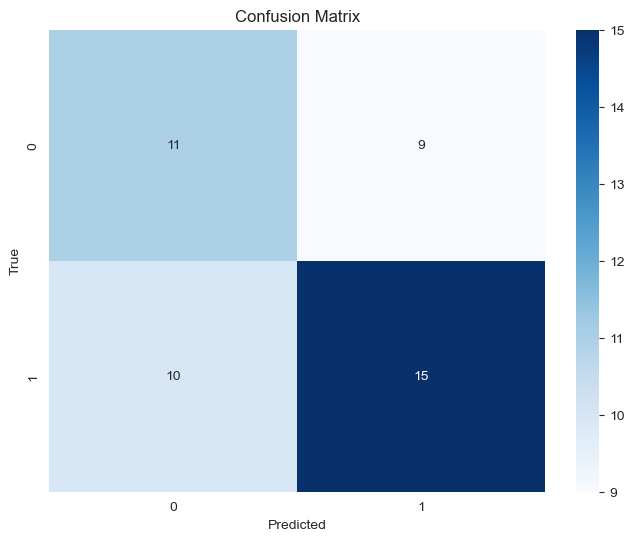

Classification Report for feature1 with 80:20 split:
              precision    recall  f1-score   support

           0       0.52      0.55      0.54        20
           1       0.62      0.60      0.61        25

    accuracy                           0.58        45
   macro avg       0.57      0.57      0.57        45
weighted avg       0.58      0.58      0.58        45

Accuracy for 50:50 split with 1 feature: 0.60


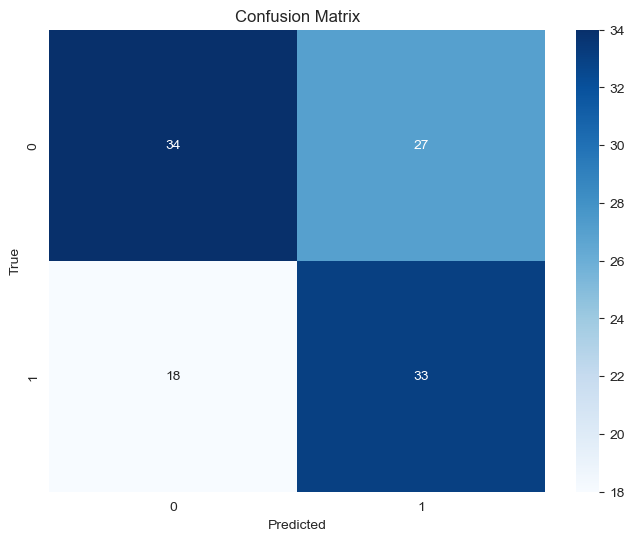

Classification Report for feature1 with 50:50 split:
              precision    recall  f1-score   support

           0       0.65      0.56      0.60        61
           1       0.55      0.65      0.59        51

    accuracy                           0.60       112
   macro avg       0.60      0.60      0.60       112
weighted avg       0.61      0.60      0.60       112

Accuracy for 80:20 split with 2 features: 0.73


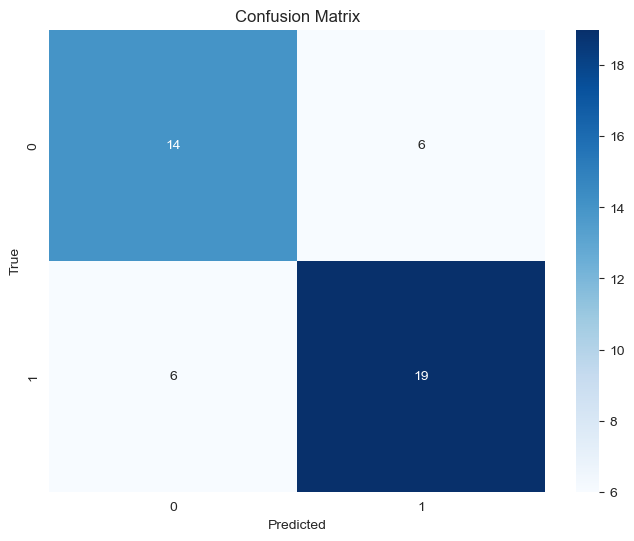

Classification Report for feature2 with 80:20 split:
              precision    recall  f1-score   support

           0       0.70      0.70      0.70        20
           1       0.76      0.76      0.76        25

    accuracy                           0.73        45
   macro avg       0.73      0.73      0.73        45
weighted avg       0.73      0.73      0.73        45

Accuracy for 50:50 split with 2 features: 0.67


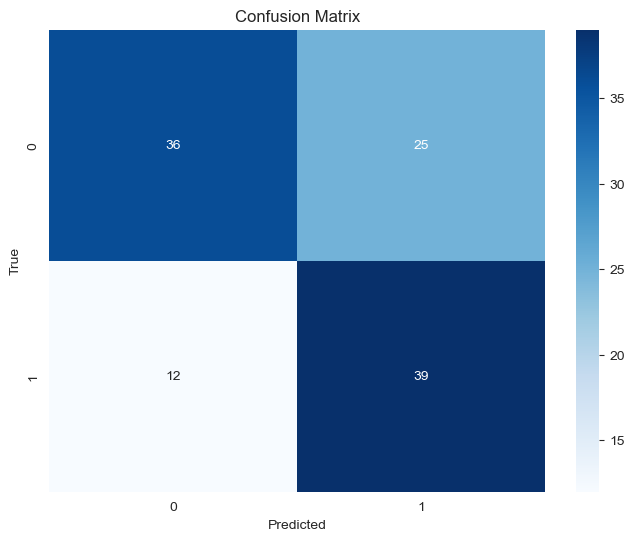

Classification Report for feature2 with 50:50 split:
              precision    recall  f1-score   support

           0       0.75      0.59      0.66        61
           1       0.61      0.76      0.68        51

    accuracy                           0.67       112
   macro avg       0.68      0.68      0.67       112
weighted avg       0.69      0.67      0.67       112

Accuracy for 80:20 split with 3 features: 0.67


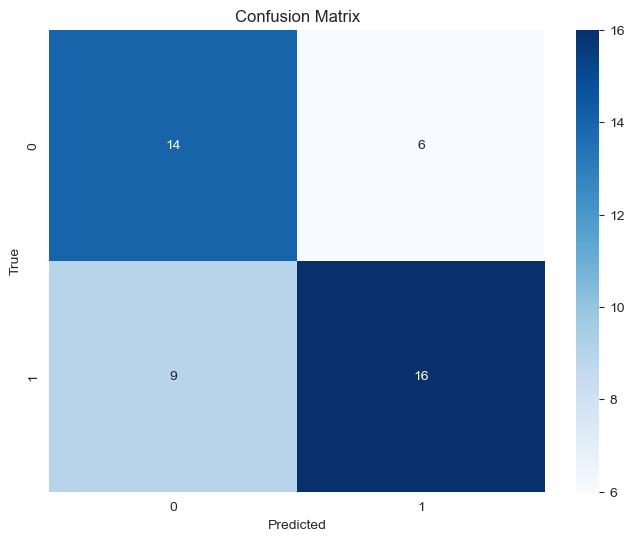

Classification Report for feature3 with 80:20 split:
              precision    recall  f1-score   support

           0       0.61      0.70      0.65        20
           1       0.73      0.64      0.68        25

    accuracy                           0.67        45
   macro avg       0.67      0.67      0.67        45
weighted avg       0.67      0.67      0.67        45

Accuracy for 50:50 split with 3 features: 0.62


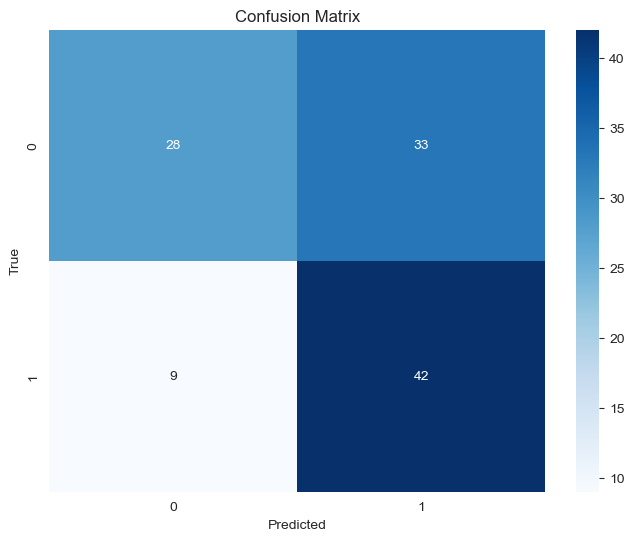

Classification Report for feature1 with 50:50 split:
              precision    recall  f1-score   support

           0       0.76      0.46      0.57        61
           1       0.56      0.82      0.67        51

    accuracy                           0.62       112
   macro avg       0.66      0.64      0.62       112
weighted avg       0.67      0.62      0.61       112

Accuracy for 80:20 split with 4 features: 0.76


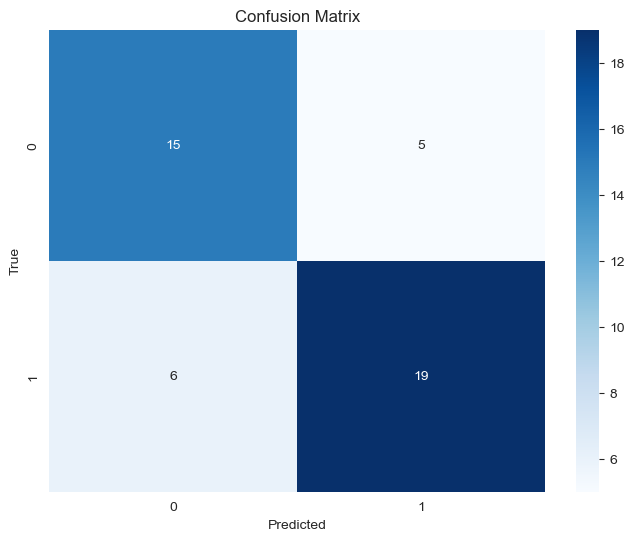

Classification Report for feature4 with 80:20 split:
              precision    recall  f1-score   support

           0       0.71      0.75      0.73        20
           1       0.79      0.76      0.78        25

    accuracy                           0.76        45
   macro avg       0.75      0.76      0.75        45
weighted avg       0.76      0.76      0.76        45

Accuracy for 50:50 split with 4 features: 0.58


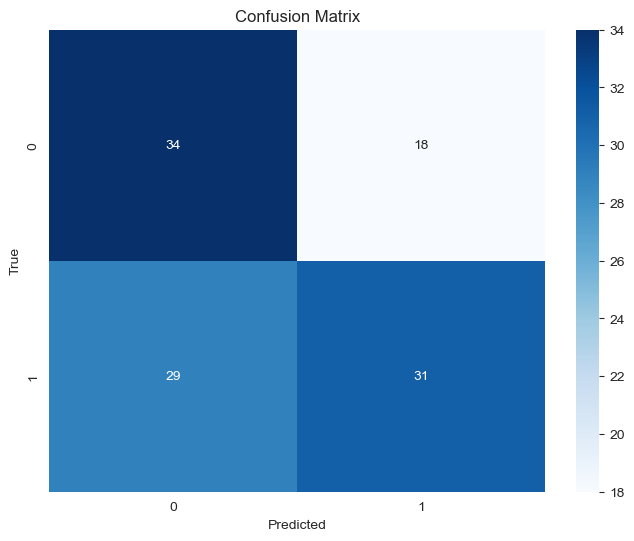

Classification Report for feature4 with 50:50 split:
              precision    recall  f1-score   support

           0       0.54      0.65      0.59        52
           1       0.63      0.52      0.57        60

    accuracy                           0.58       112
   macro avg       0.59      0.59      0.58       112
weighted avg       0.59      0.58      0.58       112



In [255]:
from sklearn.ensemble import AdaBoostClassifier   # check the classification details for AdaBoost

ABC = AdaBoostClassifier(n_estimators=10, random_state=0)  # initialize our model

ABC.fit(X1_train_80_raw, y1_train_80_raw)  # fit the model
y_pred = ABC.predict(X1_test_20_raw)

accuracy = accuracy_score(y1_test_20_raw, y_pred)
print(f"Accuracy for 80:20 split with 1 feature: {accuracy:.2f}")

# Create a confusion matrix
cm = confusion_matrix(y1_test_20_raw, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y1_test_20_raw), yticklabels=np.unique(y1_test_20_raw))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Create a classification report
print("Classification Report for feature1 with 80:20 split:")
print(classification_report(y1_test_20_raw, y_pred))


ABC.fit(X1_train_50_raw, y1_train_50_raw)
y_pred = ABC.predict(X1_test_50_raw)

accuracy = accuracy_score(y1_test_50_raw, y_pred) #compare the predicted vs actual scores
print(f"Accuracy for 50:50 split with 1 feature: {accuracy:.2f}")

#create a confusion matrix
cm = confusion_matrix(y1_test_50_raw, y_pred)

#plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y1_test_50_raw), yticklabels=np.unique(y1_test_50_raw))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report for feature1 with 50:50 split:")
print(classification_report(y1_test_50_raw, y_pred))

#2nd split
ABC.fit(X2_train_80_raw, y2_train_80_raw)
y_pred = ABC.predict(X2_test_20_raw)

accuracy = accuracy_score(y2_test_20_raw, y_pred) #compare the predicted vs actual scores
print(f"Accuracy for 80:20 split with 2 features: {accuracy:.2f}")

#create a confusion matrix
cm = confusion_matrix(y2_test_20_raw, y_pred)

#plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y2_test_20_raw), yticklabels=np.unique(y2_test_50_raw))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report for feature2 with 80:20 split:")
print(classification_report(y2_test_20_raw, y_pred))

ABC.fit(X2_train_50_raw, y2_train_50_raw)
y_pred = ABC.predict(X2_test_50_raw)

accuracy = accuracy_score(y2_test_50_raw, y_pred) #compare the predicted vs actual scores
print(f"Accuracy for 50:50 split with 2 features: {accuracy:.2f}")

#create a confusion matrix
cm = confusion_matrix(y2_test_50_raw, y_pred)

#plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y2_test_50_raw), yticklabels=np.unique(y2_test_50_raw))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report for feature2 with 50:50 split:")
print(classification_report(y2_test_50_raw, y_pred))


# 3rd splits
ABC.fit(X3_train_80_raw, y3_train_80_raw)
y_pred = ABC.predict(X3_test_20_raw)

accuracy = accuracy_score(y3_test_20_raw, y_pred) #compare the predicted vs actual scores
print(f"Accuracy for 80:20 split with 3 features: {accuracy:.2f}")

#create a confusion matrix
cm = confusion_matrix(y3_test_20_raw, y_pred)

#plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y3_test_20_raw), yticklabels=np.unique(y3_test_20_raw))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report for feature3 with 80:20 split:")
print(classification_report(y3_test_20_raw, y_pred))

ABC.fit(X3_train_50_raw, y3_train_50_raw)
y_pred = ABC.predict(X3_test_50_raw)

accuracy = accuracy_score(y3_test_50_raw, y_pred) #compare the predicted vs actual scores
print(f"Accuracy for 50:50 split with 3 features: {accuracy:.2f}")

#create a confusion matrix
cm = confusion_matrix(y3_test_50_raw, y_pred)

#plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y3_test_50_raw), yticklabels=np.unique(y3_test_50_raw))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report for feature1 with 50:50 split:")
print(classification_report(y3_test_50_raw, y_pred))

#4th split
ABC.fit(X4_train_80_raw, y4_train_80_raw)
y_pred = ABC.predict(X4_test_20_raw)

accuracy = accuracy_score(y4_test_20_raw, y_pred) #compare the predicted vs actual scores
print(f"Accuracy for 80:20 split with 4 features: {accuracy:.2f}")

#create a confusion matrix
cm = confusion_matrix(y4_test_20_raw, y_pred)

#plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y4_test_20_raw), yticklabels=np.unique(y4_test_20_raw))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report for feature4 with 80:20 split:")
print(classification_report(y4_test_20_raw, y_pred))

ABC.fit(X4_train_50_raw, y4_train_50_raw)
y_pred = ABC.predict(X4_test_50_raw)

accuracy = accuracy_score(y4_test_50_raw, y_pred) #compare the predicted vs actual scores
print(f"Accuracy for 50:50 split with 4 features: {accuracy:.2f}")

#create a confusion matrix
cm = confusion_matrix(y4_test_50_raw, y_pred)

#plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y4_test_50_raw), yticklabels=np.unique(y4_test_50_raw))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report for feature4 with 50:50 split:")
print(classification_report(y4_test_50_raw, y_pred))

In [256]:
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier

BGC1 = BaggingClassifier(estimator=SVC(), n_estimators=1000, random_state=0).fit(X1, y)   # initialize our models
BGC2 = BaggingClassifier(estimator=SVC(), n_estimators=1000, random_state=0).fit(X2, y)   # initialize our models
BGC3 = BaggingClassifier(estimator=SVC(), n_estimators=1000, random_state=0).fit(X3, y)   # initialize our models
BGC4 = BaggingClassifier(estimator=SVC(), n_estimators=1000, random_state=0).fit(X4, y)   # initialize our models

#predict the data for the 1st features
y_pred = BGC1.predict(X1_test_20_raw)
accuracy = accuracy_score(y1_test_20_raw, y_pred)
print(f"Accuracy for 80:20 split with 1 feature: {accuracy:.2f}")

y_pred = BGC1.predict(X1_test_50_raw)
accuracy = accuracy_score(y1_test_50_raw, y_pred)
print(f"Accuracy for 50:50 split with 1 feature: {accuracy:.2f}")

y_pred = BGC2.predict(X2_test_20_raw)
accuracy = accuracy_score(y2_test_20_raw, y_pred)
print(f"Accuracy for 80:20 split with 2 features: {accuracy:.2f}")

y_pred = BGC2.predict(X2_test_50_raw)
accuracy = accuracy_score(y2_test_50_raw, y_pred)
print(f"Accuracy for 50:50 split with 2 features: {accuracy:.2f}")

y_pred = BGC3.predict(X3_test_20_raw)
accuracy = accuracy_score(y3_test_20_raw, y_pred)
print(f"Accuracy for 80:20 split with 3 features: {accuracy:.2f}")

y_pred = BGC3.predict(X3_test_50_raw)
accuracy = accuracy_score(y3_test_50_raw, y_pred)
print(f"Accuracy for 50:50 split with 3 features: {accuracy:.2f}")

y_pred = BGC4.predict(X4_test_20_raw)
accuracy = accuracy_score(y4_test_20_raw, y_pred)
print(f"Accuracy for 80:20 split with 4 features: {accuracy:.2f}")

y_pred = BGC4.predict(X4_test_50_raw)
accuracy = accuracy_score(y4_test_50_raw, y_pred)
print(f"Accuracy for 80:20 split with 4 features: {accuracy:.2f}")



Accuracy for 80:20 split with 1 feature: 0.60
Accuracy for 50:50 split with 1 feature: 0.54
Accuracy for 80:20 split with 2 features: 0.44
Accuracy for 50:50 split with 2 features: 0.54
Accuracy for 80:20 split with 3 features: 0.51
Accuracy for 50:50 split with 3 features: 0.57
Accuracy for 80:20 split with 4 features: 0.51
Accuracy for 80:20 split with 4 features: 0.51


In [259]:
df_class.dtypes

Entity                 int64
Year                   int32
Records              float64
Method                 int64
Organization_type      int64
dtype: object

Neural Network classification models below, the above models were some models from sickit learn that had subpar performances.

In [261]:
from sklearn.metrics import roc_curve
from sklearn.model_selection import StratifiedKFold

print(X1)
X1 = X1.apply(pd.to_numeric, errors='coerce')

#drop rows with missing values
X1 = X1.dropna()

# Convert to 2D PyTorch tensors
X1 = torch.tensor(X1.values, dtype=torch.float32)  # convert X1 with single feature into a tensor
X2 = torch.tensor(X2.values, dtype=torch.float32)  # convert X2 with 2 feature into a tensor
X3 = torch.tensor(X3.values, dtype=torch.float32) # convert X3 with 3 feature into a tensor
X4 = torch.tensor(X4.values, dtype=torch.float32) # convert X4 with 4 features into a tensor
y = torch.tensor(y, dtype=torch.float32).reshape(-1, 1)  # convert the Method label into tensor
 
# Define two models
class Wide(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden = nn.Linear(60, 180)
        self.relu = nn.ReLU()
        self.output = nn.Linear(180, 1)
        self.sigmoid = nn.Sigmoid()
 
    def forward(self, x):
        x = self.relu(self.hidden(x))
        x = self.sigmoid(self.output(x))
        return x
 
class Deep(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(60, 60)
        self.act1 = nn.ReLU()
        self.layer2 = nn.Linear(60, 60)
        self.act2 = nn.ReLU()
        self.layer3 = nn.Linear(60, 60)
        self.act3 = nn.ReLU()
        self.output = nn.Linear(60, 1)
        self.sigmoid = nn.Sigmoid()
 
    def forward(self, x):
        x = self.act1(self.layer1(x))
        x = self.act2(self.layer2(x))
        x = self.act3(self.layer3(x))
        x = self.sigmoid(self.output(x))
        return x
 
# Compare model sizes
model1 = Wide()
model2 = Deep()
print(sum([x.reshape(-1).shape[0] for x in model1.parameters()]))  # 11161
print(sum([x.reshape(-1).shape[0] for x in model2.parameters()]))  # 11041
 
# Helper function to train one model
def model_train(model, X_train, y_train, X_val, y_val):
    # loss function and optimizer
    loss_fn = nn.BCELoss()  # binary cross entropy
    optimizer = optim.Adam(model.parameters(), lr=0.0001)
 
    n_epochs = 300   # number of epochs to run
    batch_size = 10  # size of each batch
    batch_start = torch.arange(0, len(X_train), batch_size)
 
    # Hold the best model
    best_acc = - np.inf   # init to negative infinity
    best_weights = None
 
    for epoch in range(n_epochs):
        model.train()
        with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
            bar.set_description(f"Epoch {epoch}")
            for start in bar:
                # take a batch
                X_batch = X_train[start:start+batch_size]
                y_batch = y_train[start:start+batch_size]
                # forward pass
                y_pred = model(X_batch)
                loss = loss_fn(y_pred, y_batch)
                # backward pass
                optimizer.zero_grad()
                loss.backward()
                # update weights
                optimizer.step()
                # print progress
                acc = (y_pred.round() == y_batch).float().mean()
                bar.set_postfix(
                    loss=float(loss),
                    acc=float(acc)
                )
        # evaluate accuracy at end of each epoch
        model.eval()
        y_pred = model(X_val)
        acc = (y_pred.round() == y_val).float().mean()
        acc = float(acc)
        if acc > best_acc:
            best_acc = acc
            best_weights = copy.deepcopy(model.state_dict())
    # restore model and return best accuracy
    model.load_state_dict(best_weights)
    return best_acc
 
# train-test split: Hold out the test set for final model evaluation
X_train, X_test, y_train, y_test = train_test_split(X1, y, train_size=0.7, shuffle=True)
 
# define 5-fold cross validation test harness
kfold = StratifiedKFold(n_splits=5, shuffle=True)
cv_scores_wide = []
for train, test in kfold.split(X_train, y_train):
    # create model, train, and get accuracy
    model = Wide()
    acc = model_train(model, X_train[train], y_train[train], X_train[test], y_train[test])
    print("Accuracy (wide): %.2f" % acc)
    cv_scores_wide.append(acc)
cv_scores_deep = []
for train, test in kfold.split(X_train, y_train):
    # create model, train, and get accuracy
    model = Deep()
    acc = model_train(model, X_train[train], y_train[train], X_train[test], y_train[test])
    print("Accuracy (deep): %.2f" % acc)
    cv_scores_deep.append(acc)
 
# evaluate the model
wide_acc = np.mean(cv_scores_wide)
wide_std = np.std(cv_scores_wide)
deep_acc = np.mean(cv_scores_deep)
deep_std = np.std(cv_scores_deep)
print("Wide: %.2f%% (+/- %.2f%%)" % (wide_acc*100, wide_std*100))
print("Deep: %.2f%% (+/- %.2f%%)" % (deep_acc*100, deep_std*100))
 
# rebuild model with full set of training data
if wide_acc > deep_acc:
    print("Retrain a wide model")
    model = Wide()
else:
    print("Retrain a deep model")
    model = Deep()
acc = model_train(model, X_train, y_train, X_test, y_test)
print(f"Final model accuracy: {acc*100:.2f}%")
 
model.eval()
with torch.no_grad():
    # Test out inference with 5 samples
    for i in range(5):
        y_pred = model(X_test[i:i+1])
        print(f"{X_test[i].numpy()} -> {y_pred[0].numpy()} (expected {y_test[i].numpy()})")
 
    # Plot the ROC curve
    y_pred = model(X_test)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    plt.plot(fpr, tpr) # ROC curve = TPR vs FPR
    plt.title("Receiver Operating Characteristics")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.show()

tensor([[23.],
        [44.],
        [23.],
        [46.],
        [46.],
        [23.],
        [ 6.],
        [23.],
        [50.],
        [53.],
        [16.],
        [23.],
        [23.],
        [47.],
        [46.],
        [23.],
        [51.],
        [51.],
        [23.],
        [40.],
        [51.],
        [51.],
        [10.],
        [16.],
        [16.],
        [16.],
        [23.],
        [ 8.],
        [53.],
        [18.],
        [15.],
        [53.],
        [23.],
        [11.],
        [ 7.],
        [23.],
        [23.],
        [23.],
        [18.],
        [23.],
        [51.],
        [23.],
        [24.],
        [40.],
        [22.],
        [18.],
        [18.],
        [40.],
        [30.],
        [46.],
        [39.],
        [23.],
        [46.],
        [18.],
        [23.],
        [23.],
        [13.],
        [ 9.],
        [23.],
        [51.],
        [43.],
        [43.],
        [43.],
        [43.],
        [43.],
        [40.],
        [1

AttributeError: 'Tensor' object has no attribute 'apply'

In [ ]:
# first, we will test out some regression models available in sickit learn
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score  # import the metrics we will be using

# initialize linear regression model and check it's performance
linear_regression = linear_model.LinearRegression()  # import the LinearRegression mode

linear_regression.fit(X_train1_75_raw, y_train1_75_raw)
y_test1_25_raw_pred = linear_regression.predict(X_test1_25_raw)  # test the model


# The coefficients
print("Coefficients: \n", linear_regression.coef_)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test1_25_raw, y_test1_25_raw_pred))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_test1_25_raw, y_test1_25_raw_pred))

#plot outputs
print(X_test1_25_raw.shape)
print(y_test1_25_raw.shape)
print(y_test1_25_raw_pred.shape)

# Reshape the y_test1_25_raw and y_test1_25_raw_pred arrays
""" --> unneccessary
y_test1_25_raw = np.ravel(y_test1_25_raw)
y_test1_25_raw = np.reshape(y_test1_25_raw, (88, 1))
y_test1_25_raw_pred = np.ravel(y_test1_25_raw_pred)
y_test1_25_raw_pred = np.reshape(y_test1_25_raw_pred, (88, 1)) """

# Plot the arrays
plt.rcParams["figure.autolayout"] = True
plt.scatter(y_test1_25_raw, y_test1_25_raw_pred, c=y_test1_25_raw_pred)
#plt.plot(X_test1_25_raw, y_test1_25_raw_pred)
plt.xlabel("Predicted Value")
plt.ylabel("Actual Value")
#plt.xticks(())
#plt.yticks(())
plt.show()

In [ ]:
#train/test the model on the other 2nd data split
linear_regression.fit(X_train1_50_raw, y_train1_50_raw)
y_test1_50_raw_pred = linear_regression.predict(X_test1_50_raw)

# The coefficients
print("Coefficients: \n", linear_regression.coef_)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test1_50_raw, y_test1_50_raw_pred))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_test1_50_raw, y_test1_50_raw_pred))

# Plot the arrays
plt.scatter(y_test1_50_raw, y_test1_50_raw_pred, c=y_test1_50_raw)
#plt.plot(X_test1_25_raw, y_test1_25_raw_pred)
plt.xlabel("Actual Value")
plt.ylabel("predicted Value")
plt.show()

In [ ]:
linear_regression.fit(X_train1_90_raw, y_train1_90_raw)
y_test1_10_raw_pred = linear_regression.predict(X_test1_10_raw)

# The coefficients
print("Coefficients: \n", linear_regression.coef_)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test1_10_raw, y_test1_10_raw_pred))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_test1_10_raw, y_test1_10_raw_pred))
# Plot the arrays
plt.scatter(y_test1_50_raw_pred, y_test1_50_raw)
#plt.plot(X_test1_25_raw, y_test1_25_raw_pred)
plt.xlabel("Actual Value")
plt.ylabel("predicted Value")
plt.xticks(())
plt.yticks(())
plt.show()

In [ ]:
linear_regression.fit(X_train2_75_raw, y_train2_75_raw)
y_test2_25_raw_pred = linear_regression.predict(X_test2_25_raw)

# The coefficients
print("Coefficients: \n", linear_regression.coef_)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test2_25_raw, y_test2_25_raw_pred))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_test2_25_raw, y_test2_25_raw_pred))
# Plot the arrays
plt.scatter(y_test1_50_raw_pred, y_test1_50_raw)
#plt.plot(X_test1_25_raw, y_test1_25_raw_pred)
plt.xlabel("Actual Value")
plt.ylabel("predicted Value")
plt.xticks(())
plt.yticks(())
plt.show()

In [ ]:

# standardizze the data, we will need to do this for all 12 data splits we have made 
# standardize the first split
scaler = StandardScaler()
scaler.fit(X_train1_75_raw)
X_train1_75 = scaler.transform(X_train1_75_raw)
X_test1_25 = scaler.transform(X_test1_25_raw)

#standardize the second split
scaler.fit(X_train1_50_raw)
X_train1_50 = scaler.transform(X_train1_50_raw)
X_test1_50 = scaler.transform(X_test1_50_raw)

# standardize the third split
scaler.fit(X_train1_90_raw)
X_train1_90 = scaler.transform(X_train1_90_raw)
X_test1_10 = scaler.transform(X_test1_10_raw)

#standarize the 4th split
scaler.fit(X_train2_75_raw)
X_train2_75 = scaler.transform(X_train2_75_raw)
X_test2_25 = scaler.transform(X_test2_25_raw)

# standardize the 5th split
scaler.fit(X_train2_50_raw)
X_train2_50 = scaler.transform(X_train2_50_raw)
X_test2_50 = scaler.transform(X_test2_50_raw)

#standarize the 6th split
scaler.fit(X_train2_90_raw)
X_train2_90 = scaler.transform(X_train2_90_raw)
X_test2_10 = scaler.transform(X_test2_10_raw)

#standardize the 7th split
scaler.fit(X_train3_75_raw)
X_train3_75 = scaler.transform(X_train3_75_raw)
X_test3_25 = scaler.transform(X_test3_25_raw)

#standardize the 8th split
scaler.fit(X_train3_50_raw)
X_train3_50 = scaler.transform(X_train3_50_raw)
X_test3_50 = scaler.transform(X_test3_50_raw)

# standardize the 9th split
scaler.fit(X_train3_90_raw)
X_train3_90 = scaler.transform(X_train3_90_raw)
X_test3_10 = scaler.transform(X_test3_10_raw)

# convert to 2D PyTorch sensors
"""
    Some insights regarding why Tensors are important when it comes to training models in pytorch
    
    Tensors are fundamental data structure in pyTorch. They are used to represent all kinds of data, including inputs, outputs and parameters of models. Tensors are similar to Numpy arrays but they have several advantages:
    
    - Tensors can run on GPUs: PyTorch can automatically move tensors to the GPU for acceleration. This can lead to significant performance improvements, especially for large models and datasets
    - Tensors are optimized for automatic differentiation. PyTorch's autograd library can automatically compute the gradients of tensors with respect to each other. This is essential for training neural networks using gradient descent.
    - Tensors have a rich set of mathematical operations: PyTorch provides a wide range of operations for tensors, including linear algebra, convolution, and pooling. This makes it easy to implement complex models in PyTorch
"""
# again, we will need to do this for all 9 splits in our case

# 2d pytorch tensor for 1st split
X_train1_75 = torch.tensor(X_train1_75, dtype=torch.float32)  
y_train1_75 = torch.tensor(y_train1_75_raw.to_numpy(), dtype=torch.float32).reshape(-1,1)  #if you don't add to_numpy() next to the training datasets that are of type series, the console will throw an error
X_test1_25 = torch.tensor(X_test1_25, dtype=torch.float32)
y_test1_25 = torch.tensor(y_test1_25_raw.to_numpy(), dtype=torch.float32).reshape(-1,1)

#2d pytorch tensor for 2nd split
X_train1_50 = torch.tensor(X_train1_50, dtype=torch.float32)  
y_train1_50 = torch.tensor(y_train1_50_raw.to_numpy(), dtype=torch.float32).reshape(-1,1)
X_test1_50 = torch.tensor(X_test1_50, dtype=torch.float32)
y_test1_50 = torch.tensor(y_test1_50_raw.to_numpy(), dtype=torch.float32).reshape(-1,1)

# 2d pytorch tensor for 3rd split
X_train1_90 = torch.tensor(X_train1_90, dtype=torch.float32)  
y_train1_90 = torch.tensor(y_train1_90_raw.to_numpy(), dtype=torch.float32).reshape(-1,1)
X_test1_10 = torch.tensor(X_test1_10, dtype=torch.float32)
y_test1_10 = torch.tensor(y_test1_10_raw.to_numpy(), dtype=torch.float32).reshape(-1,1)

# 2d pytorch tensor for 4th split
X_train2_75 = torch.tensor(X_train2_75, dtype=torch.float32)  
y_train2_75 = torch.tensor(y_train2_75_raw.to_numpy(), dtype=torch.float32).reshape(-1,1)
X_test2_25 = torch.tensor(X_test2_25, dtype=torch.float32)
y_test2_25 = torch.tensor(y_test2_25_raw.to_numpy(), dtype=torch.float32).reshape(-1,1)

# 2d pytorch tensor for the 5th split
X_train2_50 = torch.tensor(X_train2_50, dtype=torch.float32)  
y_train2_50 = torch.tensor(y_train2_50_raw.to_numpy(), dtype=torch.float32).reshape(-1,1)
X_test2_50 = torch.tensor(X_test2_50, dtype=torch.float32)
y_test2_50 = torch.tensor(y_test2_50_raw.to_numpy(), dtype=torch.float32).reshape(-1,1)

# 2d pytorch tensor for the 6th split
X_train2_90 = torch.tensor(X_train2_90, dtype=torch.float32)  
y_train2_90 = torch.tensor(y_train2_90_raw.to_numpy(), dtype=torch.float32).reshape(-1,1)
X_test2_10 = torch.tensor(X_test2_10, dtype=torch.float32)
y_test2_10 = torch.tensor(y_test2_10_raw.to_numpy(), dtype=torch.float32).reshape(-1,1)

# 2d pytorch tensor for the 7th split
X_train3_75 = torch.tensor(X_train3_75, dtype=torch.float32)  
y_train3_75 = torch.tensor(y_train3_75_raw.to_numpy(), dtype=torch.float32).reshape(-1,1)
X_test3_25 = torch.tensor(X_test3_25, dtype=torch.float32)
y_test3_25 = torch.tensor(y_test3_25_raw.to_numpy(), dtype=torch.float32).reshape(-1,1)

# 2d pytorch tensor for the 8th split
X_train3_50 = torch.tensor(X_train3_50, dtype=torch.float32)  
y_train3_50 = torch.tensor(y_train3_50_raw.to_numpy(), dtype=torch.float32).reshape(-1,1)
X_test3_50 = torch.tensor(X_test3_50, dtype=torch.float32)
y_test3_50 = torch.tensor(y_test3_50_raw.to_numpy(), dtype=torch.float32).reshape(-1,1)

# 2d pytorch tensor for the 9th split
X_train3_90 = torch.tensor(X_train3_90, dtype=torch.float32)  
y_train3_90 = torch.tensor(y_train3_90_raw.to_numpy(), dtype=torch.float32).reshape(-1,1)
X_test3_10 = torch.tensor(X_test3_10, dtype=torch.float32)
y_test3_10 = torch.tensor(y_test3_10_raw.to_numpy(), dtype=torch.float32).reshape(-1,1)

# define the neural network that will be used for regression based analysis
model = nn.Sequential(
    nn.Linear(3, 6),  # adjusted input size to 3
    nn.ReLU(),
    nn.Linear(6,12),
    nn.ReLU(),
    nn.Linear(12,6),
    nn.ReLU(),
    nn.Linear(6,1)
)

# loss function and optimizer
loss_fn = nn.MSELoss()  # this will calculate the mean square error
optimizer = optim.Adam(model.parameters(), lr=0.0001)

n_epochs = 1000  # number of epochs to run the model, adjust this number as needed: 100, 10000, 10 etc.
batch_size = 10  # size of each batch
batch_start1 = torch.arange(0, len(X_train1_75), batch_size)
batch_start2 = torch.arange(0, len(X_train1_50), batch_size)
batch_start3 = torch.arange(0, len(X_train1_90), batch_size)
batch_start4 = torch.arange(0, len(X_train2_75), batch_size)
batch_start5 = torch.arange(0, len(X_train2_50), batch_size)
batch_start6 = torch.arange(0, len(X_train2_90), batch_size)
batch_start7 = torch.arange(0, len(X_train3_75), batch_size)
batch_start8 = torch.arange(0, len(X_train3_50), batch_size)
batch_start9 = torch.arange(0, len(X_train3_90), batch_size)

# hold the best model
best_mse = np.inf  # initialize the mse to infinity, will change later
best_weights = None
history = []

# model training loop below for 1000 epochs
for epoch in range(n_epochs):  #iterate over 1-100 epochs
    model.train()  # train the model
    with tqdm.tqdm(batch_start1, unit='batch', mininterval=0, disable=True) as bar:
        bar.set_description(f"Epoch {epoch}")
        for start in bar:
            # take a batch 
            X_batch = X_train1_75[start:start+batch_size]
            y_batch = y_train1_75[start:start+batch_size]
            #forward pass
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)  # compare the resulting data to find the loss function
            #backward pass
            optimizer.zero_grad()
            loss.backward()
            #update weights
            optimizer.step()
            # print progress
            bar.set_postfix(mse=float(loss))
    #evaluate accuracy at the end of each epoch
    model.eval()
    y_pred = model(X_test1_25)   # predict the data based on X test
    mse = loss_fn(y_pred, y_test1_25)  # compare the predicted value with the test data value, in this case, we are working with the 'Method' label
    mse = float(mse) # convert the value into float
    history.append(mse)  # save the mse after the  end of each epoch on the history array, to see the trend for performance each epoch
    if mse < best_mse:
        best_mse = mse  # update the best_mse value based on if a new smaller value has been found or not, the smaller the mse, the better the performance
        best_weights = deepcopy(model.state_dict())
        
    # Print performance after each epoch
    print(f"Epoch {epoch + 1}/{1000} - MSE: {mse:.4f}")
        
# restore the model and return best accuracy
model.load_state_dict(best_weights)
print("MSE: %.2f" % best_mse)  # print out the best mean square error value
print("RMSE: %.2f" %np.sqrt(best_mse))
plt.plot(history)
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.show()

model.eval()
with torch.no_grad():
    # test out the inference with 10 samples
    for i in range(10):
        X_sample = X_test1_25_raw[i: i+1]
        X_sample = scaler.transform(X_sample)
        X_sample = torch.tensor(X_sample, dtype=torch.float32)
        y_pred = model(X_sample)
        print(f"{X_test1_25_raw.iloc[i]} -> {y_pred[0].numpy()} (expected {y_test1_25[i].numpy()})")  # this will print out all the wrongly predicted values

print(history)

model.eval()
with torch.no_grad():
    y_pred = model(X_test1_25)
    plt.scatter(y_test1_25.numpy(), y_pred.numpy())
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Predictions vs Actual Values')
    plt.show()

In [ ]:
# convert all uppercase letters to lowercase
""" --> commented it out for now
df_vis['Method'] = df_vis['Method'].str.lower()

# replace all spaces with "_"
df_vis['Method'] = df_vis['Method'].str.replace(' ', '_')

# replace all slash signs with "_"
df_vis['Method'] = df_vis['Method'].str.replace('/', '_')

# replace all __ and ___ with _
df_vis['Method'] = df_vis['Method'].str.replace('___', '_')
df_vis['Method'] = df_vis['Method'].str.replace('__', '_')

# Checking the Records column

# Use the 'pd.to_numeric' function to check if the values in 'Records' can be converted to numbers
numeric_records = pd.to_numeric(df_vis['Records'], errors='coerce')

# Create a boolean mask where 'numeric_records' is NaN (indicating non-numeric values)
non_numeric_rows = df_vis[numeric_records.isna()]

# Print the rows where 'Records' contains non-numeric values
print(non_numeric_rows)

# Calculate the mean of 'Records' in year with NaN values
mean_records_2019 = df_vis[df_vis['Year'] == '2019']['Records'].mean()

df_vis.at[94, 'Records'] = mean_records_2019

# Create a boolean mask where 'numeric_records' is NaN (indicating non-numeric values)
non_numeric_rows = df_vis[numeric_records.isna()]

# Print the rows where 'Records' contains non-numeric values
print("After replacing NaN Records:")
print(non_numeric_rows)
#df_vis.head() """

In [ ]:
plt.figure(figsize=(12, 6))

# Sort the data by count in descending order
order = df_vis['Organization type'].value_counts().index

sns.countplot(data=df_vis, x='Organization type', order=order)
plt.title('Count of Records by Organization Type')
plt.xlabel('Organization Type')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

In [ ]:
plt.figure(figsize=(12, 6))

# Group the data by year and calculate the total records lost in each year
data_lost_by_year = df_vis.groupby('Year')['Records'].sum().reset_index()

# Create a line plot to visualize data loss over the years
sns.lineplot(data=data_lost_by_year, x='Year', y='Records')
plt.title('Data Loss Over the Years')
plt.xlabel('Year')
plt.ylabel('Total Records Lost')
plt.grid(True)
plt.show()